<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Finland/Outotec/Outotec_1H_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "OTE1VFIEUR"
data_resample = '1H'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-26 13:05:52,095 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-26 13:05:52,096 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for OTE1VFIEUR
2019-08-26 13:09:07,022 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-26 13:15:05,384 - findatapy.market.datavendorweb - WARNING - Problem downloading.. HTTPConnectionPool(host='datafeed.dukascopy.com', port=80): Read timed out. (read timeout=10)
2019-08-26 13:16:09,826 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-26 13:19:39,766 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-26 13:23:01,886 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-26 13:26:29,922 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-26 13:29:48,024 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
201

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


Open     High      Low    Close    Volume
Date                                                             
2018-01-02 08:00:00  0.07067  0.07108  0.07017  0.07043  0.329197
2018-01-02 09:00:00  0.07042  0.07087  0.06968  0.07038  0.410050
2018-01-02 10:00:00  0.07038  0.07078  0.07027  0.07037  0.308920
2018-01-02 11:00:00  0.07037  0.07137  0.07032  0.07133  0.336719
2018-01-02 12:00:00  0.07133  0.07183  0.07107  0.07147  0.545770
...                      ...      ...      ...      ...       ...
2018-12-28 12:00:00  0.03034  0.03052  0.03011  0.03036  1.530000
2018-12-28 13:00:00  0.03036  0.03048  0.03020  0.03037  0.670000
2018-12-28 14:00:00  0.03047  0.03080  0.03037  0.03065  1.770000
2018-12-28 15:00:00  0.03077  0.03078  0.03015  0.03035  4.790000
2018-12-28 16:00:00  0.03045  0.03076  0.03034  0.03064  2.790000

[2239 rows x 5 columns]

Open         High          Low        Close       Volume
count  2239.000000  2239.000000  2239.000000  2239.000000  2239.000000
mean      0.063547     0.063950     0.063132     0.063545     3.494928
std       0.015607     0.015647     0.015591     0.015635     2.296905
min       0.028480     0.028760     0.028410     0.028480     0.270936
25%       0.055180     0.055530     0.054735     0.055170     1.910000
50%       0.069070     0.069540     0.068720     0.069110     2.790000
75%       0.075020     0.075400     0.074710     0.075085     4.540000
max       0.084440     0.085110     0.084190     0.084590    18.330000

25

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  BBANDS_lowerband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
2018-01-09 13:00:00  0.07528  0.07538  0.07509  0.07518  0.787910    9          1          9             31    13             0               0                 0      1        1     2        1             0           2  0.075158  0.074112  0.074038  0.075247  0.075175  0.075014    0.075050    0.074700  0.074280  0.075154  0.075204  0.075145  0.075183  0.075154  0.075250  0.074988                0.075495                 0.075154                0.074812                0.075666                 0.075154                0.074642                0.075837                 0.075154                0.074471                0.076007                 0.075154                0.074300  0.075175  0.075209  0.075038                0.075516                 0.075175                0.074833                0.075687                 0.075175                0.074663                0.075858                 0.075175                0.074492                0.076029                 0.075175                0.074321   
2018-01-09 14:00:00  0.07520  0.07533  0.07498  0.07516  1.008474    9          1          9             31    14             0               0                 0      1        1     2        1             0           2  0.075158  0.074138  0.074066  0.075225  0.075172  0.075016    0.075050    0.074700  0.074373  0.075140  0.075177  0.075180  0.075184  0.075140  0.075170  0.075017                0.075470                 0.075140                0.074810                0.075635                 0.075140                0.074645                0.075801                 0.075140                0.074479                0.075966                 0.075140                0.074314  0.075172  0.075174  0.075062                0.075502                 0.075172                0.074841                0.075667                 0.075172                0.074676                0.075832                 0.075172                0.074511                0.075997                 0.075172                0.074346   
2018-01-09 15:00:00  0.0

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2189.000000  2189.000000  2189.000000  2189.000000  2189.000000  2189.000000  2189.000000  2189.000000    2189.000000  2189.000000   2189.000000     2189.000000       2189.000000  2189.000000  2189.000000  2189.000000  2189.000000   2189.000000  2189.000000  2189.000000  2189.000000  2189.000000  2189.000000  2189.000000  2189.000000  2189.000000  2189.000000  2189.000000  2189.000000  2189.000000  2189.000000  2189.000000  2189.000000  2189.000000  2189.000000             2189.000000              2189.000000             2189.000000             2189.000000              2189.000000             2189.000000             2189.000000              2189.000000             2189.000000             2189.000000              2189.000000             2189.000000  2189.000000  2189.000000  2189.000000             2189.000000              2189.000000             2189.000000             2189.000000              2189.000000             2189.000000             2189.000000   
mean      0.063317     0.063719     0.062897     0.063311     3.554039    16.006396     2.010507   184.460484      30.420283    11.382366      0.032435        0.024212          0.004111     6.565098     2.527181    26.921425     2.010507      1.994975    26.921425     0.063384     0.063569    -0.004067     0.063311     0.063383     0.063423     0.063381     0.063352     0.063454     0.063383     0.063311     0.063383     0.063359     0.063383     0.063325     0.063528                0.064478                 0.063383                0.062288                0.065025                 0.063383                0.061740                0.065573                 0.063383                0.061193                0.066120                 0.063383                0.060645     0.063383     0.063326     0.063506                0.064478                 0.063383                0.062288                0.065025                 0.063383                0.061741                0.065573   
std       0.015707     0.015748     0.015688     0.015733     2.288297     8.575397     1.410129   101.502388       0.855496     2.620493      0.177193        0.153742          0.064003     3.340925     1.102936    14.499298     1.410129      1.408213    14.499298     0.015643     0.015449     0.065214     0.015741     0.015660     0.015585     0.015666     0.015644     0.015572     0.015669     0.015737     0.015672     0.015687     0.015669     0.015724     0.015537                0.015716                 0.015669                0.015677                0.015761                 0.015669                0.015703                0.015819                 0.015669                0.015742                0.015890                 0.015669                0.015795     0.015660     0.015718     0.015557                0.015705                 0.015660                0.015672                0.015747                 0.015660                0.015699                0.015804   
min       0.028480     0.028760     0.028410     0.028480     0.310000     1.000000     0.000000     9.000

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-09 13:00:00  0.836312  0.827329  0.836859  0.832294  0.026521    9          1          9             31    13             0               0                 0      1        1     2        1             0           2  0.837533  0.827420  0.944802  0.838365  0.840785  0.845708    0.836411    0.830398  0.808990  0.840565  0.836990  0.839946  0.840572  0.840565  0.836975  0.842293                0.824537                 0.840565                0.852711                0.812173                 0.840565                0.868587                0.800154                 0.840565                0.882509                0.788467                 0.840565                0.894084  0.840785  0.837245  0.842398                0.822584                 0.840785                0.858010                0.810286                 0.840785                0.874133                0.797845                 0.840785                0.887333                0.785643                 0.840785   
2018-01-09 14:00:00  0.834882  0.826442  0.834887  0.831937  0.038761    9          1          9             31    14             0               0                 0      1        1     2        1             0           2  0.837535  0.827901  0.944969  0.837971  0.840725  0.845745    0.836411    0.830398  0.810627  0.840316  0.836510  0.840580  0.840597  0.840316  0.835536  0.842825                0.824093                 0.840316                0.852666                0.811637                 0.840316                0.868634                0.799530                 0.840316                0.882630                0.787756                 0.840316                0.894268  0.840725  0.836622  0.842842                0.822327                 0.840725                0.858144                0.809935                 0.840725                0.874339                0.797402                 0.840725                0.887599                0.785112                 0.840725   
2018-01-09 15:00:00  0.834167  0.827684  0.831122  0.826947  0.050239    9          1          9         

139723

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpbsfg4cky
  JVM stdout: /tmp/tmpbsfg4cky/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpbsfg4cky/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 7 days
H2O cluster name:           H2O_from_python_unknownUser_mwpjp2
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_135632_mod...  0.719621  0.708307              0.314222  0.506517  0.256560
1  DeepLearning_grid_1_AutoML_20190826_135632_mod...  0.715396  0.707781              0.329305  0.486671  0.236848
2  DeepLearning_grid_1_AutoML_20190826_135632_mod...  0.712439  2.319334              0.357867  0.658481  0.433597
3  DeepLearning_grid_1_AutoML_20190826_135632_mod...  0.702467  1.947076              0.363951  0.576224  0.332034
4  DeepLearning_grid_1_AutoML_20190826_135632_mod...  0.671286  0.848199              0.359050  0.521091  0.271536
5  DeepLearning_grid_1_AutoML_20190826_135632_mod...  0.659709  0.684033              0.383514  0.496513  0.246525
6  DeepLearning_grid_1_AutoML_20190826_135632_mod...  0.632626  0.676422              0.390654  0.491755  0.241823
7              DeepLearning_1_AutoML_20190826_135632  0.612895  0.666704              0.401893  0.487213  0.237377
8  DeepLearning_grid_1_AutoML_20190826_135632_mod...  0.600177  0.681247              0.419089  0.494166  0.244200
9  DeepLearning_grid_1_AutoML_20190826_135632_mod...  0.517492  0.729437              0.500000  0.517603  0.267913

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.005795
1                  CDLLONGLINE             0.587075           0.587075    0.003402
2           CDLCLOSINGMARUBOZU             0.551726           0.551726    0.003197
3                         hour             0.524077           0.524077    0.003037
4                 STOCHF_fastk             0.491657           0.491657    0.002849
...                        ...                  ...                ...         ...
1031                   MA_24_7             0.130325           0.130325    0.000755
1032   BBANDS_middleband_8_2_4             0.129694           0.129694    0.000752
1033                    WMA_24             0.127977           0.127977    0.000742
1034  BBANDS_middleband_30_7_3             0.126980           0.126980    0.000736
1035       CDLRISEFALL3METHODS             0.109584           0.109584    0.000635

[1036 rows x 4 columns]

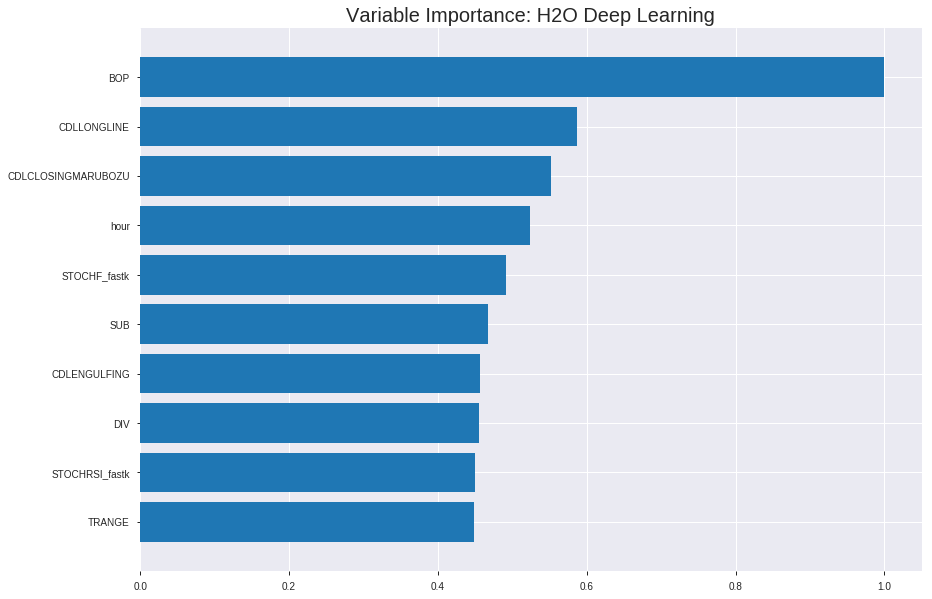

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_135632_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19989733829581033
RMSE: 0.44709880149225445
LogLoss: 0.5764691554900444
Mean Per-Class Error: 0.31512862182816814
AUC: 0.7566093756964231
pr_auc: 0.7338476507822959
Gini: 0.5132187513928461
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33140582546280273: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      411  406   0.4969   (406.0/817.0)
1      116  598   0.1625   (116.0/714.0)
Total  527  1004  0.341    (522.0/1531.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.331406     0.696158  256
max f2                       0.14274      0.83353   350
max f0point5                 0.481352     0.672282  174
max accuracy                 0.481352     0.689092  174
max precision                0.998415     1         0
max recall                   0.102208     1         364
max specificity              0.998415     1         0
max absolute_mcc             0.481352     0.373153  174
max min_per_class_accuracy   0.430508     0.67507   202
max mean_per_class_accuracy  0.449542     0.684871  191

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 42.20 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104507                   0.957628           2.14426   2.14426            1                0.987134   1                           0.987134            0.022409        0.022409                   114.426   114.426
    2        0.0202482                   0.91359            2.14426   2.14426            1                0.936879   1                           0.962817            0.0210084       0.0434174                  114.426   114.426
    3        0.0300457                   0.85291            2.00131   2.09764            0.933333         0.882545   0.978261                    0.936642            0.0196078       0.0630252                  100.131   109.764
    4        0.0404964                   0.823723           2.01024   2.07509            0.9375           0.838973   0.967742                    0.911437            0.0210084       0.0840336                  101.024   107.509
    5        0.0502939                   0.791757           2.14426   2.08856            1                0.806379   0.974026                    0.890971            0.0210084       0.105042                   114.426   108.856
    6        0.100588                    0.689617           1.6987    1.89363            0.792208         0.735204   0.883117                    0.813087            0.0854342       0.190476                   69.8698   89.363
    7        0.150229                    0.629359           1.55177   1.78067            0.723684         0.654549   0.830435                    0.760701            0.0770308       0.267507                   55.1765   78.0666
    8        0.200523                    0.590473           1.44807   1.69725            0.675325         0.607569   0.791531                    0.722293            0.0728291       0.340336                   44.807    69.7246
    9        0.300457                    0.53168            1.24731   1.54759            0.581699         0.56117    0.721739                    0.668702            0.12465         0.464986                   24.7313   54.7595
    10       0.400392                    0.478928           1.28936   1.48314            0.601307         0.505696   0.69168                     0.628017            0.128852        0.593838                   28.9358   48.3141
    11       0.500327                    0.41908            0.910959  1.36885            0.424837         0.450654   0.638381                    0.592591            0.0910364       0.684874                   -8.90408  36.8854
    12       0.600261                    0.360836           1.03709   1.31362            0.48366          0.387999   0.612622                    0.558529            0.103641        0.788515                   3.7092    31.362
    13       0.700196                    0.302405           0.756797  1.23415            0.352941         0.332151   0.57556                     0.52622             0.0756303       0.864146                   -24.3203  23.4148
    14       0.800131                    0.229016           0.700738  1.16753            0.326797         0.266173   0.54449                     0.49374             0.070028        0.934174                   -29.9262  16.7526
    15       0.900065                    0.150917           0.504531  1.09391            0.235294         0.19494    0.51016                     0.460564            0.0504202       0.984594                   -49.5469  9.39138
    16       1                           5.42767e-06        0.154162  1                  0.0718954        0.0744611  0.466362                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.23033306727639544
RMSE: 0.4799302733485307
LogLoss: 0.6540832760441028
Mean Per-Class Error: 0.30688131313131317
AUC: 0.7277251683501684
pr_auc: 0.6264829588225319
Gini: 0.45545033670033686
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.539618358762847: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      123  117  0.4875   (117.0/240.0)
1      25   173  0.1263   (25.0/198.0)
Total  148  290  0.3242   (142.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.539618     0.709016  261
max f2                       0.446342     0.82906   340
max f0point5                 0.56523      0.64239   229
max accuracy                 0.56523      0.680365  229
max precision                0.771896     0.8       14
max recall                   0.300746     1         384
max specificity              0.911683     0.995833  0
max absolute_mcc             0.539618     0.406408  261
max min_per_class_accuracy   0.598757     0.656566  187
max mean_per_class_accuracy  0.539618     0.693119  261

Gains/Lift Table: Avg response rate: 45.21 %, avg score: 57.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.821012           0.884848  0.884848           0.4              0.868189  0.4                         0.868189            0.010101        0.010101                   -11.5152  -11.5152
    2        0.0205479                   0.794771           2.21212   1.47475            1                0.805125  0.666667                    0.840161            0.020202        0.030303                   121.212   47.4747
    3        0.0319635                   0.773109           2.21212   1.7381             1                0.781167  0.785714                    0.819091            0.0252525       0.0555556                  121.212   73.8095
    4        0.0410959                   0.766296           1.10606   1.59764            0.5              0.768542  0.722222                    0.807858            0.010101        0.0656566                  10.6061   59.7643
    5        0.0502283                   0.755014           1.10606   1.50826            0.5              0.760709  0.681818                    0.799286            0.010101        0.0757576                  10.6061   50.8264
    6        0.100457                    0.725831           1.50826   1.50826            0.681818         0.737211  0.681818                    0.768248            0.0757576       0.151515                   50.8264   50.8264
    7        0.150685                    0.696902           1.30716   1.44123            0.590909         0.713716  0.651515                    0.750071            0.0656566       0.217172                   30.7163   44.123
    8        0.200913                    0.677062           1.60882   1.48313            0.727273         0.68557   0.670455                    0.733945            0.0808081       0.29798                    60.8815   48.3127
    9        0.30137                     0.642969           1.30716   1.42447            0.590909         0.657979  0.643939                    0.708623            0.131313        0.429293                   30.7163   42.4472
    10       0.399543                    0.619544           1.23467   1.37784            0.55814          0.629541  0.622857                    0.689192            0.121212        0.550505                   23.4672   37.7835
    11       0.5                         0.59333            1.15634   1.33333            0.522727         0.607202  0.60274                     0.672719            0.116162        0.666667                   15.6336   33.3333
    12       0.600457                    0.560056           1.35744   1.33737            0.613636         0.575958  0.604563                    0.656531            0.136364        0.80303                    35.7438   33.7366
    13       0.69863                     0.52262            0.87456   1.27233            0.395349         0.543106  0.575163                    0.640592            0.0858586       0.888889                   -12.544   27.2331
    14       0.799087                    0.475872           0.603306  1.18823            0.272727         0.496769  0.537143                    0.622511            0.0606061       0.949495                   -39.6694  18.8225
    15       0.899543                    0.416029           0.301653  1.08922            0.136364         0.451199  0.492386                    0.60338             0.030303        0.979798                   -69.8347  8.9217
    16       1                           0.00502115         0.201102  1                  0.0909091        0.325945  0.452055                    0.57551           


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:04:51  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 14:04:53  4 min 11.823 sec  398 obs/sec       0.342913  1             525        0.58388          1.25271             -0.369866      0.573469        0.508163           1.07213          0.476813                         0.72157            2.53203               -1.10198         0.586921          0.51256              2.21212            0.486301
    2019-08-26 14:05:12  4 min 31.349 sec  446 obs/sec       5.50947   16            8435       0.488796         0.669532            0.0399694      0.616846        0.602851           1.87623          0.473547                         0.49716            0.687459              0.00215257       0.55968           0.518169             1.7697             0.53653
    2019-08-26 14:05:32  4 min 50.892 sec  491 obs/sec       11.725    34            17951      0.484421         0.659532            0.0570782      0.640167        0.606193           2.14426          0.428478                         0.500099           0.693304              -0.00968086      0.573611          0.52088              1.7697             0.479452
    2019-08-26 14:05:52  5 min 10.646 sec  506 obs/sec       18.0137   52            27579      0.472455         0.632138            0.103087       0.674976        0.646509           2.14426          0.446114                         0.588256           0.958059              -0.397027        0.606902          0.538831             1.7697             0.46347
    2019-08-26 14:06:11  5 min 29.836 sec  540 obs/sec       25.3246   73            38772      0.472155         0.630052            0.104223       0.689656        0.666789           2.14426          0.39386                          0.590196           1.02535               -0.406258        0.626673          0.520533             0.884848           0.399543
    2019-08-26 14:06:30  5 min 48.906 sec  554 obs/sec       32.1953   93            49291      0.447099         0.576469            0.196775       0.756609        0.733848           2.14426          0.340954                         0.47993            0.654083              0.0701175        0.727725          0.626483             0.884848           0.324201
    2019-08-26 14:06:49  6 min  8.332 sec  558 obs/sec       38.8347   112           59456      0.451906         0.585563            0.179409       0.758116        0.73633            2.14426          0.331809                         0.513121           0.721365              -0.062946        0.629251          0.533013             0.884848           0.39726
    2019-08-26 14:06:51  6 min 10.309 sec  558 obs/sec       38.8347   112           59456      0.447099         0.576469            0.196775       0.756609        0.733848           2.14426          0.340954                         0.47993            0.654083              0.0701175        0.727725          0.626483             0.884848           0.324201

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.0057954194006302456
CDLLONGLINE               0.5870749354362488     0.5870749354362488   0.0034023454704509852
CDLCLOSINGMARUBOZU        0.5517259836196899     0.5517259836196899   0.003197483469301356
hour                      0.5240769982337952     0.5240769982337952   0.0030372460029881995
STOCHF_fastk              0.49165675044059753    0.49165675044059753  0.002849357069954262
---                       ---                    ---                  ---
MA_24_7                   0.1303253173828125     0.1303253173828125   0.0007552898727536457
BBANDS_middleband_8_2_4   0.12969373166561127    0.12969373166561127  0.0007516295686350168
WMA_24                    0.12797726690769196    0.12797726690769196  0.0007416819354764731
BBANDS_middleband_30_7_3  0.12697969377040863    0.12697969377040863  0.0007359005807631138
CDLRISEFALL3METHODS       0.10958430916070938    0.10958430916070938  0.000635087031314638


See the whole table with table.as_data_frame()


('accuracy', 0.7031963470319634)

('F1', 0.6787330316742082)

('auc', 0.719621429778604)

('logloss', 0.7083071440085611)

('mean_per_class_error', 0.29808179820855163)

('rmse', 0.5065174780505038)

('mse', 0.25655995557064265)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


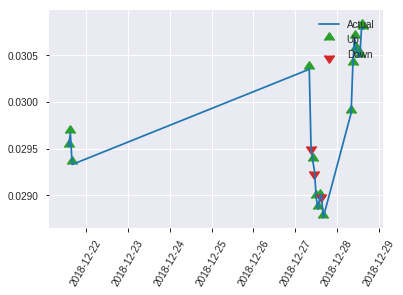


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.25655995557064265
RMSE: 0.5065174780505038
LogLoss: 0.7083071440085611
Mean Per-Class Error: 0.29808179820855163
AUC: 0.719621429778604
pr_auc: 0.613317621767495
Gini: 0.439242859557208
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6218960330014195: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      73   49   0.4016   (49.0/122.0)
1      22   75   0.2268   (22.0/97.0)
Total  95   124  0.3242   (71.0/219.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.621896     0.678733  123
max f2                       0.528169     0.83045   189
max f0point5                 0.660607     0.663984  99
max accuracy                 0.660607     0.703196  99
max precision                0.83446      1         0
max recall                   0.44728      1         207
max specificity              0.83446      1         0
max absolute_mcc             0.657186     0.402141  101
max min_per_class_accuracy   0.654413     0.696721  104
max mean_per_class_accuracy  0.657186     0.701918  101

Gains/Lift Table: Avg response rate: 44.29 %, avg score: 63.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136986                   0.817603           2.25773   2.25773            1                0.829445  1                           0.829445            0.0309278       0.0309278                  125.773   125.773
    2        0.0228311                   0.800236           0         1.35464            0                0.803293  0.6                         0.818984            0               0.0309278                  -100      35.4639
    3        0.0319635                   0.792422           1.12887   1.29013            0.5              0.795326  0.571429                    0.812225            0.0103093       0.0412371                  12.8866   29.0133
    4        0.0410959                   0.789915           2.25773   1.50515            1                0.790988  0.666667                    0.807505            0.0206186       0.0618557                  125.773   50.5155
    5        0.0502283                   0.784281           1.12887   1.43674            0.5              0.78758   0.636364                    0.803883            0.0103093       0.0721649                  12.8866   43.6739
    6        0.100457                    0.757835           1.02624   1.23149            0.454545         0.768736  0.545455                    0.786309            0.0515464       0.123711                   2.62418   23.149
    7        0.150685                    0.743783           1.84724   1.43674            0.818182         0.749278  0.636364                    0.773966            0.0927835       0.216495                   84.7235   43.6739
    8        0.200913                    0.729103           1.43674   1.43674            0.636364         0.736549  0.636364                    0.764611            0.0721649       0.28866                    43.6739   43.6739
    9        0.30137                     0.710932           1.43674   1.43674            0.636364         0.720251  0.636364                    0.749825            0.14433         0.43299                    43.6739   43.6739
    10       0.401826                    0.684127           1.43674   1.43674            0.636364         0.698161  0.636364                    0.736909            0.14433         0.57732                    43.6739   43.6739
    11       0.502283                    0.640691           1.33411   1.41621            0.590909         0.66267   0.627273                    0.722061            0.134021        0.71134                    33.4114   41.6214
    12       0.598174                    0.61538            0.645066  1.29259            0.285714         0.627038  0.572519                    0.706828            0.0618557       0.773196                   -35.4934  29.2595
    13       0.69863                     0.588737           0.718369  1.21003            0.318182         0.602473  0.535948                    0.691823            0.0721649       0.845361                   -28.1631  21.0026
    14       0.799087                    0.556391           0.820993  1.16112            0.363636         0.572836  0.514286                    0.676864            0.0824742       0.927835                   -17.9007  16.1119
    15       0.899543                    0.513745           0.615745  1.10021            0.272727         0.538282  0.48731                     0.661388            0.0618557       0.989691                   -38.4255  10.0215
    16       1                           0.267692           0.102624  1                  0.0454545        0.440559  0.442922                    0.639204          

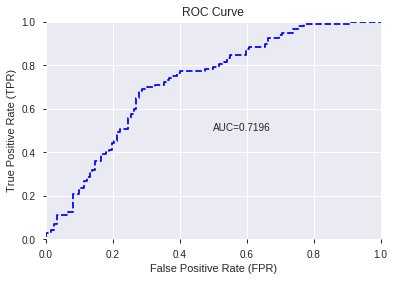

This function is available for GLM models only


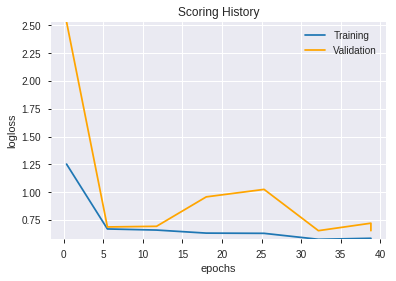

--2019-08-26 14:19:36--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.176.139
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.176.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  16.6MB/s    in 23s     

2019-08-26 14:20:00 (15.4 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: U

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_135632_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_135632_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_bd86',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_142013_model_7  0.751056  0.652596              0.276153  0.458555  0.210273
1               DeepLearning_1_AutoML_20190826_142013  0.749197  0.605142              0.331418  0.453834  0.205965
2  DeepLearning_grid_1_AutoML_20190826_142013_model_8  0.746324  0.581136              0.274041  0.448161  0.200848
3  DeepLearning_grid_1_AutoML_20190826_142013_model_5  0.745986  0.594021              0.313588  0.453055  0.205259
4  DeepLearning_grid_1_AutoML_20190826_142013_model_9  0.737874  0.593706              0.290434  0.452874  0.205095
5  DeepLearning_grid_1_AutoML_20190826_142013_model_6  0.737198  0.590734              0.296645  0.452660  0.204901
6  DeepLearning_grid_1_AutoML_20190826_142013_model_4  0.736606  0.722528              0.302729  0.486091  0.236284
7  DeepLearning_grid_1_AutoML_20190826_142013_model_3  0.718269  0.660192              0.347558  0.470854  0.221704
8  DeepLearning_grid_1_AutoML_20190826_142013_model_2  0.715143  0.815227              0.344516  0.505487  0.255517
9  DeepLearning_grid_1_AutoML_20190826_142013_model_1  0.702467  0.846216              0.375317  0.499312  0.249313

variable  relative_importance  scaled_importance  percentage
0                    BOP             1.000000           1.000000    0.021751
1            CDLBELTHOLD             0.970919           0.970919    0.021118
2              CDLHAMMER             0.966008           0.966008    0.021012
3     CDLCLOSINGMARUBOZU             0.964218           0.964218    0.020973
4            CDLMARUBOZU             0.955805           0.955805    0.020790
5                   hour             0.955095           0.955095    0.020774
6                 Volume             0.954720           0.954720    0.020766
7                BETA_20             0.946455           0.946455    0.020586
8         STOCHRSI_fastk             0.945454           0.945454    0.020565
9         CDLSPINNINGTOP             0.942413           0.942413    0.020498
10          is_month_end             0.936410           0.936410    0.020368
11                MFI_24             0.929487           0.929487    0.020217
12     CDLLONGLEGGEDDOJI             0.928434           0.928434    0.020194
13                TRANGE             0.927514           0.927514    0.020174
14               CDLDOJI             0.926724           0.926724    0.020157
15               weekday             0.926220           0.926220    0.020146
16          STOCHF_fastk             0.924294           0.924294    0.020104
17                 ADX_8             0.923703           0.923703    0.020091
18               ADXR_14             0.923404           0.923404    0.020085
19          HT_TRENDMODE             0.922834           0.922834    0.020073
20                   DIV             0.922227           0.922227    0.020059
21          CDLSHORTLINE             0.922147           0.922147    0.020058
22          CDLENGULFING             0.922013           0.922013    0.020055
23                 DX_14             0.920911           0.920911    0.020031
24             dayofweek             0.918944           0.918944    0.019988
25               BETA_24             0.917235           0.917235    0.019951
26     HT_PHASOR_inphase             0.916926           0.916926    0.019944
27                  DX_8             0.915570           0.915570    0.019915
28             aroonup_8             0.914283           0.914283    0.019887
29                 DX_24             0.913578           0.913578    0.019871
30                 MFI_8             0.911262           0.911262    0.019821
31              WILLR_12             0.909813           0.909813    0.019789
32                   SUB             0.908694           0.908694    0.019765
33            aroonup_12             0.907950           0.907950    0.019749
34                 DX_20             0.907148           0.907148    0.019731
35            aroonup_30             0.906505           0.906505    0.019717
36               WILLR_8             0.906276           0.906276    0.019712
37        CDLRICKSHAWMAN             0.904527           0.904527    0.019674
38          weekday_name             0.902929           0.902929    0.019640
39  HT_PHASOR_quadrature             0.901979           0.901979    0.019619
40                MFI_12             0.901264           0.901264    0.019603
41          aroondown_30             0.897281           0.897281    0.019517
42          STOCHF_fastd             0.893313           0.893313    0.019430
43           HT_DCPERIOD             0.892973           0.892973    0.019423
44           STOCH_slowd             0.892021           0.892021    0.019402
45                 ADOSC             0.890720           0.890720    0.019374
46           CDLLONGLINE             0.886421           0.886421    0.019281
47               BETA_12             0.871748           0.871748    0.018961
48                   OBV             0.865268           0.865268    0.018820
49                SAREXT             0.862911           0.862911    0.018769

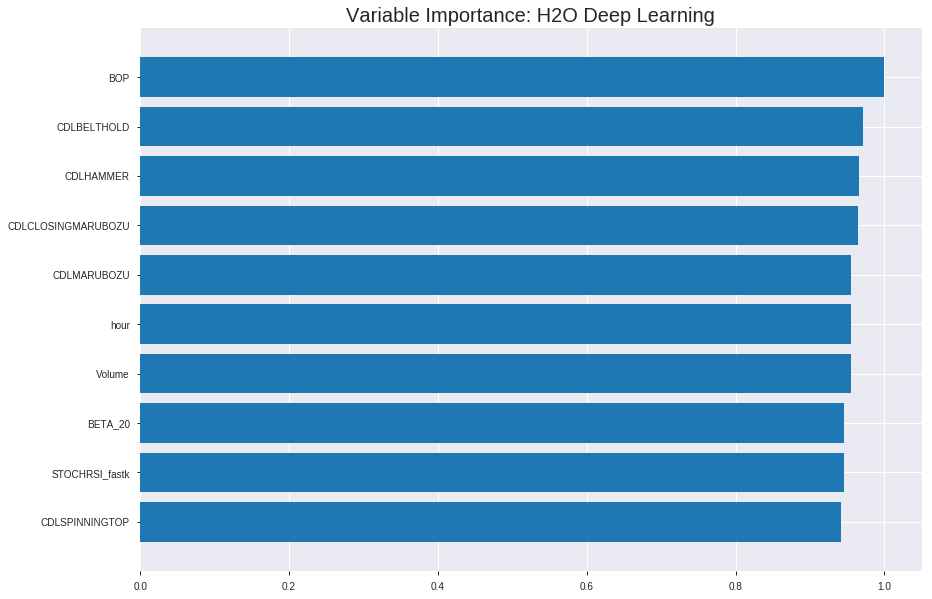

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_142013_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18152234728910444
RMSE: 0.42605439475389106
LogLoss: 0.544427017730923
Mean Per-Class Error: 0.2673390041451097
AUC: 0.808328961939733
pr_auc: 0.7799922226289989
Gini: 0.616657923879466
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27530724429616565: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      459  358  0.4382   (358.0/817.0)
1      91   623  0.1275   (91.0/714.0)
Total  550  981  0.2933   (449.0/1531.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.275307     0.735103  282
max f2                       0.0807356    0.842683  353
max f0point5                 0.51962      0.724638  180
max accuracy                 0.51962      0.732854  180
max precision                0.999869     1         0
max recall                   0.00346779   1         396
max specificity              0.999869     1         0
max absolute_mcc             0.445097     0.46434   212
max min_per_class_accuracy   0.449052     0.730722  210
max mean_per_class_accuracy  0.445097     0.732661  212

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 42.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104507                   0.990939           2.14426   2.14426            1                0.995037    1                           0.995037            0.022409        0.022409                   114.426   114.426
    2        0.0202482                   0.977998           2.00131   2.07509            0.933333         0.985748    0.967742                    0.990542            0.0196078       0.0420168                  100.131   107.509
    3        0.0300457                   0.957919           2.14426   2.09764            1                0.96974     0.978261                    0.983759            0.0210084       0.0630252                  114.426   109.764
    4        0.0404964                   0.942359           2.01024   2.07509            0.9375           0.950702    0.967742                    0.975228            0.0210084       0.0840336                  101.024   107.509
    5        0.0502939                   0.927983           1.85836   2.03287            0.866667         0.935555    0.948052                    0.9675              0.0182073       0.102241                   85.8357   103.287
    6        0.100588                    0.830928           1.86578   1.94933            0.87013          0.875666    0.909091                    0.921583            0.0938375       0.196078                   86.5783   94.9325
    7        0.150229                    0.755331           1.63641   1.84593            0.763158         0.794166    0.86087                     0.87948             0.0812325       0.277311                   63.6407   84.5926
    8        0.200523                    0.696757           1.643     1.79503            0.766234         0.723305    0.837134                    0.840309            0.0826331       0.359944                   64.3003   79.503
    9        0.300457                    0.590323           1.40148   1.66413            0.653595         0.632909    0.776087                    0.771326            0.140056        0.5                        40.1476   66.413
    10       0.400392                    0.519002           1.41549   1.60207            0.660131         0.555495    0.747145                    0.717456            0.141457        0.641457                   41.549    60.2072
    11       0.500327                    0.437722           1.03709   1.48922            0.48366          0.481383    0.694517                    0.670303            0.103641        0.745098                   3.7092    48.9223
    12       0.600261                    0.330478           0.88293   1.38828            0.411765         0.384639    0.647443                    0.622744            0.0882353       0.833333                   -11.707   38.8284
    13       0.700196                    0.205777           0.784826  1.30216            0.366013         0.265013    0.607276                    0.571688            0.0784314       0.911765                   -21.5174  30.2156
    14       0.800131                    0.088402           0.462487  1.19728            0.215686         0.136163    0.558367                    0.517292            0.0462185       0.957983                   -53.7513  19.7283
    15       0.900065                    0.022661           0.308325  1.09858            0.143791         0.0513563   0.512337                    0.465559            0.0308123       0.988796                   -69.1675  9.8582
    16       1                           9.874e-05          0.112118  1                  0.0522876        0.00948688  0.466362    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.22595936986623927
RMSE: 0.4753518379750301
LogLoss: 0.6828735616562797
Mean Per-Class Error: 0.30574494949494957
AUC: 0.7306607744107744
pr_auc: 0.6454696688143612
Gini: 0.46132154882154874
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.11226487609408184: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      103  137  0.5708   (137.0/240.0)
1      17   181  0.0859   (17.0/198.0)
Total  120  318  0.3516   (154.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.112265     0.70155   300
max f2                       0.0227904    0.831191  352
max f0point5                 0.30234      0.649573  230
max accuracy                 0.30234      0.687215  230
max precision                0.986235     1         0
max recall                   0.0019962    1         389
max specificity              0.986235     1         0
max absolute_mcc             0.228312     0.393724  258
max min_per_class_accuracy   0.392362     0.6625    201
max mean_per_class_accuracy  0.30234      0.694255  230

Gains/Lift Table: Avg response rate: 45.21 %, avg score: 37.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.981051           2.21212   2.21212            1                0.983222    1                           0.983222            0.0252525       0.0252525                  121.212   121.212
    2        0.0205479                   0.955313           1.65909   1.96633            0.75             0.967726    0.888889                    0.976335            0.0151515       0.040404                   65.9091   96.633
    3        0.0319635                   0.942548           1.32727   1.7381             0.6              0.949243    0.785714                    0.966659            0.0151515       0.0555556                  32.7273   73.8095
    4        0.0410959                   0.913244           1.65909   1.72054            0.75             0.927391    0.777778                    0.957933            0.0151515       0.0707071                  65.9091   72.0539
    5        0.0502283                   0.890908           1.10606   1.60882            0.5              0.903137    0.727273                    0.94797             0.010101        0.0808081                  10.6061   60.8815
    6        0.100457                    0.779605           1.50826   1.55854            0.681818         0.829624    0.704545                    0.888797            0.0757576       0.156566                   50.8264   55.854
    7        0.150685                    0.702334           1.30716   1.47475            0.590909         0.741916    0.666667                    0.839837            0.0656566       0.222222                   30.7163   47.4747
    8        0.200913                    0.651979           1.50826   1.48313            0.681818         0.677036    0.670455                    0.799136            0.0757576       0.29798                    50.8264   48.3127
    9        0.30137                     0.540425           1.40771   1.45799            0.636364         0.587361    0.659091                    0.728545            0.141414        0.439394                   40.7713   45.7989
    10       0.399543                    0.465911           1.33756   1.4284             0.604651         0.505814    0.645714                    0.673816            0.131313        0.570707                   33.7562   42.8398
    11       0.5                         0.366906           1.20661   1.38384            0.545455         0.422636    0.625571                    0.623351            0.121212        0.691919                   20.6612   38.3838
    12       0.600457                    0.250258           1.05579   1.32895            0.477273         0.310009    0.60076                     0.570929            0.106061        0.79798                    5.57851   32.8955
    13       0.69863                     0.131302           0.87456   1.2651             0.395349         0.19119     0.571895                    0.517567            0.0858586       0.883838                   -12.544   26.5102
    14       0.799087                    0.0558532          0.603306  1.1819             0.272727         0.0913341   0.534286                    0.463983            0.0606061       0.944444                   -39.6694  18.1905
    15       0.899543                    0.0123661          0.402204  1.09483            0.181818         0.0286434   0.494924                    0.415367            0.040404        0.984848                   -59.7796  9.48316
    16       1                           8.28484e-05        0.150826  1                  0.0681818        0.00416839  0.452055   


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:24:04  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 14:24:09  5.368 sec   231 obs/sec       0.688439  1             1054       0.528309         0.891609            -0.121519      0.664676        0.627515           1.87623          0.472894                         0.536024           0.865375              -0.159954        0.633091          0.562956             2.21212            0.46347
    2019-08-26 14:24:17  14.062 sec  435 obs/sec       3.55519   5             5443       0.426054         0.544427            0.270609       0.808329        0.779992           2.14426          0.293272                         0.475352           0.682874              0.0877746        0.730661          0.64547              2.21212            0.351598
    2019-08-26 14:24:26  22.920 sec  528 obs/sec       7.10712   10            10881      0.382102         0.443389            0.413337       0.874543        0.854447           2.14426          0.21228                          0.489923           0.711479              0.0309902        0.676673          0.61032              1.7697             0.383562
    2019-08-26 14:24:35  31.762 sec  572 obs/sec       10.6669   15            16331      0.348204         0.376547            0.512812       0.912051        0.868183           2.14426          0.172436                         0.495969           0.772692              0.00692589       0.697422          0.624728             1.7697             0.40411
    2019-08-26 14:24:45  41.789 sec  603 obs/sec       14.9001   21            22812      0.367678         0.418761            0.456793       0.951971        0.922994           2.14426          0.123449                         0.552767           1.17916               -0.233548        0.662479          0.596697             2.21212            0.401826
    2019-08-26 14:24:53  50.203 sec  619 obs/sec       18.42     26            28201      0.249246         0.211006            0.750376       0.974214        0.867441           2.14426          0.0770738                        0.526965           1.08735               -0.121078        0.68326           0.595995             1.7697             0.401826
    2019-08-26 14:25:02  58.685 sec  631 obs/sec       21.9373   31            33586      0.228314         0.170758            0.790544       0.982664        0.903354           2.14426          0.0725016                        0.544092           1.26342               -0.195133        0.658165          0.588749             1.7697             0.456621
    2019-08-26 14:25:03  59.454 sec  630 obs/sec       21.9373   31            33586      0.426054         0.544427            0.270609       0.808329        0.779992           2.14426          0.293272                         0.475352           0.682874              0.0877746        0.730661          0.64547              2.21212            0.351598

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.021750975759585355
CDLBELTHOLD         0.9709194302558899     0.9709194302558899   0.021118444992006286
CDLHAMMER           0.9660077691078186     0.9660077691078186   0.02101161156943529
CDLCLOSINGMARUBOZU  0.9642179012298584     0.9642179012298584   0.020972680196608917
CDLMARUBOZU         0.9558051824569702     0.9558051824569702   0.020789695354507618
---                 ---                    ---                  ---
ADOSC               0.8907203078269958     0.8907203078269958   0.019374035824115392
CDLLONGLINE         0.8864206671714783     0.8864206671714783   0.0192805144444423
BETA_12             0.8717475533485413     0.8717475533485413   0.01896135990136196
OBV                 0.8652681112289429     0.8652681112289429   0.018820425712882942
SAREXT              0.8629107475280762     0.8629107475280762   0.018769150752168864


See the whole table with table.as_data_frame()


('accuracy', 0.7214611872146118)

('F1', 0.7174887892376681)

('auc', 0.7510562785195201)

('logloss', 0.6525963234262588)

('mean_per_class_error', 0.2761534561433159)

('rmse', 0.4585553553865317)

('mse', 0.2102730139536684)

deeplearning prediction progress: |███████████████████████████████████████| 100%


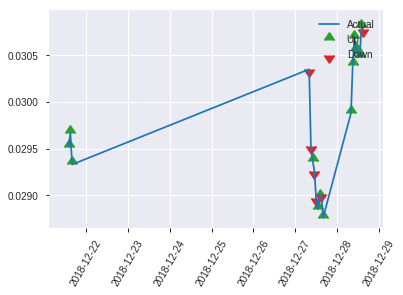


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2102730139536684
RMSE: 0.4585553553865317
LogLoss: 0.6525963234262588
Mean Per-Class Error: 0.2761534561433159
AUC: 0.7510562785195201
pr_auc: 0.6566540970471958
Gini: 0.5021125570390401
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35096472594815686: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      76   46   0.377    (46.0/122.0)
1      17   80   0.1753   (17.0/97.0)
Total  93   126  0.2877   (63.0/219.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.350965     0.717489  125
max f2                       0.0457366    0.824561  181
max f0point5                 0.439583     0.682261  103
max accuracy                 0.439583     0.721461  103
max precision                0.997621     1         0
max recall                   0.00123775   1         210
max specificity              0.997621     1         0
max absolute_mcc             0.350965     0.449904  125
max min_per_class_accuracy   0.439583     0.721311  103
max mean_per_class_accuracy  0.350965     0.723847  125

Gains/Lift Table: Avg response rate: 44.29 %, avg score: 42.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136986                   0.982709           1.50515   1.50515            0.666667         0.988831   0.666667                    0.988831            0.0206186       0.0206186                  50.5155   50.5155
    2        0.0228311                   0.960978           2.25773   1.80619            1                0.971914   0.8                         0.982064            0.0206186       0.0412371                  125.773   80.6186
    3        0.0319635                   0.933006           1.12887   1.61267            0.5              0.946724   0.714286                    0.971967            0.0103093       0.0515464                  12.8866   61.2666
    4        0.0410959                   0.923531           2.25773   1.75601            1                0.930266   0.777778                    0.9627              0.0206186       0.0721649                  125.773   75.6014
    5        0.0502283                   0.916019           2.25773   1.84724            1                0.919436   0.818182                    0.954834            0.0206186       0.0927835                  125.773   84.7235
    6        0.100457                    0.855373           1.84724   1.84724            0.818182         0.889387   0.818182                    0.922111            0.0927835       0.185567                   84.7235   84.7235
    7        0.150685                    0.799852           1.02624   1.57357            0.454545         0.824015   0.69697                     0.889412            0.0515464       0.237113                   2.62418   57.3571
    8        0.200913                    0.728786           1.23149   1.48805            0.545455         0.755963   0.659091                    0.85605             0.0618557       0.298969                   23.149    48.8051
    9        0.30137                     0.612722           1.53936   1.50515            0.681818         0.679394   0.666667                    0.797164            0.154639        0.453608                   53.9363   50.5155
    10       0.401826                    0.488706           1.33411   1.46239            0.590909         0.564667   0.647727                    0.73904             0.134021        0.587629                   33.4114   46.2395
    11       0.502283                    0.423983           1.53936   1.47779            0.681818         0.453348   0.654545                    0.681902            0.154639        0.742268                   53.9363   47.7788
    12       0.598174                    0.336141           0.860088  1.37877            0.380952         0.381407   0.610687                    0.633731            0.0824742       0.824742                   -13.9912  37.8768
    13       0.69863                     0.224535           0.615745  1.26905            0.272727         0.272785   0.562092                    0.58183             0.0618557       0.886598                   -38.4255  26.9052
    14       0.799087                    0.0831743          0.410497  1.16112            0.181818         0.137729   0.514286                    0.526               0.0412371       0.927835                   -58.9503  16.1119
    15       0.899543                    0.0131268          0.615745  1.10021            0.272727         0.037431   0.48731                     0.471439            0.0618557       0.989691                   -38.4255  10.0215
    16       1                           0.000193471        0.102624  1                  0.0454545        0.0042267  0.442922                   

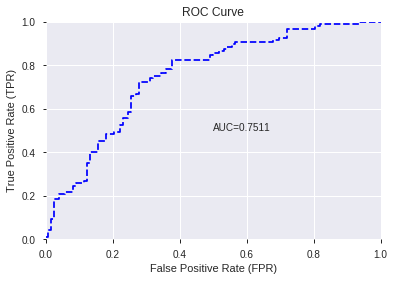

This function is available for GLM models only


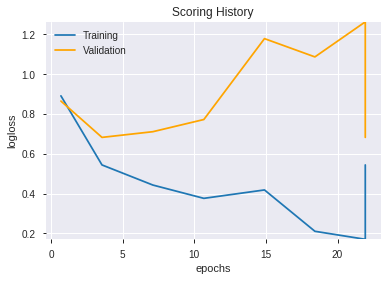

--2019-08-26 14:26:41--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.229.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.229.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_142013_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_142013_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_bd86',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLBELTHOLD',
 'CDLHAMMER',
 'CDLCLOSINGMARUBOZU',
 'CDLMARUBOZU',
 'hour',
 'Volume',
 'BETA_20',
 'STOCHRSI_fastk',
 'CDLSPINNINGTOP',
 'is_month_end',
 'MFI_24',
 'CDLLONGLEGGEDDOJI',
 'TRANGE',
 'CDLDOJI',
 'weekday',
 'STOCHF_fastk',
 'ADX_8',
 'ADXR_14',
 'HT_TRENDMODE',
 'DIV',
 'CDLSHORTLINE',
 'CDLENGULFING',
 'DX_14',
 'dayofweek',
 'BETA_24',
 'HT_PHASOR_inphase',
 'DX_8',
 'aroonup_8',
 'DX_24',
 'MFI_8',
 'WILLR_12',
 'SUB',
 'aroonup_12',
 'DX_20',
 'aroonup_30',
 'WILLR_8',
 'CDLRICKSHAWMAN',
 'weekday_name',
 'HT_PHASOR_quadrature',
 'MFI_12',
 'aroondown_30',
 'STOCHF_fastd',
 'HT_DCPERIOD',
 'STOCH_slowd',
 'ADOSC',
 'CDLLONGLINE',
 'BETA_12',
 'OBV',
 'SAREXT']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_142651_model_1  0.747676  0.58795              0.299561  0.449799  0.202319

variable  relative_importance  scaled_importance  percentage
0                    BOP             0.424380           1.000000    0.120260
1           STOCHF_fastk             0.209467           0.493582    0.059358
2                   hour             0.198474           0.467680    0.056243
3           STOCHF_fastd             0.190051           0.447831    0.053856
4     CDLCLOSINGMARUBOZU             0.180051           0.424269    0.051023
5                    SUB             0.162781           0.383574    0.046129
6            STOCH_slowd             0.159835           0.376633    0.045294
7             aroonup_30             0.158400           0.373251    0.044887
8                BETA_20             0.154560           0.364201    0.043799
9              CDLHAMMER             0.120997           0.285115    0.034288
10                 ADX_8             0.115393           0.271910    0.032700
11               WILLR_8             0.108389           0.255404    0.030715
12               BETA_12             0.097354           0.229402    0.027588
13                 ADOSC             0.088106           0.207610    0.024967
14              WILLR_12             0.085456           0.201366    0.024216
15          CDLENGULFING             0.083507           0.196774    0.023664
16     HT_PHASOR_inphase             0.079723           0.187858    0.022592
17        STOCHRSI_fastk             0.074977           0.176673    0.021247
18          HT_TRENDMODE             0.068024           0.160289    0.019276
19                TRANGE             0.065715           0.154850    0.018622
20           HT_DCPERIOD             0.055099           0.129835    0.015614
21                   DIV             0.051830           0.122131    0.014688
22        CDLRICKSHAWMAN             0.051220           0.120694    0.014515
23                MFI_12             0.049897           0.117576    0.014140
24                 DX_24             0.049559           0.116780    0.014044
25                MFI_24             0.046690           0.110019    0.013231
26        CDLSPINNINGTOP             0.044532           0.104934    0.012619
27  HT_PHASOR_quadrature             0.041653           0.098151    0.011804
28          aroondown_30             0.037076           0.087366    0.010507
29           CDLLONGLINE             0.032014           0.075437    0.009072
30           CDLMARUBOZU             0.030446           0.071741    0.008628
31                 DX_14             0.028815           0.067900    0.008166
32          weekday_name             0.024662           0.058113    0.006989
33                 DX_20             0.018814           0.044334    0.005332
34     CDLLONGLEGGEDDOJI             0.017134           0.040374    0.004855
35               CDLDOJI             0.017122           0.040346    0.004852
36          is_month_end             0.017090           0.040271    0.004843
37               BETA_24             0.013644           0.032151    0.003866
38                  DX_8             0.013335           0.031423    0.003779
39            aroonup_12             0.012551           0.029576    0.003557
40                 MFI_8             0.010518           0.024785    0.002981
41             aroonup_8             0.009552           0.022509    0.002707
42               ADXR_14             0.007425           0.017496    0.002104
43             dayofweek             0.006660           0.015693    0.001887
44               weekday             0.006600           0.015551    0.001870
45                   OBV             0.005408           0.012742    0.001532
46                Volume             0.002774           0.006536    0.000786
47          CDLSHORTLINE             0.000514           0.001210    0.000146
48                SAREXT             0.000354           0.000834    0.000100
49           CDLBELTHOLD             0.000218           0.000514    0.000062

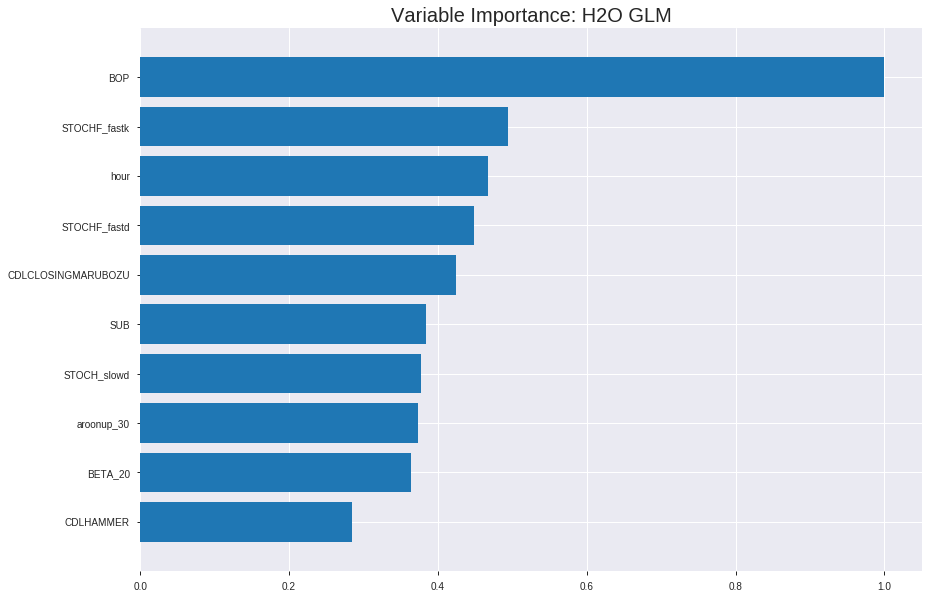

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_142651_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19958682175871695
RMSE: 0.44675140935280433
LogLoss: 0.5829036563112229
Null degrees of freedom: 1530
Residual degrees of freedom: 1480
Null deviance: 2115.4819722816574
Residual deviance: 1784.8509956249645
AIC: 1886.8509956249645
AUC: 0.7574750830564785
pr_auc: 0.7169141419369784
Gini: 0.514950166112957
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34235592202165593: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      375  442   0.541    (442.0/817.0)
1      80   634   0.112    (80.0/714.0)
Total  455  1076  0.341    (522.0/1531.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.342356     0.70838   267
max f2                       0.211999     0.823992  335
max f0point5                 0.502888     0.675523  181
max accuracy                 0.477881     0.698236  195
max precision                0.93796      1         0
max recall                   0.0881759    1         385
max specificity              0.93796      1         0
max absolute_mcc             0.477881     0.396899  195
max min_per_class_accuracy   0.483453     0.694678  192
max mean_per_class_accuracy  0.477881     0.698895  195

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 46.64 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104507                   0.870697           2.14426   2.14426            1                0.89914   1                           0.89914             0.022409        0.022409                   114.426   114.426
    2        0.0202482                   0.854366           2.00131   2.07509            0.933333         0.863036  0.967742                    0.88167             0.0196078       0.0420168                  100.131   107.509
    3        0.0300457                   0.821481           1.71541   1.9578             0.8              0.835612  0.913043                    0.866651            0.0168067       0.0588235                  71.5406   95.7801
    4        0.0404964                   0.79005            1.87623   1.93675            0.875            0.807206  0.903226                    0.85131             0.0196078       0.0784314                  87.6225   93.6749
    5        0.0502939                   0.775385           1.28655   1.81009            0.6              0.782656  0.844156                    0.837936            0.012605        0.0910364                  28.6555   81.0088
    6        0.100588                    0.724561           1.643     1.72655            0.766234         0.747013  0.805195                    0.792475            0.0826331       0.173669                   64.3003   72.6545
    7        0.150229                    0.683933           1.66462   1.70608            0.776316         0.70418   0.795652                    0.763299            0.0826331       0.256303                   66.4621   70.6083
    8        0.200523                    0.655884           1.36453   1.62042            0.636364         0.670662  0.7557                      0.740064            0.0686275       0.32493                    36.4528   62.0416
    9        0.300457                    0.595317           1.38746   1.54293            0.647059         0.624237  0.719565                    0.701539            0.138655        0.463585                   38.7461   54.2933
    10       0.400392                    0.540508           1.3314    1.49014            0.620915         0.568423  0.694943                    0.668314            0.133053        0.596639                   33.1402   49.0137
    11       0.500327                    0.474231           1.14921   1.42204            0.535948         0.507962  0.663185                    0.636286            0.114846        0.711485                   14.921    42.204
    12       0.600261                    0.412059           0.910959  1.33695            0.424837         0.440601  0.623504                    0.603707            0.0910364       0.802521                   -8.90408  33.6953
    13       0.700196                    0.344168           0.826871  1.26415            0.385621         0.37567   0.589552                    0.571161            0.0826331       0.885154                   -17.3129  26.4152
    14       0.800131                    0.269748           0.518546  1.17103            0.24183          0.306958  0.546122                    0.538163            0.0518207       0.936975                   -48.1454  17.1027
    15       0.900065                    0.188787           0.378398  1.08302            0.176471         0.229891  0.50508                     0.503935            0.0378151       0.97479                    -62.1602  8.30213
    16       1                           0.0179714          0.252266  1                  0.117647         0.127959  0.466362                    0.466362          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20347182156395627
RMSE: 0.45107850931290916
LogLoss: 0.5915054822705857
Null degrees of freedom: 437
Residual degrees of freedom: 387
Null deviance: 603.5241039768543
Residual deviance: 518.1588024690332
AIC: 620.1588024690332
AUC: 0.7467908249158249
pr_auc: 0.6598309622320359
Gini: 0.49358164983164987
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3284340046074769: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      109  131  0.5458   (131.0/240.0)
1      17   181  0.0859   (17.0/198.0)
Total  126  312  0.3379   (148.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.328434     0.709804  282
max f2                       0.277446     0.831866  313
max f0point5                 0.446877     0.660813  201
max accuracy                 0.446877     0.696347  201
max precision                0.860499     1         0
max recall                   0.074285     1         392
max specificity              0.860499     1         0
max absolute_mcc             0.346178     0.404995  272
max min_per_class_accuracy   0.460292     0.686869  192
max mean_per_class_accuracy  0.442762     0.699053  203

Gains/Lift Table: Avg response rate: 45.21 %, avg score: 44.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.830464           1.7697    1.7697             0.8              0.847443  0.8                         0.847443            0.020202        0.020202                   76.9697   76.9697
    2        0.0205479                   0.796244           1.65909   1.72054            0.75             0.816915  0.777778                    0.833875            0.0151515       0.0353535                  65.9091   72.0539
    3        0.0319635                   0.775207           0.884848  1.42208            0.4              0.783848  0.642857                    0.816008            0.010101        0.0454545                  -11.5152  42.2078
    4        0.0410959                   0.757182           2.21212   1.59764            1                0.759772  0.722222                    0.803511            0.020202        0.0656566                  121.212   59.7643
    5        0.0502283                   0.739182           1.65909   1.60882            0.75             0.751201  0.727273                    0.794               0.0151515       0.0808081                  65.9091   60.8815
    6        0.100457                    0.681414           1.60882   1.60882            0.727273         0.713519  0.727273                    0.75376             0.0808081       0.161616                   60.8815   60.8815
    7        0.150685                    0.646051           1.80992   1.67585            0.818182         0.662422  0.757576                    0.723314            0.0909091       0.252525                   80.9917   67.5849
    8        0.200913                    0.615171           1.20661   1.55854            0.545455         0.631434  0.704545                    0.700344            0.0606061       0.313131                   20.6612   55.854
    9        0.30137                     0.566988           1.40771   1.50826            0.636364         0.590624  0.681818                    0.66377             0.141414        0.454545                   40.7713   50.8264
    10       0.399543                    0.509856           1.13178   1.41576            0.511628         0.538992  0.64                        0.633111            0.111111        0.565657                   13.1783   41.5758
    11       0.5                         0.449511           1.45799   1.42424            0.659091         0.479938  0.643836                    0.602336            0.146465        0.712121                   45.7989   42.4242
    12       0.600457                    0.396526           0.955234  1.34578            0.431818         0.422644  0.608365                    0.572274            0.0959596       0.808081                   -4.47658  34.5777
    13       0.69863                     0.337601           0.87456   1.27956            0.395349         0.365288  0.578431                    0.543187            0.0858586       0.893939                   -12.544   27.956
    14       0.799087                    0.262503           0.603306  1.19455            0.272727         0.302184  0.54                        0.51289             0.0606061       0.954545                   -39.6694  19.4545
    15       0.899543                    0.160311           0.201102  1.0836             0.0909091        0.215249  0.489848                    0.479651            0.020202        0.974747                   -79.8898  8.36025
    16       1                           0.00017847         0.251377  1                  0.113636         0.1018    0.452055                    0.441693           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 14:26:51  0.000 sec   2            18        51            1.36497           1.35871
    2019-08-26 14:26:51  0.023 sec   4            11        51            1.3562            1.34878
    2019-08-26 14:26:51  0.042 sec   6            6.9       51            1.34387           1.33499
    2019-08-26 14:26:51  0.071 sec   8            4.3       51            1.32755           1.31702
    2019-08-26 14:26:51  0.103 sec   10           2.7       51            1.30745           1.29544
    2019-08-26 14:26:51  0.136 sec   12           1.7       51            1.28473           1.27182
    2019-08-26 14:26:52  0.168 sec   14           1         51            1.26123           1.24843
    2019-08-26 14:26:52  0.185 sec   16           0.64      51            1.23898           1.22752
    2019-08-26 14:26:52  0.204 sec   18           0.4       51            1.21948           1.21063
    2019-08-26 14:26:52  0.230 sec   20           0.25      51            1.20333           1.19824
    2019-08-26 14:26:52  0.253 sec   22           0.15      51            1.19037           1.19003
    2019-08-26 14:26:52  0.271 sec   24           0.095     51            1.18009           1.18529
    2019-08-26 14:26:52  0.288 sec   26           0.059     51            1.17202           1.1832
    2019-08-26 14:26:52  0.302 sec   28           0.037     51            1.16581           1.18301
    2019-08-26 14:26:52  0.324 sec   30           0.023     51            1.16116           1.18389
    2019-08-26 14:26:52  0.345 sec   32           0.014     51            1.15772           1.18535
    2019-08-26 14:26:52  0.361 sec   34           0.0088    51            1.15508           1.18786
    2019-08-26 14:26:52  0.382 sec   36           0.0055    51            1.15286           1.19432
    2019-08-26 14:26:52  0.403 sec   38           0.0034    51            1.15079           1.21278

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6940639269406392)

('F1', 0.7083333333333333)

('auc', 0.747676187257056)

('logloss', 0.587949607497291)

('mean_per_class_error', 0.29453270238296436)

('rmse', 0.4497993492350116)

('mse', 0.2023194545722399)

glm prediction progress: |████████████████████████████████████████████████| 100%


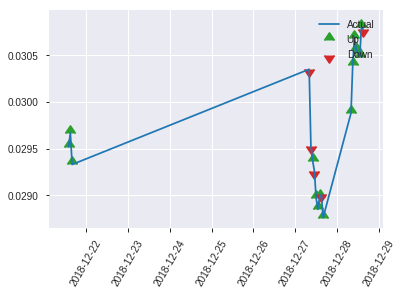


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2023194545722399
RMSE: 0.4497993492350116
LogLoss: 0.587949607497291
Null degrees of freedom: 218
Residual degrees of freedom: 168
Null deviance: 301.2230274583454
Residual deviance: 257.5219280838135
AIC: 359.5219280838135
AUC: 0.747676187257056
pr_auc: 0.6759764659495366
Gini: 0.49535237451411196
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3853214333144795: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      64   58   0.4754   (58.0/122.0)
1      12   85   0.1237   (12.0/97.0)
Total  76   143  0.3196   (70.0/219.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.385321     0.708333  142
max f2                       0.228347     0.824653  187
max f0point5                 0.450543     0.649241  123
max accuracy                 0.450543     0.694064  123
max precision                0.868952     1         0
max recall                   0.143098     1         203
max specificity              0.868952     1         0
max absolute_mcc             0.413292     0.41979   134
max min_per_class_accuracy   0.482151     0.672131  105
max mean_per_class_accuracy  0.413292     0.705467  134

Gains/Lift Table: Avg response rate: 44.29 %, avg score: 45.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136986                   0.844991           1.50515   1.50515            0.666667         0.854892  0.666667                    0.854892            0.0206186       0.0206186                  50.5155   50.5155
    2        0.0228311                   0.800906           2.25773   1.80619            1                0.824493  0.8                         0.842732            0.0206186       0.0412371                  125.773   80.6186
    3        0.0319635                   0.783671           2.25773   1.9352             1                0.79021   0.857143                    0.827726            0.0206186       0.0618557                  125.773   93.5199
    4        0.0410959                   0.761306           2.25773   2.00687            1                0.773965  0.888889                    0.815779            0.0206186       0.0824742                  125.773   100.687
    5        0.0502283                   0.748876           2.25773   2.05248            1                0.754126  0.909091                    0.804569            0.0206186       0.103093                   125.773   105.248
    6        0.100457                    0.689964           1.43674   1.74461            0.636364         0.718516  0.772727                    0.761543            0.0721649       0.175258                   43.6739   74.4611
    7        0.150685                    0.668918           1.43674   1.64199            0.636364         0.676337  0.727273                    0.733141            0.0721649       0.247423                   43.6739   64.1987
    8        0.200913                    0.633987           1.84724   1.6933             0.818182         0.653002  0.75                        0.713106            0.0927835       0.340206                   84.7235   69.3299
    9        0.30137                     0.577999           1.23149   1.53936            0.545455         0.605373  0.681818                    0.677195            0.123711        0.463918                   23.149    53.9363
    10       0.401826                    0.520232           1.23149   1.46239            0.545455         0.549646  0.647727                    0.645308            0.123711        0.587629                   23.149    46.2395
    11       0.502283                    0.47915            1.02624   1.37516            0.454545         0.494471  0.609091                    0.61514             0.103093        0.690722                   2.62418   37.5164
    12       0.598174                    0.422267           1.29013   1.36153            0.571429         0.452662  0.603053                    0.589094            0.123711        0.814433                   29.0133   36.1533
    13       0.69863                     0.355694           0.615745  1.2543             0.272727         0.387262  0.555556                    0.560073            0.0618557       0.876289                   -38.4255  25.4296
    14       0.799087                    0.284332           0.307873  1.13532            0.136364         0.320072  0.502857                    0.529901            0.0309278       0.907216                   -69.2127  13.5317
    15       0.899543                    0.190684           0.820993  1.10021            0.363636         0.234852  0.48731                     0.496951            0.0824742       0.989691                   -17.9007  10.0215
    16       1                           0.028362           0.102624  1                  0.0454545        0.121323  0.442922                    0.459217         

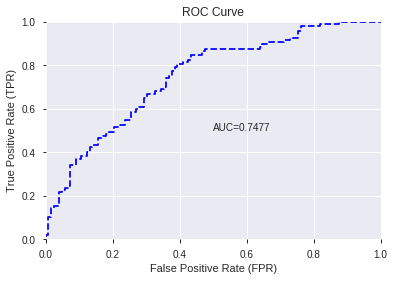

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


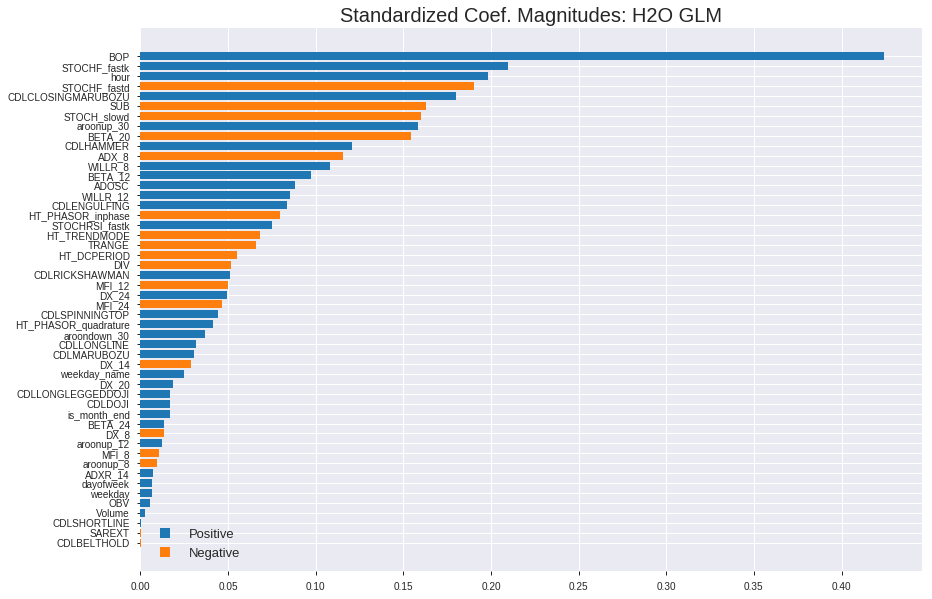

'log_likelihood'
--2019-08-26 14:26:57--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.227.128
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.227.128|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_142651_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_142651_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_bd86',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'STOCHF_fastk',
 'hour',
 'STOCHF_fastd',
 'CDLCLOSINGMARUBOZU',
 'SUB',
 'STOCH_slowd',
 'aroonup_30',
 'BETA_20',
 'CDLHAMMER',
 'ADX_8',
 'WILLR_8',
 'BETA_12',
 'ADOSC',
 'WILLR_12',
 'CDLENGULFING',
 'HT_PHASOR_inphase',
 'STOCHRSI_fastk',
 'HT_TRENDMODE',
 'TRANGE',
 'HT_DCPERIOD',
 'DIV',
 'CDLRICKSHAWMAN',
 'MFI_12',
 'DX_24',
 'MFI_24',
 'CDLSPINNINGTOP',
 'HT_PHASOR_quadrature',
 'aroondown_30',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'DX_14',
 'weekday_name',
 'DX_20',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI',
 'is_month_end',
 'BETA_24',
 'DX_8',
 'aroonup_12',
 'MFI_8',
 'aroonup_8',
 'ADXR_14',
 'dayofweek',
 'weekday',
 'OBV',
 'Volume',
 'CDLSHORTLINE',
 'SAREXT',
 'CDLBELTHOLD']

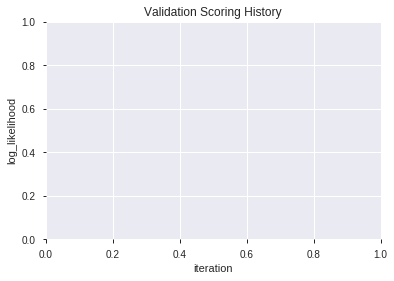

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190826_142708  0.764239  0.570837              0.283167  0.441691  0.195091
1  XGBoost_grid_1_AutoML_20190826_142708_model_5  0.752915  0.585853              0.282364  0.448248  0.200926
2  XGBoost_grid_1_AutoML_20190826_142708_model_3  0.749113  0.584113              0.295589  0.448310  0.200982
3  XGBoost_grid_1_AutoML_20190826_142708_model_6  0.747761  0.582911              0.284350  0.447588  0.200335
4  XGBoost_grid_1_AutoML_20190826_142708_model_2  0.747676  0.586970              0.302603  0.449178  0.201761
5  XGBoost_grid_1_AutoML_20190826_142708_model_7  0.735170  0.594088              0.317940  0.454226  0.206321
6  XGBoost_grid_1_AutoML_20190826_142708_model_1  0.731198  0.595128              0.320982  0.454515  0.206584
7  XGBoost_grid_1_AutoML_20190826_142708_model_4  0.730691  0.597637              0.332221  0.455263  0.207264
8               XGBoost_1_AutoML_20190826_142708  0.723678  0.601998              0.322165  0.458607  0.210320
9               XGBoost_2_AutoML_20190826_142708  0.722748  0.602398              0.304842  0.458102  0.209858

variable  relative_importance  scaled_importance  percentage
0                    BOP          1431.951294           1.000000    0.179635
1           STOCHF_fastk           614.612061           0.429213    0.077102
2                    DIV           453.356445           0.316600    0.056872
3                   hour           438.367249           0.306133    0.054992
4         STOCHRSI_fastk           392.218536           0.273905    0.049203
5                    SUB           277.170746           0.193562    0.034770
6   HT_PHASOR_quadrature           252.132263           0.176076    0.031629
7                BETA_20           244.623215           0.170832    0.030687
8                  ADX_8           239.072357           0.166956    0.029991
9            STOCH_slowd           226.509949           0.158183    0.028415
10          STOCHF_fastd           223.752319           0.156257    0.028069
11                 ADOSC           183.851746           0.128392    0.023064
12                Volume           178.619339           0.124738    0.022407
13                MFI_12           175.848114           0.122803    0.022060
14               WILLR_8           166.482254           0.116263    0.020885
15                 DX_14           148.550217           0.103740    0.018635
16             aroonup_8           147.876190           0.103269    0.018551
17               BETA_24           146.001892           0.101960    0.018316
18                TRANGE           145.639648           0.101707    0.018270
19                SAREXT           132.671310           0.092651    0.016643
20               ADXR_14           130.632858           0.091227    0.016388
21     HT_PHASOR_inphase           127.329681           0.088920    0.015973
22            aroonup_30           124.245956           0.086767    0.015586
23               BETA_12           115.982758           0.080996    0.014550
24              WILLR_12           113.058830           0.078954    0.014183
25           HT_DCPERIOD           112.819725           0.078787    0.014153
26                   OBV           109.374474           0.076381    0.013721
27                  DX_8           106.604836           0.074447    0.013373
28                 MFI_8            92.728546           0.064757    0.011633
29                MFI_24            85.463081           0.059683    0.010721
30                 DX_24            84.453064           0.058978    0.010594
31          aroondown_30            79.870804           0.055778    0.010020
32                 DX_20            68.954079           0.048154    0.008650
33            aroonup_12            63.786034           0.044545    0.008002
34           CDLLONGLINE            63.285164           0.044195    0.007939
35    CDLCLOSINGMARUBOZU            61.692371           0.043083    0.007739
36             dayofweek            36.227398           0.025299    0.004545
37          weekday_name            35.637920           0.024888    0.004471
38               weekday            32.563423           0.022741    0.004085
39               CDLDOJI            28.667076           0.020020    0.003596
40             CDLHAMMER            28.557457           0.019943    0.003582
41        CDLSPINNINGTOP            21.926689           0.015312    0.002751
42          CDLSHORTLINE            17.457455           0.012191    0.002190
43          HT_TRENDMODE             5.807414           0.004056    0.000729
44     CDLLONGLEGGEDDOJI             5.029599           0.003512    0.000631

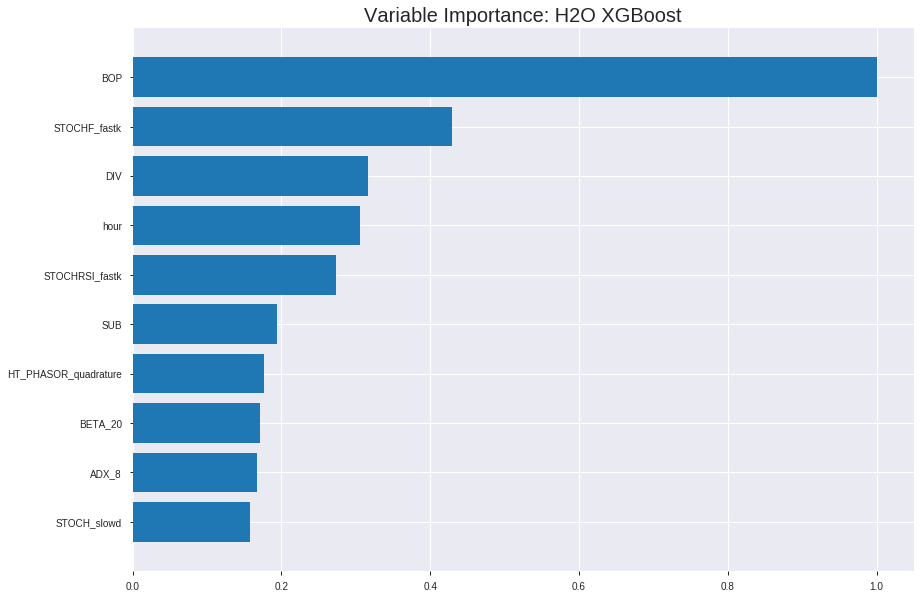

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190826_142708


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.12846981595204698
RMSE: 0.35842686276567914
LogLoss: 0.4219011121646133
Mean Per-Class Error: 0.14073058844100683
AUC: 0.9377324981400149
pr_auc: 0.9316813081472977
Gini: 0.8754649962800298
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4647222995758057: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      666  151  0.1848   (151.0/817.0)
1      69   645  0.0966   (69.0/714.0)
Total  735  796  0.1437   (220.0/1531.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.464722     0.854305  206
max f2                       0.358859     0.899844  255
max f0point5                 0.614665     0.87325   137
max accuracy                 0.488404     0.857609  195
max precision                0.916871     1         0
max recall                   0.177976     1         340
max specificity              0.916871     1         0
max absolute_mcc             0.464722     0.717481  206
max min_per_class_accuracy   0.50403      0.851541  188
max mean_per_class_accuracy  0.464722     0.859269  206

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 46.76 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104507                   0.890244           2.14426    2.14426            1                0.904517  1                           0.904517            0.022409        0.022409                   114.426   114.426
    2        0.0202482                   0.869068           2.14426    2.14426            1                0.878231  1                           0.891798            0.0210084       0.0434174                  114.426   114.426
    3        0.0300457                   0.854913           2.14426    2.14426            1                0.8623    1                           0.882179            0.0210084       0.0644258                  114.426   114.426
    4        0.0404964                   0.843207           2.14426    2.14426            1                0.849296  1                           0.873693            0.022409        0.0868347                  114.426   114.426
    5        0.0502939                   0.827271           2.14426    2.14426            1                0.833251  1                           0.865815            0.0210084       0.107843                   114.426   114.426
    6        0.100588                    0.76814            2.14426    2.14426            1                0.794161  1                           0.829988            0.107843        0.215686                   114.426   114.426
    7        0.150229                    0.723886           2.11604    2.13493            0.986842         0.744432  0.995652                    0.801717            0.105042        0.320728                   111.604   113.493
    8        0.200523                    0.692008           2.06072    2.11632            0.961039         0.707779  0.986971                    0.778156            0.103641        0.42437                    106.072   111.632
    9        0.300457                    0.632499           1.93404    2.05569            0.901961         0.665034  0.958696                    0.740531            0.193277        0.617647                   93.4036   105.569
    10       0.400392                    0.562076           1.51359    1.92039            0.705882         0.597214  0.895595                    0.70476             0.151261        0.768908                   51.3594   92.0387
    11       0.500327                    0.480089           1.12118    1.76075            0.522876         0.521758  0.821149                    0.668207            0.112045        0.880952                   12.118    76.0755
    12       0.600261                    0.396735           0.644679   1.57494            0.300654         0.437872  0.734494                    0.62986             0.0644258       0.945378                   -35.5321  57.4944
    13       0.700196                    0.306123           0.364384   1.40217            0.169935         0.347702  0.653918                    0.589589            0.0364146       0.981793                   -63.5616  40.2169
    14       0.800131                    0.217548           0.112118   1.24104            0.0522876        0.256545  0.578776                    0.547993            0.0112045       0.992997                   -88.7882  24.1044
    15       0.900065                    0.148088           0.0700738  1.11103            0.0326797        0.182632  0.518142                    0.507426            0.0070028       1                          -92.9926  11.103
    16       1                           0.049173           0          1                  0                0.108794  0.466362                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19395293831618257
RMSE: 0.4404008836460056
LogLoss: 0.5700691071812456
Mean Per-Class Error: 0.2586489898989899
AUC: 0.7668560606060606
pr_auc: 0.667232465653642
Gini: 0.5337121212121212
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41153743863105774: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      151  89   0.3708   (89.0/240.0)
1      29   169  0.1465   (29.0/198.0)
Total  180  258  0.2694   (118.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.411537     0.741228  235
max f2                       0.291274     0.841584  292
max f0point5                 0.411744     0.687398  234
max accuracy                 0.411744     0.730594  234
max precision                0.86578      1         0
max recall                   0.0928903    1         385
max specificity              0.86578      1         0
max absolute_mcc             0.411537     0.488283  235
max min_per_class_accuracy   0.480763     0.6875    195
max mean_per_class_accuracy  0.411537     0.741351  235

Gains/Lift Table: Avg response rate: 45.21 %, avg score: 44.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.851146           0.884848  0.884848           0.4              0.856722  0.4                         0.856722            0.010101        0.010101                   -11.5152  -11.5152
    2        0.0205479                   0.831307           1.65909   1.22896            0.75             0.840547  0.555556                    0.849533            0.0151515       0.0252525                  65.9091   22.8956
    3        0.0319635                   0.811932           1.7697    1.42208            0.8              0.819261  0.642857                    0.838722            0.020202        0.0454545                  76.9697   42.2078
    4        0.0410959                   0.797076           1.65909   1.47475            0.75             0.803674  0.666667                    0.830933            0.0151515       0.0606061                  65.9091   47.4747
    5        0.0502283                   0.789288           2.21212   1.60882            1                0.793573  0.727273                    0.824141            0.020202        0.0808081                  121.212   60.8815
    6        0.100457                    0.730618           1.60882   1.60882            0.727273         0.753802  0.727273                    0.788971            0.0808081       0.161616                   60.8815   60.8815
    7        0.150685                    0.686363           1.91047   1.70937            0.863636         0.702328  0.772727                    0.76009             0.0959596       0.257576                   91.0468   70.9366
    8        0.200913                    0.650114           1.40771   1.63395            0.636364         0.663961  0.738636                    0.736058            0.0707071       0.328283                   40.7713   63.3953
    9        0.30137                     0.587302           1.30716   1.52502            0.590909         0.61891   0.689394                    0.697009            0.131313        0.459596                   30.7163   52.5023
    10       0.399543                    0.527248           1.13178   1.4284             0.511628         0.554618  0.645714                    0.662021            0.111111        0.570707                   13.1783   42.8398
    11       0.5                         0.469639           1.45799   1.43434            0.659091         0.5012    0.648402                    0.62971             0.146465        0.717172                   45.7989   43.4343
    12       0.600457                    0.388188           1.40771   1.42989            0.636364         0.437835  0.646388                    0.597609            0.141414        0.858586                   40.7713   42.9888
    13       0.69863                     0.31267            0.668781  1.32294            0.302326         0.354429  0.598039                    0.563437            0.0656566       0.924242                   -33.1219  32.2935
    14       0.799087                    0.210877           0.251377  1.18823            0.113636         0.262003  0.537143                    0.525542            0.0252525       0.949495                   -74.8623  18.8225
    15       0.899543                    0.140467           0.301653  1.08922            0.136364         0.180071  0.492386                    0.486962            0.030303        0.979798                   -69.8347  8.9217
    16       1                           0.0554159          0.201102  1                  0.0909091        0.102252  0.452055                    0.448315         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:27:13  0.002 sec   0                  0.5              0.693147            0.5             0                  1                0.533638                         0.5                0.693147              0.5               0                    1                  0.547945
    2019-08-26 14:27:13  0.108 sec   5                  0.474647         0.643425            0.836968        0.79974            2.14426          0.259961                         0.480563           0.654774              0.752315          0.681489             1.7697             0.319635
    2019-08-26 14:27:13  0.173 sec   10                 0.455989         0.607513            0.851418        0.837042           2.14426          0.229915                         0.468484           0.630961              0.758575          0.670745             1.7697             0.296804
    2019-08-26 14:27:13  0.243 sec   15                 0.438581         0.574184            0.867741        0.853614           2.14426          0.225996                         0.459358           0.612434              0.756923          0.665192             1.32727            0.296804
    2019-08-26 14:27:13  0.363 sec   20                 0.425761         0.549561            0.878788        0.865768           2.14426          0.205748                         0.453459           0.600147              0.758575          0.673648             1.7697             0.289954
    2019-08-26 14:27:13  0.440 sec   25                 0.415264         0.529208            0.886875        0.873431           2.14426          0.209014                         0.450109           0.592706              0.759522          0.66954              1.7697             0.308219
    2019-08-26 14:27:14  0.531 sec   30                 0.405021         0.509538            0.896325        0.885943           2.14426          0.201176                         0.447967           0.58782               0.760459          0.667471             1.7697             0.285388
    2019-08-26 14:27:14  0.600 sec   35                 0.397826         0.495235            0.900349        0.889183           2.14426          0.196604                         0.446924           0.585248              0.757239          0.662136             1.32727            0.285388
    2019-08-26 14:27:14  0.677 sec   40                 0.390974         0.481857            0.906313        0.897306           2.14426          0.179621                         0.445743           0.58218               0.757207          0.665328             1.7697             0.283105
    2019-08-26 14:27:14  0.754 sec   45                 0.385321         0.47092             0.911264        0.90305            2.14426          0.180274                         0.443933           0.578262              0.761216          0.664032             1.7697             0.292237
    2019-08-26 14:27:14  0.840 sec   50                 0.379552         0.460024            0.916061        0.907311           2.14426          0.175702                         0.442666           0.575446              0.763721          0.669761             1.7697             0.276256
    2019-08-26 14:27:14  0.912 sec   55                 0.374281         0.450396            0.921809        0.913751           2.14426          0.158067                         0.441688           0.57353               0.765941          0

Variable Importances: 


variable           relative_importance    scaled_importance      percentage
-----------------  ---------------------  ---------------------  ---------------------
BOP                1431.9512939453125     1.0                    0.17963467229742416
STOCHF_fastk       614.612060546875       0.4292129649560187     0.07710153030568022
DIV                453.3564453125         0.3166004648547872     0.05687242075340186
hour               438.36724853515625     0.30613279263665927    0.05499206388478159
STOCHRSI_fastk     392.2185363769531      0.2739049421829932     0.0492028245296869
---                ---                    ---                    ---
CDLHAMMER          28.557456970214844     0.019943036534108175   0.0035824608324200803
CDLSPINNINGTOP     21.92668914794922      0.015312454579049822   0.002750647760376807
CDLSHORTLINE       17.457454681396484     0.012191374633488896   0.0021899935871419075
HT_TRENDMODE       5.8074140548706055     0.004055594683580345   0.000728525421956131
CDLLONGLEGGEDDOJI  5.029598712921143      0.0035124090701881285  0.0006309504522977447


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7123287671232876)

('F1', 0.7203389830508475)

('auc', 0.7642386344431299)

('logloss', 0.5708369983619938)

('mean_per_class_error', 0.280378570221396)

('rmse', 0.4416911342782815)

('mse', 0.1950910581000349)

xgboost prediction progress: |████████████████████████████████████████████| 100%


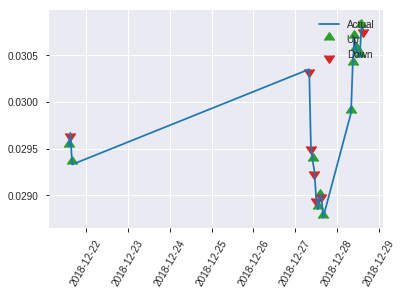


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.1950910581000349
RMSE: 0.4416911342782815
LogLoss: 0.5708369983619938
Mean Per-Class Error: 0.280378570221396
AUC: 0.7642386344431299
pr_auc: 0.6734409840454831
Gini: 0.5284772688862598
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40428465604782104: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      68   54   0.4426   (54.0/122.0)
1      12   85   0.1237   (12.0/97.0)
Total  80   139  0.3014   (66.0/219.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.404285     0.720339  138
max f2                       0.180755     0.83045   189
max f0point5                 0.499615     0.671078  107
max accuracy                 0.499615     0.712329  107
max precision                0.871382     1         0
max recall                   0.120872     1         203
max specificity              0.871382     1         0
max absolute_mcc             0.404285     0.447372  138
max min_per_class_accuracy   0.507345     0.704918  104
max mean_per_class_accuracy  0.472154     0.719621  117

Gains/Lift Table: Avg response rate: 44.29 %, avg score: 46.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136986                   0.833424           2.25773   2.25773            1                0.851959  1                           0.851959            0.0309278       0.0309278                  125.773   125.773
    2        0.0228311                   0.821758           1.12887   1.80619            0.5              0.825292  0.8                         0.841292            0.0103093       0.0412371                  12.8866   80.6186
    3        0.0319635                   0.811191           2.25773   1.9352             1                0.81394   0.857143                    0.833477            0.0206186       0.0618557                  125.773   93.5199
    4        0.0410959                   0.803406           1.12887   1.75601            0.5              0.808577  0.777778                    0.827944            0.0103093       0.0721649                  12.8866   75.6014
    5        0.0502283                   0.79561            2.25773   1.84724            1                0.799206  0.818182                    0.822719            0.0206186       0.0927835                  125.773   84.7235
    6        0.100457                    0.745136           1.43674   1.64199            0.636364         0.764607  0.727273                    0.793663            0.0721649       0.164948                   43.6739   64.1987
    7        0.150685                    0.694005           1.84724   1.7104             0.818182         0.71459   0.757576                    0.767305            0.0927835       0.257732                   84.7235   71.0403
    8        0.200913                    0.644722           1.02624   1.53936            0.454545         0.664436  0.681818                    0.741588            0.0515464       0.309278                   2.62418   53.9363
    9        0.30137                     0.603989           1.64199   1.57357            0.727273         0.62492   0.69697                     0.702699            0.164948        0.474227                   64.1987   57.3571
    10       0.401826                    0.559211           1.33411   1.51371            0.590909         0.581982  0.670455                    0.672519            0.134021        0.608247                   33.4114   51.3707
    11       0.502283                    0.496232           1.23149   1.45726            0.545455         0.522646  0.645455                    0.642545            0.123711        0.731959                   23.149    45.7263
    12       0.598174                    0.430188           1.07511   1.396              0.47619          0.459866  0.618321                    0.61326             0.103093        0.835052                   7.51105   39.6002
    13       0.69863                     0.333989           0.615745  1.28381            0.272727         0.385241  0.568627                    0.580473            0.0618557       0.896907                   -38.4255  28.3808
    14       0.799087                    0.237471           0.410497  1.17402            0.181818         0.293826  0.52                        0.544438            0.0412371       0.938144                   -58.9503  17.4021
    15       0.899543                    0.146985           0.513121  1.10021            0.227273         0.193415  0.48731                     0.505237            0.0515464       0.989691                   -48.6879  10.0215
    16       1                           0.0575387          0.102624  1                  0.0454545        0.103409  0.442922                    0.464871         

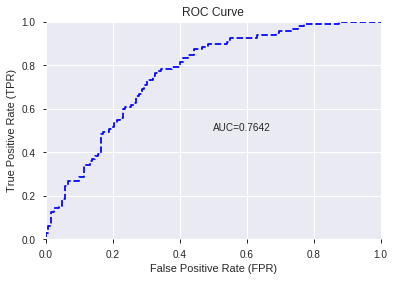

This function is available for GLM models only


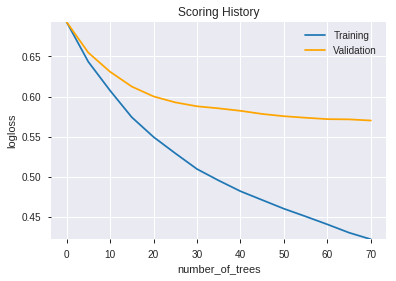

--2019-08-26 14:27:33--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.170.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.170.107|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190826_142708',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190826_142708',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_bd86',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_26_sid_bd86',
   'type

['BOP',
 'STOCHF_fastk',
 'DIV',
 'hour',
 'STOCHRSI_fastk',
 'SUB',
 'HT_PHASOR_quadrature',
 'BETA_20',
 'ADX_8',
 'STOCH_slowd',
 'STOCHF_fastd',
 'ADOSC',
 'Volume',
 'MFI_12',
 'WILLR_8',
 'DX_14',
 'aroonup_8',
 'BETA_24',
 'TRANGE',
 'SAREXT',
 'ADXR_14',
 'HT_PHASOR_inphase',
 'aroonup_30',
 'BETA_12',
 'WILLR_12',
 'HT_DCPERIOD',
 'OBV',
 'DX_8',
 'MFI_8',
 'MFI_24',
 'DX_24',
 'aroondown_30',
 'DX_20',
 'aroonup_12',
 'CDLLONGLINE',
 'CDLCLOSINGMARUBOZU',
 'dayofweek',
 'weekday_name',
 'weekday',
 'CDLDOJI',
 'CDLHAMMER',
 'CDLSPINNINGTOP',
 'CDLSHORTLINE',
 'HT_TRENDMODE',
 'CDLLONGLEGGEDDOJI']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190826_142742_model_1  0.707876  0.657862              0.321362  0.482607  0.23291

variable  relative_importance  scaled_importance    percentage
0                          BOP             0.148501           1.000000  2.816365e-02
1           CDLCLOSINGMARUBOZU             0.089797           0.604692  1.703032e-02
2                         hour             0.081435           0.548382  1.544444e-02
3               STOCHRSI_fastk             0.076201           0.513135  1.445176e-02
4                 STOCHF_fastk             0.075929           0.511306  1.440023e-02
...                        ...                  ...                ...           ...
1031                   MA_12_1             0.000009           0.000058  1.638871e-06
1032   BBANDS_upperband_12_2_4             0.000007           0.000046  1.293531e-06
1033   BBANDS_upperband_14_6_5             0.000006           0.000038  1.065537e-06
1034                   KAMA_20             0.000005           0.000037  1.028349e-06
1035  BBANDS_middleband_12_6_4             0.000003           0.000021  5.806503e-07

[1036 rows x 4 columns]

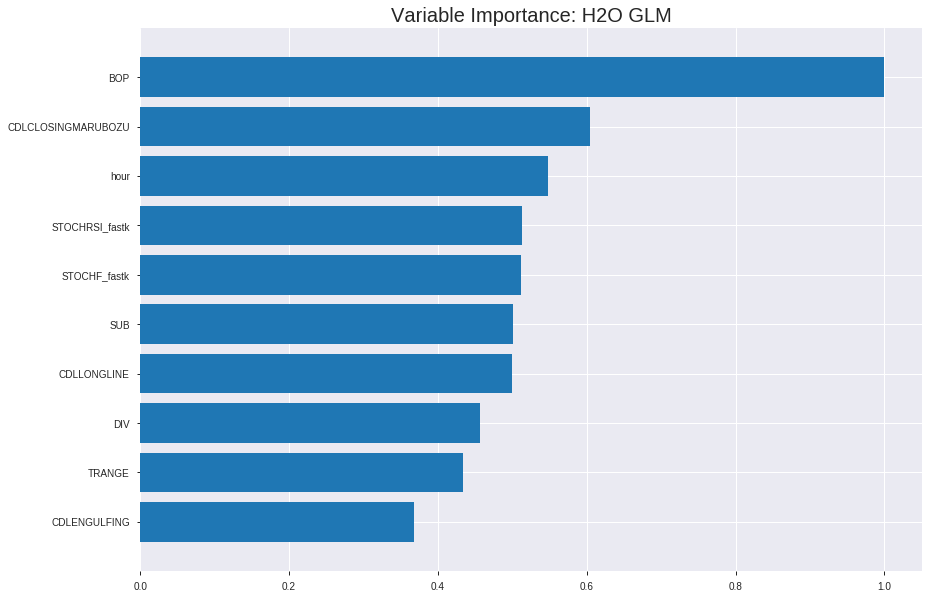

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_142742_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19954220893619884
RMSE: 0.4467014763085061
LogLoss: 0.585838499374025
Null degrees of freedom: 1530
Residual degrees of freedom: 494
Null deviance: 2115.4819722816574
Residual deviance: 1793.8374850832645
AIC: 3867.8374850832643
AUC: 0.7764897880816953
pr_auc: 0.742199623188971
Gini: 0.5529795761633907
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40409214300196383: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      435  382  0.4676   (382.0/817.0)
1      100  614  0.1401   (100.0/714.0)
Total  535  996  0.3148   (482.0/1531.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.404092     0.718129  245
max f2                       0.30933      0.828669  307
max f0point5                 0.52699      0.694723  156
max accuracy                 0.490098     0.711953  182
max precision                0.875838     1         0
max recall                   0.140382     1         391
max specificity              0.875838     1         0
max absolute_mcc             0.445436     0.425152  213
max min_per_class_accuracy   0.474732     0.708683  193
max mean_per_class_accuracy  0.451746     0.711953  209

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 46.64 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104507                   0.794946           2.14426   2.14426            1                0.82886   1                           0.82886             0.022409        0.022409                   114.426   114.426
    2        0.0202482                   0.756967           1.85836   2.00592            0.866667         0.770256  0.935484                    0.800503            0.0182073       0.0406162                  85.8357   100.592
    3        0.0300457                   0.741016           2.14426   2.05103            1                0.748815  0.956522                    0.783648            0.0210084       0.0616246                  114.426   105.103
    4        0.0404964                   0.725444           1.87623   2.00592            0.875            0.734425  0.935484                    0.770945            0.0196078       0.0812325                  87.6225   100.592
    5        0.0502939                   0.70717            1.71541   1.94933            0.8              0.713413  0.909091                    0.759738            0.0168067       0.0980392                  71.5406   94.9325
    6        0.100588                    0.662861           1.67085   1.81009            0.779221         0.684124  0.844156                    0.721931            0.0840336       0.182073                   67.085    81.0088
    7        0.150229                    0.631282           1.55177   1.72473            0.723684         0.645548  0.804348                    0.696691            0.0770308       0.259104                   55.1765   72.4729
    8        0.200523                    0.606126           1.47592   1.66232            0.688312         0.619378  0.775244                    0.6773              0.0742297       0.333333                   47.5918   66.2324
    9        0.300457                    0.55979            1.52761   1.61752            0.712418         0.583819  0.754348                    0.646207            0.152661        0.485994                   52.7608   61.7516
    10       0.400392                    0.515778           1.2333    1.52162            0.575163         0.536352  0.709625                    0.618788            0.123249        0.609244                   23.3299   52.1618
    11       0.500327                    0.467666           1.12118   1.44164            0.522876         0.492439  0.672324                    0.593552            0.112045        0.721289                   12.118    44.1635
    12       0.600261                    0.426945           0.924974  1.35562            0.431373         0.446121  0.632209                    0.569006            0.092437        0.813725                   -7.50261  35.5619
    13       0.700196                    0.374446           0.742782  1.26815            0.346405         0.402818  0.591418                    0.545287            0.0742297       0.887955                   -25.7218  26.8152
    14       0.800131                    0.317202           0.56059   1.17978            0.261438         0.346522  0.550204                    0.520462            0.0560224       0.943978                   -43.941   17.9779
    15       0.900065                    0.260391           0.322339  1.08458            0.150327         0.291231  0.505806                    0.49501             0.0322129       0.97619                    -67.7661  8.45774
    16       1                           0.0552815          0.238251  1                  0.111111         0.208338  0.466362                    0.466362         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2172915743714126
RMSE: 0.4661454433665662
LogLoss: 0.6259706589763241
Null degrees of freedom: 437
Residual degrees of freedom: -599
Null deviance: 603.5241039768543
Residual deviance: 548.3502972632599
AIC: 2622.35029726326
AUC: 0.7155513468013468
pr_auc: 0.6198294344900788
Gini: 0.4311026936026936
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4310536396037063: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      106  134  0.5583   (134.0/240.0)
1      16   182  0.0808   (16.0/198.0)
Total  122  316  0.3425   (150.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.431054     0.708171  282
max f2                       0.351981     0.826087  322
max f0point5                 0.469073     0.629713  250
max accuracy                 0.469073     0.666667  250
max precision                0.794033     0.8125    14
max recall                   0.184293     1         390
max specificity              0.931754     0.995833  0
max absolute_mcc             0.431054     0.400638  282
max min_per_class_accuracy   0.543478     0.645833  192
max mean_per_class_accuracy  0.466289     0.682576  252

Gains/Lift Table: Avg response rate: 45.21 %, avg score: 51.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.852571           0.884848  0.884848           0.4              0.897566  0.4                         0.897566            0.010101        0.010101                   -11.5152  -11.5152
    2        0.0205479                   0.819504           2.21212   1.47475            1                0.831592  0.666667                    0.868244            0.020202        0.030303                   121.212   47.4747
    3        0.0319635                   0.796716           2.21212   1.7381             1                0.804748  0.785714                    0.845567            0.0252525       0.0555556                  121.212   73.8095
    4        0.0410959                   0.768597           1.65909   1.72054            0.75             0.787088  0.777778                    0.832572            0.0151515       0.0707071                  65.9091   72.0539
    5        0.0502283                   0.757584           0.55303   1.50826            0.25             0.761478  0.681818                    0.819646            0.00505051      0.0757576                  -44.697   50.8264
    6        0.100457                    0.718061           1.60882   1.55854            0.727273         0.736635  0.704545                    0.77814             0.0808081       0.156566                   60.8815   55.854
    7        0.150685                    0.688773           1.10606   1.40771            0.5              0.702887  0.636364                    0.753056            0.0555556       0.212121                   10.6061   40.7713
    8        0.200913                    0.661929           1.20661   1.35744            0.545455         0.674154  0.613636                    0.73333             0.0606061       0.272727                   20.6612   35.7438
    9        0.30137                     0.611886           1.45799   1.39096            0.659091         0.635572  0.628788                    0.700744            0.146465        0.419192                   45.7989   39.0955
    10       0.399543                    0.576618           1.44045   1.40312            0.651163         0.596766  0.634286                    0.675195            0.141414        0.560606                   44.0451   40.3117
    11       0.5                         0.537144           0.955234  1.31313            0.431818         0.556984  0.593607                    0.651445            0.0959596       0.656566                   -4.47658  31.3131
    12       0.600457                    0.497867           1.15634   1.2869             0.522727         0.51631   0.581749                    0.628837            0.116162        0.772727                   15.6336   28.6899
    13       0.69863                     0.439738           1.18323   1.27233            0.534884         0.466185  0.575163                    0.605981            0.116162        0.888889                   18.3228   27.2331
    14       0.799087                    0.360216           0.55303   1.1819             0.25             0.404285  0.534286                    0.580625            0.0555556       0.944444                   -44.697   18.1905
    15       0.899543                    0.277764           0.402204  1.09483            0.181818         0.330411  0.494924                    0.552682            0.040404        0.984848                   -59.7796  9.48316
    16       1                           0.00582584         0.150826  1                  0.0681818        0.210912  0.452055                    0.518349         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 14:27:45  0.000 sec   2            18        1028          1.35502           1.35017
    2019-08-26 14:27:46  1.762 sec   4            13        1030          1.34801           1.34424
    2019-08-26 14:27:48  3.713 sec   6            9.5       1032          1.33941           1.33726
    2019-08-26 14:27:50  5.494 sec   8            6.9       1037          1.32892           1.32896
    2019-08-26 14:27:52  7.267 sec   10           5         1037          1.31637           1.31944
    2019-08-26 14:27:54  9.034 sec   12           3.7       1037          1.30173           1.30887
    2019-08-26 14:27:55  10.801 sec  14           2.7       1037          1.28514           1.29745
    2019-08-26 14:27:57  12.571 sec  16           1.9       1037          1.26695           1.2861
    2019-08-26 14:27:59  14.370 sec  18           1.4       1037          1.2477            1.27531
    2019-08-26 14:28:01  16.280 sec  20           1         1037          1.22796           1.26595
    2019-08-26 14:28:03  18.133 sec  22           0.75      1037          1.2084            1.25871
    2019-08-26 14:28:05  20.071 sec  24           0.55      1037          1.18949           1.25392
    2019-08-26 14:28:07  22.008 sec  26           0.4       1037          1.17168           1.25194
    2019-08-26 14:28:09  23.885 sec  28           0.29      1037          1.15522           1.25297
    2019-08-26 14:28:10  25.719 sec  30           0.21      1037          1.14023           1.25687
    2019-08-26 14:28:12  27.535 sec  32           0.15      1037          1.1267            1.26339
    2019-08-26 14:28:14  29.343 sec  34           0.11      1037          1.11453           1.27214
    2019-08-26 14:28:16  31.156 sec  36           0.081     1037          1.10356           1.28331

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6894977168949772)

('F1', 0.6755555555555557)

('auc', 0.7078756126415413)

('logloss', 0.6578617179925718)

('mean_per_class_error', 0.3209396653709651)

('rmse', 0.4826072500255848)

('mse', 0.2329097577772573)

glm prediction progress: |████████████████████████████████████████████████| 100%


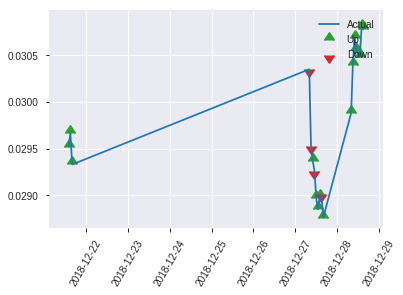


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2329097577772573
RMSE: 0.4826072500255848
LogLoss: 0.6578617179925718
Null degrees of freedom: 218
Residual degrees of freedom: -818
Null deviance: 301.2230274583454
Residual deviance: 288.14343248074636
AIC: 2362.1434324807465
AUC: 0.7078756126415413
pr_auc: 0.6011017069702624
Gini: 0.4157512252830826
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5678840522471432: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      70   52   0.4262   (52.0/122.0)
1      21   76   0.2165   (21.0/97.0)
Total  91   128  0.3333   (73.0/219.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.567884     0.675556  127
max f2                       0.421048     0.827526  185
max f0point5                 0.639485     0.652174  84
max accuracy                 0.639485     0.689498  84
max precision                0.880972     1         0
max recall                   0.343941     1         201
max specificity              0.880972     1         0
max absolute_mcc             0.639485     0.365034  84
max min_per_class_accuracy   0.600661     0.655738  105
max mean_per_class_accuracy  0.639485     0.67906   84

Gains/Lift Table: Avg response rate: 44.29 %, avg score: 57.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136986                   0.812248           2.25773   2.25773            1                0.841824  1                           0.841824            0.0309278       0.0309278                  125.773   125.773
    2        0.0228311                   0.804015           1.12887   1.80619            0.5              0.807412  0.8                         0.828059            0.0103093       0.0412371                  12.8866   80.6186
    3        0.0319635                   0.781012           1.12887   1.61267            0.5              0.796635  0.714286                    0.819081            0.0103093       0.0515464                  12.8866   61.2666
    4        0.0410959                   0.770755           1.12887   1.50515            0.5              0.77309   0.666667                    0.808861            0.0103093       0.0618557                  12.8866   50.5155
    5        0.0502283                   0.761228           1.12887   1.43674            0.5              0.769756  0.636364                    0.801751            0.0103093       0.0721649                  12.8866   43.6739
    6        0.100457                    0.745445           0.820993  1.12887            0.363636         0.753364  0.5                         0.777557            0.0412371       0.113402                   -17.9007  12.8866
    7        0.150685                    0.725696           1.64199   1.29991            0.727273         0.73487   0.575758                    0.763328            0.0824742       0.195876                   64.1987   29.9906
    8        0.200913                    0.702629           1.23149   1.2828             0.545455         0.715664  0.568182                    0.751412            0.0618557       0.257732                   23.149    28.2802
    9        0.30137                     0.661267           1.94986   1.50515            0.863636         0.683352  0.666667                    0.728725            0.195876        0.453608                   94.9859   50.5155
    10       0.401826                    0.63542            1.43674   1.48805            0.636364         0.648024  0.659091                    0.70855             0.14433         0.597938                   43.6739   48.8051
    11       0.502283                    0.598631           0.820993  1.35464            0.363636         0.612291  0.6                         0.689298            0.0824742       0.680412                   -17.9007  35.4639
    12       0.598174                    0.564635           1.07511   1.30983            0.47619          0.582076  0.580153                    0.67211             0.103093        0.783505                   7.51105   30.9829
    13       0.69863                     0.517299           0.615745  1.21003            0.272727         0.541566  0.535948                    0.653339            0.0618557       0.845361                   -38.4255  21.0026
    14       0.799087                    0.455454           0.718369  1.14822            0.318182         0.487956  0.508571                    0.632548            0.0721649       0.917526                   -28.1631  14.8218
    15       0.899543                    0.387775           0.718369  1.10021            0.318182         0.41712   0.48731                     0.60849             0.0721649       0.989691                   -28.1631  10.0215
    16       1                           0.0863581          0.102624  1                  0.0454545        0.283313  0.442922                    0.575824         

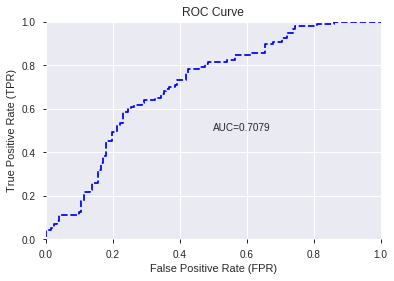

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


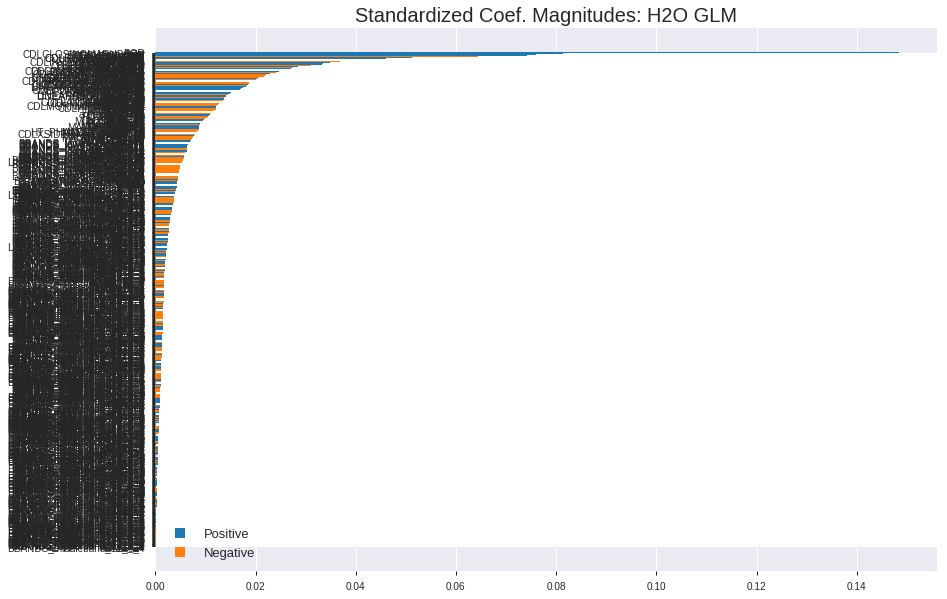

'log_likelihood'
--2019-08-26 14:28:40--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.108.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.108.243|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_142742_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_142742_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_bd86',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

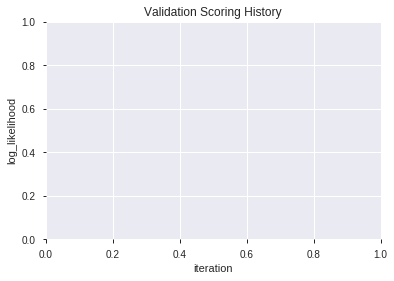

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_142850_model_6  0.746240  0.590137              0.306701  0.451023  0.203422
1               XGBoost_3_AutoML_20190826_142850  0.739226  0.593414              0.321109  0.452449  0.204710
2  XGBoost_grid_1_AutoML_20190826_142850_model_3  0.737958  0.599794              0.310926  0.455997  0.207933
3               XGBoost_2_AutoML_20190826_142850  0.733480  0.597792              0.352713  0.454902  0.206936
4  XGBoost_grid_1_AutoML_20190826_142850_model_2  0.729001  0.607068              0.319926  0.458176  0.209925
5  XGBoost_grid_1_AutoML_20190826_142850_model_7  0.724861  0.602589              0.314898  0.457680  0.209471
6  XGBoost_grid_1_AutoML_20190826_142850_model_5  0.724861  0.610417              0.369909  0.460692  0.212237
7  XGBoost_grid_1_AutoML_20190826_142850_model_1  0.723931  0.600196              0.335390  0.456748  0.208618
8  XGBoost_grid_1_AutoML_20190826_142850_model_4  0.720720  0.605702              0.344516  0.459348  0.211000
9               XGBoost_1_AutoML_20190826_142850  0.715650  0.610114              0.339361  0.461382  0.212873

variable  relative_importance  scaled_importance  percentage
0                        BOP          1395.049805           1.000000    0.120508
1                        DIV           414.635773           0.297219    0.035817
2               STOCHF_fastk           413.301208           0.296263    0.035702
3                       hour           395.487793           0.283494    0.034163
4                        SUB           290.168304           0.207999    0.025066
..                       ...                  ...                ...         ...
318   BBANDS_upperband_8_8_3             2.533126           0.001816    0.000219
319                   T3_8_1             2.439070           0.001748    0.000211
320  BBANDS_upperband_24_5_5             2.206612           0.001582    0.000191
321   BBANDS_lowerband_8_2_4             1.802763           0.001292    0.000156
322                     mama             1.617799           0.001160    0.000140

[323 rows x 4 columns]

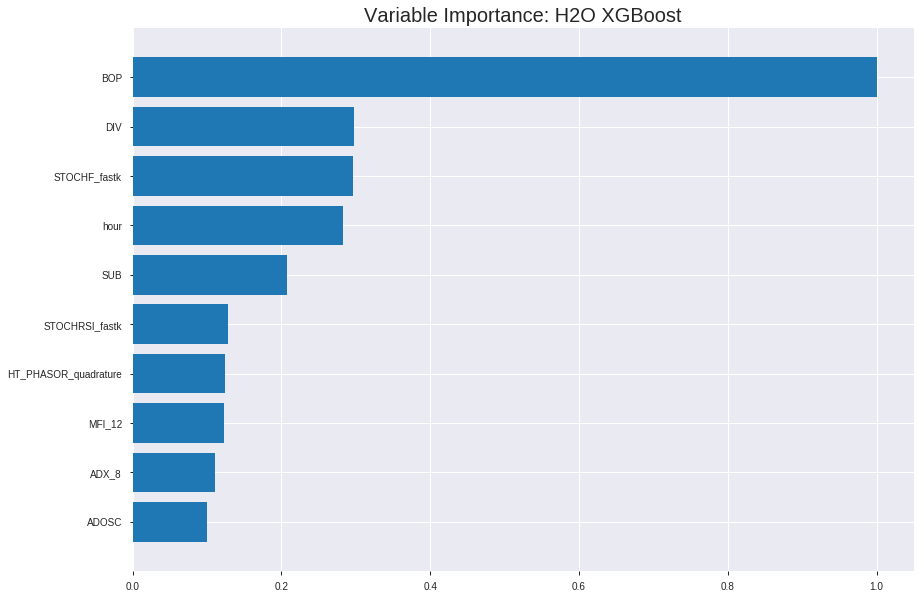

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_142850_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.10855352145265995
RMSE: 0.3294746142765174
LogLoss: 0.376243899441859
Mean Per-Class Error: 0.09151212504585682
AUC: 0.9699702402380781
pr_auc: 0.9687115952514109
Gini: 0.9399404804761562
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5079422891139984: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      751  66   0.0808   (66.0/817.0)
1      73   641  0.1022   (73.0/714.0)
Total  824  707  0.0908   (139.0/1531.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.507942     0.902182  193
max f2                       0.412296     0.924528  234
max f0point5                 0.558693     0.931494  168
max accuracy                 0.546382     0.909863  174
max precision                0.941973     1         0
max recall                   0.198684     1         327
max specificity              0.941973     1         0
max absolute_mcc             0.546382     0.821296  174
max min_per_class_accuracy   0.500102     0.904762  197
max mean_per_class_accuracy  0.507942     0.908488  193

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 46.62 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104507                   0.906306           2.14426    2.14426            1                0.91869   1                           0.91869             0.022409        0.022409                   114.426   114.426
    2        0.0202482                   0.881725           2.14426    2.14426            1                0.894077  1                           0.90678             0.0210084       0.0434174                  114.426   114.426
    3        0.0300457                   0.870921           2.14426    2.14426            1                0.877588  1                           0.897261            0.0210084       0.0644258                  114.426   114.426
    4        0.0404964                   0.855402           2.14426    2.14426            1                0.862932  1                           0.888402            0.022409        0.0868347                  114.426   114.426
    5        0.0502939                   0.846552           2.14426    2.14426            1                0.850882  1                           0.881093            0.0210084       0.107843                   114.426   114.426
    6        0.100588                    0.800485           2.14426    2.14426            1                0.821054  1                           0.851073            0.107843        0.215686                   114.426   114.426
    7        0.150229                    0.751392           2.14426    2.14426            1                0.772435  1                           0.825088            0.106443        0.322129                   114.426   114.426
    8        0.200523                    0.715951           2.14426    2.14426            1                0.735289  1                           0.802565            0.107843        0.429972                   114.426   114.426
    9        0.300457                    0.646116           2.07418    2.12095            0.96732          0.682676  0.98913                     0.762689            0.207283        0.637255                   107.418   112.095
    10       0.400392                    0.563888           1.86396    2.05681            0.869281         0.604668  0.959217                    0.723248            0.186275        0.823529                   86.3963   105.681
    11       0.500327                    0.465395           1.05111    1.85593            0.490196         0.516902  0.865535                    0.682033            0.105042        0.928571                   5.11067   85.5931
    12       0.600261                    0.369998           0.406428   1.61461            0.189542         0.418014  0.752992                    0.638078            0.0406162       0.969188                   -59.3572  61.461
    13       0.700196                    0.284914           0.182192   1.41017            0.0849673        0.327303  0.657649                    0.593723            0.0182073       0.987395                   -81.7808  41.0169
    14       0.800131                    0.201441           0.112118   1.24805            0.0522876        0.238583  0.582041                    0.549366            0.0112045       0.998599                   -88.7882  24.8046
    15       0.900065                    0.134134           0.0140148  1.11103            0.00653595       0.165036  0.518142                    0.506694            0.00140056      1                          -98.5985  11.103
    16       1                           0.0351149          0          1                  0                0.101363  0.466362                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20176886403400288
RMSE: 0.4491868920994945
LogLoss: 0.5907668115871807
Mean Per-Class Error: 0.2944444444444445
AUC: 0.7563867845117845
pr_auc: 0.662191933782488
Gini: 0.5127735690235691
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4211597144603729: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      135  105  0.4375   (105.0/240.0)
1      33   165  0.1667   (33.0/198.0)
Total  168  270  0.3151   (138.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.42116      0.705128  244
max f2                       0.250424     0.827616  339
max f0point5                 0.546944     0.682353  151
max accuracy                 0.546944     0.705479  151
max precision                0.881007     1         0
max recall                   0.120797     1         395
max specificity              0.881007     1         0
max absolute_mcc             0.444743     0.411589  227
max min_per_class_accuracy   0.492819     0.686869  192
max mean_per_class_accuracy  0.449535     0.705556  222

Gains/Lift Table: Avg response rate: 45.21 %, avg score: 47.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.84229            0.884848  0.884848           0.4              0.857094  0.4                         0.857094            0.010101        0.010101                   -11.5152  -11.5152
    2        0.0205479                   0.816861           2.21212   1.47475            1                0.831613  0.666667                    0.845769            0.020202        0.030303                   121.212   47.4747
    3        0.0319635                   0.799111           1.7697    1.58009            0.8              0.808517  0.714286                    0.832465            0.020202        0.0505051                  76.9697   58.0087
    4        0.0410959                   0.792119           0.55303   1.35185            0.25             0.794558  0.611111                    0.824041            0.00505051      0.0555556                  -44.697   35.1852
    5        0.0502283                   0.78233            1.65909   1.40771            0.75             0.787994  0.636364                    0.817487            0.0151515       0.0707071                  65.9091   40.7713
    6        0.100457                    0.731821           1.91047   1.65909            0.863636         0.753407  0.75                        0.785447            0.0959596       0.166667                   91.0468   65.9091
    7        0.150685                    0.687948           1.50826   1.60882            0.681818         0.708511  0.727273                    0.759802            0.0757576       0.242424                   50.8264   60.8815
    8        0.200913                    0.657993           1.70937   1.63395            0.772727         0.670641  0.738636                    0.737511            0.0858586       0.328283                   70.9366   63.3953
    9        0.30137                     0.586878           1.45799   1.5753             0.659091         0.624549  0.712121                    0.699857            0.146465        0.474747                   45.7989   57.5298
    10       0.399543                    0.530685           1.33756   1.51688            0.604651         0.558583  0.685714                    0.665144            0.131313        0.606061                   33.7562   51.6883
    11       0.5                         0.484105           0.804408  1.37374            0.363636         0.509476  0.621005                    0.633868            0.0808081       0.686869                   -19.5592  37.3737
    12       0.600457                    0.426397           1.15634   1.33737            0.522727         0.453704  0.604563                    0.603727            0.116162        0.80303                    15.6336   33.7366
    13       0.69863                     0.363177           0.87456   1.27233            0.395349         0.397718  0.575163                    0.574778            0.0858586       0.888889                   -12.544   27.2331
    14       0.799087                    0.28357            0.603306  1.18823            0.272727         0.320148  0.537143                    0.542767            0.0606061       0.949495                   -39.6694  18.8225
    15       0.899543                    0.20736            0.301653  1.08922            0.136364         0.252795  0.492386                    0.510385            0.030303        0.979798                   -69.8347  8.9217
    16       1                           0.103744           0.201102  1                  0.0909091        0.163649  0.452055                    0.475553         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:29:41  32.468 sec  0                  0.5              0.693147            0.5             0                  1                0.533638                         0.5                0.693147              0.5               0                    1                  0.547945
    2019-08-26 14:29:42  33.564 sec  5                  0.471371         0.637171            0.858148        0.837791           2.14426          0.227956                         0.481503           0.656583              0.73911           0.631595             0.884848           0.305936
    2019-08-26 14:29:42  33.773 sec  10                 0.447244         0.591232            0.881732        0.866389           2.14426          0.211626                         0.474085           0.641874              0.733954          0.632517             0.884848           0.310502
    2019-08-26 14:29:42  33.987 sec  15                 0.429595         0.557833            0.890641        0.878926           2.14426          0.195297                         0.470734           0.635264              0.735459          0.639596             1.32727            0.342466
    2019-08-26 14:29:43  34.198 sec  20                 0.415112         0.530365            0.903897        0.895472           2.14426          0.177008                         0.465637           0.625113              0.741751          0.642428             1.32727            0.326484
    2019-08-26 14:29:43  34.410 sec  25                 0.40365          0.508659            0.913912        0.908602           2.14426          0.184847                         0.462681           0.61888               0.739341          0.63519              1.32727            0.312785
    2019-08-26 14:29:43  34.648 sec  30                 0.3925           0.488193            0.92328         0.918428           2.14426          0.161332                         0.46176            0.617083              0.73831           0.633117             0.884848           0.351598
    2019-08-26 14:29:43  34.859 sec  35                 0.382951         0.470246            0.930396        0.926229           2.14426          0.15676                          0.457348           0.607914              0.744066          0.641851             0.884848           0.333333
    2019-08-26 14:29:43  35.071 sec  40                 0.374951         0.455559            0.937331        0.933237           2.14426          0.143044                         0.454953           0.602515              0.746423          0.6449               0.884848           0.319635
    2019-08-26 14:29:44  35.280 sec  45                 0.366774         0.440737            0.944816        0.943461           2.14426          0.134553                         0.45328            0.599341              0.752357          0.649774             0.884848           0.335616
    2019-08-26 14:29:44  35.482 sec  50                 0.360168         0.428656            0.948713        0.947015           2.14426          0.127368                         0.450718           0.59391               0.757776          0.655364             0.884848           0.324201
    2019-08-26 14:29:44  35.695 sec  55                 0.35349          0.417204            0.955276        0.952068           2.14426          0.112998                         0.450548           0.593452              0.756197          0

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      1395.0498046875        1.0                    0.12050836659237638
DIV                      414.6357727050781      0.29721933318212906    0.03581741636145366
STOCHF_fastk             413.30120849609375     0.2962626904841407     0.03570213291250656
hour                     395.48779296875        0.28349367287094224    0.03416335945695073
SUB                      290.1683044433594      0.20799852698331361    0.02506556274037945
---                      ---                    ---                    ---
BBANDS_upperband_8_8_3   2.53312611579895       0.001815796186836775   0.0002188186325403652
T3_8_1                   2.4390697479248047     0.0017483746743157831  0.00021069377619327304
BBANDS_upperband_24_5_5  2.2066121101379395     0.0015817443239112417  0.00019061342484130643
BBANDS_lowerband_8_2_4   1.8027626276016235     0.0012922568223329158  0.0001557277588771944
mama                     1.6177985668182373     0.0011596708313798406  0.0001397500376744077


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.680365296803653)

('F1', 0.7049180327868851)

('auc', 0.7462396484705087)

('logloss', 0.5901371210927008)

('mean_per_class_error', 0.30670103092783507)

('rmse', 0.45102293312020897)

('mse', 0.20342168620035647)

xgboost prediction progress: |████████████████████████████████████████████| 100%


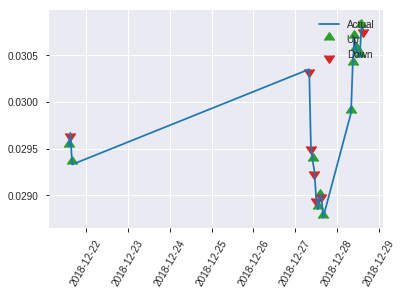


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20342168620035647
RMSE: 0.45102293312020897
LogLoss: 0.5901371210927008
Mean Per-Class Error: 0.30670103092783507
AUC: 0.7462396484705087
pr_auc: 0.681042290133977
Gini: 0.49247929694101744
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42065712809562683: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      61   61   0.5      (61.0/122.0)
1      11   86   0.1134   (11.0/97.0)
Total  72   147  0.3288   (72.0/219.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.420657     0.704918  146
max f2                       0.203983     0.826235  198
max f0point5                 0.574303     0.641646  78
max accuracy                 0.574303     0.680365  78
max precision                0.892585     1         0
max recall                   0.203983     1         198
max specificity              0.892585     1         0
max absolute_mcc             0.420657     0.40879   146
max min_per_class_accuracy   0.527583     0.672131  105
max mean_per_class_accuracy  0.420657     0.693299  146

Gains/Lift Table: Avg response rate: 44.29 %, avg score: 49.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136986                   0.855004           2.25773   2.25773            1                0.870972  1                           0.870972            0.0309278       0.0309278                  125.773   125.773
    2        0.0228311                   0.841876           2.25773   2.25773            1                0.848734  1                           0.862077            0.0206186       0.0515464                  125.773   125.773
    3        0.0319635                   0.834622           2.25773   2.25773            1                0.836026  1                           0.854634            0.0206186       0.0721649                  125.773   125.773
    4        0.0410959                   0.811888           0         1.75601            0                0.828703  0.777778                    0.848871            0               0.0721649                  -100      75.6014
    5        0.0502283                   0.801913           2.25773   1.84724            1                0.806205  0.818182                    0.841114            0.0206186       0.0927835                  125.773   84.7235
    6        0.100457                    0.726282           1.84724   1.84724            0.818182         0.765955  0.818182                    0.803535            0.0927835       0.185567                   84.7235   84.7235
    7        0.150685                    0.669987           1.84724   1.84724            0.818182         0.700266  0.818182                    0.769112            0.0927835       0.278351                   84.7235   84.7235
    8        0.200913                    0.645277           0.820993  1.59067            0.363636         0.657611  0.704545                    0.741237            0.0412371       0.319588                   -17.9007  59.0675
    9        0.30137                     0.600268           1.23149   1.47095            0.545455         0.623488  0.651515                    0.701987            0.123711        0.443299                   23.149    47.0947
    10       0.401826                    0.554558           1.33411   1.43674            0.590909         0.577222  0.636364                    0.670796            0.134021        0.57732                    33.4114   43.6739
    11       0.502283                    0.521284           1.23149   1.39569            0.545455         0.537199  0.618182                    0.644076            0.123711        0.701031                   23.149    39.5689
    12       0.598174                    0.479611           0.967599  1.32706            0.428571         0.505995  0.587786                    0.621941            0.0927835       0.793814                   -3.24006  32.7064
    13       0.69863                     0.402807           0.923618  1.26905            0.409091         0.43723   0.562092                    0.595381            0.0927835       0.886598                   -7.63824  26.9052
    14       0.799087                    0.32382            0.615745  1.18692            0.272727         0.357555  0.525714                    0.565483            0.0618557       0.948454                   -38.4255  18.6922
    15       0.899543                    0.20696            0.410497  1.10021            0.181818         0.274104  0.48731                     0.532943            0.0412371       0.989691                   -58.9503  10.0215
    16       1                           0.0953041          0.102624  1                  0.0454545        0.1617    0.442922                    0.49565          

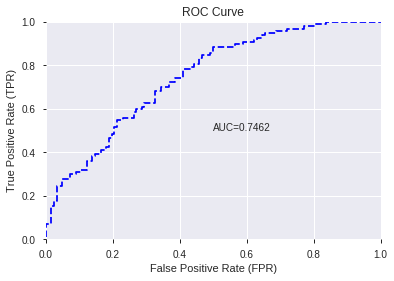

This function is available for GLM models only


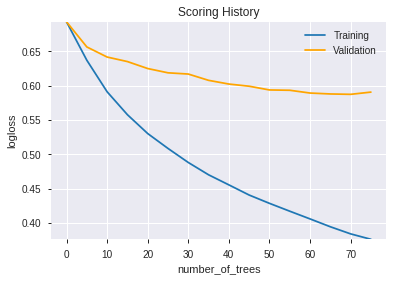

--2019-08-26 14:29:56--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.176.219
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.176.219|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_142850_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_142850_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_bd86',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_143004_model_5  0.754521  0.585837              0.276153  0.447893  0.200609
1  DeepLearning_grid_1_AutoML_20190826_143004_model_9  0.753676  0.594064              0.306828  0.453266  0.205450
2  DeepLearning_grid_1_AutoML_20190826_143004_model_6  0.742606  0.591033              0.281308  0.452722  0.204958
3  DeepLearning_grid_1_AutoML_20190826_143004_model_4  0.737113  0.797028              0.309870  0.495453  0.245474
4  DeepLearning_grid_1_AutoML_20190826_143004_model_8  0.736606  0.597424              0.321109  0.453989  0.206106
5               DeepLearning_1_AutoML_20190826_143004  0.731114  0.649809              0.378232  0.478747  0.229199
6  DeepLearning_grid_1_AutoML_20190826_143004_model_3  0.723255  0.659977              0.346502  0.469857  0.220765
7  DeepLearning_grid_1_AutoML_20190826_143004_model_7  0.722241  0.656060              0.298758  0.468542  0.219531
8  DeepLearning_grid_1_AutoML_20190826_143004_model_1  0.682694  0.868061              0.390527  0.511654  0.261790
9  DeepLearning_grid_1_AutoML_20190826_143004_model_2  0.672385  0.828930              0.392513  0.512802  0.262966

variable  relative_importance  scaled_importance  percentage
0                    BOP             1.000000           1.000000    0.030727
1                   hour             0.796694           0.796694    0.024480
2             aroonup_30             0.749876           0.749876    0.023041
3                 Volume             0.733879           0.733879    0.022550
4         STOCHRSI_fastk             0.732300           0.732300    0.022501
5                 TRANGE             0.726220           0.726220    0.022315
6           aroondown_30             0.724114           0.724114    0.022250
7           weekday_name             0.718900           0.718900    0.022090
8              aroonup_8             0.712797           0.712797    0.021902
9           STOCHF_fastk             0.710062           0.710062    0.021818
10                   SUB             0.698873           0.698873    0.021474
11    CDLCLOSINGMARUBOZU             0.690642           0.690642    0.021221
12                SAREXT             0.690242           0.690242    0.021209
13                   DIV             0.687122           0.687122    0.021113
14               BETA_24             0.684347           0.684347    0.021028
15               BETA_20             0.680039           0.680039    0.020896
16          HT_TRENDMODE             0.661636           0.661636    0.020330
17                   OBV             0.661577           0.661577    0.020328
18           HT_DCPERIOD             0.648590           0.648590    0.019929
19           STOCH_slowd             0.648543           0.648543    0.019928
20            aroonup_12             0.647776           0.647776    0.019904
21  HT_PHASOR_quadrature             0.646197           0.646197    0.019856
22               weekday             0.640656           0.640656    0.019685
23               BETA_12             0.640548           0.640548    0.019682
24                MFI_12             0.639364           0.639364    0.019646
25          CDLSHORTLINE             0.638524           0.638524    0.019620
26        CDLSPINNINGTOP             0.631322           0.631322    0.019399
27                 MFI_8             0.628883           0.628883    0.019324
28             dayofweek             0.626140           0.626140    0.019239
29           CDLMARUBOZU             0.623028           0.623028    0.019144
30                 ADOSC             0.619490           0.619490    0.019035
31             CDLHAMMER             0.615773           0.615773    0.018921
32     HT_PHASOR_inphase             0.614566           0.614566    0.018884
33               ADXR_14             0.606496           0.606496    0.018636
34               WILLR_8             0.603853           0.603853    0.018555
35                  DX_8             0.601824           0.601824    0.018492
36               CDLDOJI             0.600724           0.600724    0.018458
37                 ADX_8             0.599243           0.599243    0.018413
38     CDLLONGLEGGEDDOJI             0.598194           0.598194    0.018381
39              WILLR_12             0.593613           0.593613    0.018240
40                 DX_24             0.593505           0.593505    0.018237
41          CDLENGULFING             0.593393           0.593393    0.018233
42          is_month_end             0.583867           0.583867    0.017940
43                 DX_14             0.583678           0.583678    0.017935
44        CDLRICKSHAWMAN             0.578793           0.578793    0.017785
45           CDLBELTHOLD             0.576654           0.576654    0.017719
46                MFI_24             0.566582           0.566582    0.017409
47                 DX_20             0.566124           0.566124    0.017395
48           CDLLONGLINE             0.565927           0.565927    0.017389
49          STOCHF_fastd             0.563481           0.563481    0.017314

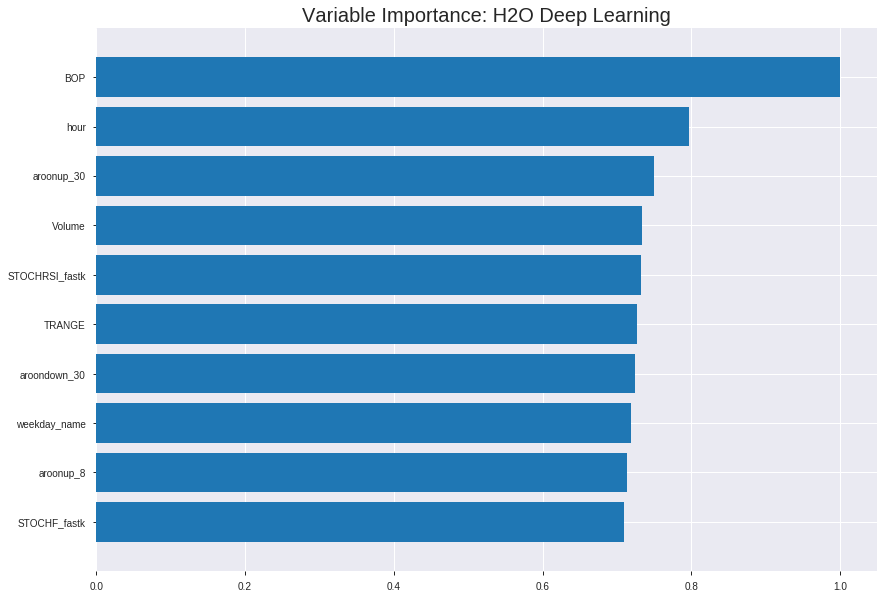

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_143004_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18448885993353262
RMSE: 0.42952166410267667
LogLoss: 0.5435742880927696
Mean Per-Class Error: 0.2776829213937717
AUC: 0.7951170676348874
pr_auc: 0.7644603110203625
Gini: 0.5902341352697749
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36819282204659776: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      451  366  0.448    (366.0/817.0)
1      88   626  0.1232   (88.0/714.0)
Total  539  992  0.2965   (454.0/1531.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.368193     0.73388   246
max f2                       0.167021     0.841463  326
max f0point5                 0.560323     0.700423  146
max accuracy                 0.478619     0.715872  193
max precision                0.9985       1         0
max recall                   0.0411752    1         383
max specificity              0.9985       1         0
max absolute_mcc             0.415929     0.452824  226
max min_per_class_accuracy   0.490432     0.710084  186
max mean_per_class_accuracy  0.415929     0.722317  226

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 43.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104507                   0.934281           2.14426   2.14426            1                0.962391   1                           0.962391            0.022409        0.022409                   114.426   114.426
    2        0.0202482                   0.892233           2.00131   2.07509            0.933333         0.919553   0.967742                    0.941663            0.0196078       0.0420168                  100.131   107.509
    3        0.0300457                   0.849193           2.14426   2.09764            1                0.866977   0.978261                    0.917309            0.0210084       0.0630252                  114.426   109.764
    4        0.0404964                   0.821823           2.14426   2.10967            1                0.837138   0.983871                    0.89662             0.022409        0.0854342                  114.426   110.967
    5        0.0502939                   0.802036           1.85836   2.06072            0.866667         0.811413   0.961039                    0.880021            0.0182073       0.103641                   85.8357   106.072
    6        0.100588                    0.708544           1.78224   1.92148            0.831169         0.745953   0.896104                    0.812987            0.0896359       0.193277                   78.224    92.1478
    7        0.150229                    0.661522           1.55177   1.79931            0.723684         0.684226   0.83913                     0.77044             0.0770308       0.270308                   55.1765   79.9312
    8        0.200523                    0.628812           1.53161   1.73217            0.714286         0.644018   0.807818                    0.738732            0.0770308       0.347339                   53.1613   73.2169
    9        0.300457                    0.580878           1.40148   1.62218            0.653595         0.603698   0.756522                    0.693818            0.140056        0.487395                   40.1476   62.2178
    10       0.400392                    0.533571           1.28936   1.53911            0.601307         0.557639   0.717781                    0.659829            0.128852        0.616246                   28.9358   53.9108
    11       0.500327                    0.482156           1.1352    1.45843            0.529412         0.50721    0.680157                    0.629345            0.113445        0.729692                   13.5195   45.8431
    12       0.600261                    0.415594           1.07914   1.39528            0.503268         0.452231   0.650707                    0.599858            0.107843        0.837535                   7.91362   39.5284
    13       0.700196                    0.30832            0.686723  1.29416            0.320261         0.363168   0.603545                    0.566077            0.0686275       0.906162                   -31.3277  29.4156
    14       0.800131                    0.187166           0.532561  1.19903            0.248366         0.24774    0.559184                    0.526317            0.0532213       0.959384                   -46.7439  19.9034
    15       0.900065                    0.081638           0.29431   1.09858            0.137255         0.128419   0.512337                    0.482138            0.0294118       0.988796                   -70.569   9.8582
    16       1                           0.00766351         0.112118  1                  0.0522876        0.0428966  0.466362                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2039178391871804
RMSE: 0.451572628917188
LogLoss: 0.5932530753650843
Mean Per-Class Error: 0.30366161616161613
AUC: 0.7411931818181817
pr_auc: 0.6534913949801814
Gini: 0.48238636363636345
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.295106252732919: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      117  123  0.5125   (123.0/240.0)
1      22   176  0.1111   (22.0/198.0)
Total  139  299  0.3311   (145.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.295106     0.708249  269
max f2                       0.14255      0.841367  318
max f0point5                 0.445353     0.652557  208
max accuracy                 0.445353     0.689498  208
max precision                0.978323     1         0
max recall                   0.0204251    1         391
max specificity              0.978323     1         0
max absolute_mcc             0.295106     0.402469  269
max min_per_class_accuracy   0.480613     0.670833  190
max mean_per_class_accuracy  0.430041     0.696338  216

Gains/Lift Table: Avg response rate: 45.21 %, avg score: 41.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.931873           1.7697    1.7697             0.8              0.957146   0.8                         0.957146            0.020202        0.020202                   76.9697   76.9697
    2        0.0205479                   0.876345           1.65909   1.72054            0.75             0.896466   0.777778                    0.930177            0.0151515       0.0353535                  65.9091   72.0539
    3        0.0319635                   0.822055           1.7697    1.7381             0.8              0.84979    0.785714                    0.901467            0.020202        0.0555556                  76.9697   73.8095
    4        0.0410959                   0.788784           2.21212   1.84343            1                0.802219   0.833333                    0.879412            0.020202        0.0757576                  121.212   84.3434
    5        0.0502283                   0.771459           1.10606   1.70937            0.5              0.782911   0.772727                    0.861866            0.010101        0.0858586                  10.6061   70.9366
    6        0.100457                    0.679804           1.40771   1.55854            0.636364         0.720152   0.704545                    0.791009            0.0707071       0.156566                   40.7713   55.854
    7        0.150685                    0.637863           1.60882   1.5753             0.727273         0.658544   0.712121                    0.746854            0.0808081       0.237374                   60.8815   57.5298
    8        0.200913                    0.609741           1.50826   1.55854            0.681818         0.624745   0.704545                    0.716327            0.0757576       0.313131                   50.8264   55.854
    9        0.30137                     0.565867           1.10606   1.40771            0.5              0.586769   0.636364                    0.673141            0.111111        0.424242                   10.6061   40.7713
    10       0.399543                    0.524699           1.44045   1.41576            0.651163         0.546105   0.64                        0.641926            0.141414        0.565657                   44.0451   41.5758
    11       0.5                         0.462794           1.30716   1.39394            0.590909         0.495025   0.630137                    0.612412            0.131313        0.69697                    30.7163   39.3939
    12       0.600457                    0.39844            1.15634   1.35419            0.522727         0.430983   0.612167                    0.582059            0.116162        0.813131                   15.6336   35.4188
    13       0.69863                     0.267923           0.823115  1.27956            0.372093         0.336277   0.578431                    0.547521            0.0808081       0.893939                   -17.6885  27.956
    14       0.799087                    0.141801           0.754132  1.21351            0.340909         0.206356   0.548571                    0.504632            0.0757576       0.969697                   -24.5868  21.3506
    15       0.899543                    0.0635454          0.100551  1.08922            0.0454545        0.0992214  0.492386                    0.459357            0.010101        0.979798                   -89.9449  8.9217
    16       1                           0.00531166         0.201102  1                  0.0909091        0.0347196  0.452055                    0.4


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:33:10  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 14:33:12  1 min 18.979 sec  1463 obs/sec      1.31744   1             2017       0.469407         0.631271            0.114619       0.699516        0.635759           1.87623          0.399086                         0.461965           0.615084              0.13843          0.717372          0.634358             2.21212            0.335616
    2019-08-26 14:33:17  1 min 24.115 sec  2348 obs/sec      9.31613   7             14263      0.429522         0.543574            0.258689       0.795117        0.76446            2.14426          0.296538                         0.451573           0.593253              0.176759         0.741193          0.653491             1.7697             0.33105
    2019-08-26 14:33:22  1 min 29.265 sec  2664 obs/sec      18.7596   14            28721      0.400877         0.478952            0.354267       0.84578         0.826706           2.14426          0.255389                         0.45912            0.622577              0.149011         0.735743          0.639656             1.7697             0.36758
    2019-08-26 14:33:27  1 min 34.554 sec  2876 obs/sec      29.4076   22            45023      0.374685         0.423745            0.43589        0.889675        0.872324           2.14426          0.22273                          0.474961           0.682202              0.0892744        0.71108           0.62126              1.7697             0.356164
    2019-08-26 14:33:33  1 min 39.769 sec  3013 obs/sec      40.2195   30            61576      0.340656         0.361734            0.533702       0.930495        0.908991           2.14426          0.160679                         0.489395           0.743755              0.0330788        0.699621          0.613257             1.32727            0.36758
    2019-08-26 14:33:38  1 min 44.936 sec  3102 obs/sec      51.0189   38            78110      0.316536         0.324315            0.597399       0.953179        0.930469           2.14426          0.128674                         0.485337           0.770502              0.0490499        0.700095          0.609471             0.884848           0.39726
    2019-08-26 14:33:38  1 min 45.377 sec  3099 obs/sec      51.0189   38            78110      0.429522         0.543574            0.258689       0.795117        0.76446            2.14426          0.296538                         0.451573           0.593253              0.176759         0.741193          0.653491             1.7697             0.33105

Variable Importances: 


variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  --------------------
BOP             1.0                    1.0                  0.030726997087111952
hour            0.7966935038566589     0.7966935038566589   0.024479998972324574
aroonup_30      0.749876081943512      0.749876081943512    0.023041440185573216
Volume          0.7338792681694031     0.7338792681694031   0.0225499061353331
STOCHRSI_fastk  0.7322995066642761     0.7322995066642761   0.02250136480816673
---             ---                    ---                  ---
CDLBELTHOLD     0.5766537189483643     0.5766537189483643   0.017718837142398663
MFI_24          0.566582202911377      0.566582202911377    0.01740936969846735
DX_20           0.5661240816116333     0.5661240816116333   0.017395293006624585
CDLLONGLINE     0.5659272074699402     0.5659272074699402   0.017389243655446255
STOCHF_fastd    0.5634812116622925     0.5634812116622925   0.017314085549389575


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.726027397260274)

('F1', 0.7174887892376681)

('auc', 0.7545208720635458)

('logloss', 0.5858366043009715)

('mean_per_class_error', 0.27019604529322294)

('rmse', 0.44789348146490027)

('mse', 0.20060857073874894)

deeplearning prediction progress: |███████████████████████████████████████| 100%


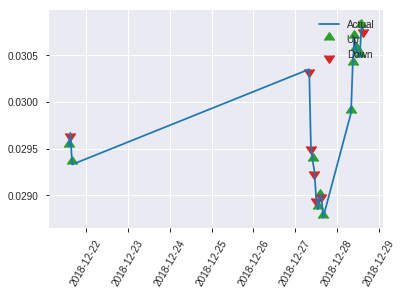


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20060857073874894
RMSE: 0.44789348146490027
LogLoss: 0.5858366043009715
Mean Per-Class Error: 0.27019604529322294
AUC: 0.7545208720635458
pr_auc: 0.6646946621274823
Gini: 0.5090417441270916
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4433190691326655: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      76   46   0.377    (46.0/122.0)
1      17   80   0.1753   (17.0/97.0)
Total  93   126  0.2877   (63.0/219.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.443319     0.717489  125
max f2                       0.0378052    0.82343   200
max f0point5                 0.48215      0.683919  110
max accuracy                 0.48215      0.726027  110
max precision                0.98879      1         0
max recall                   0.0378052    1         200
max specificity              0.98879      1         0
max absolute_mcc             0.48215      0.456646  110
max min_per_class_accuracy   0.485952     0.704918  104
max mean_per_class_accuracy  0.48215      0.729804  110

Gains/Lift Table: Avg response rate: 44.29 %, avg score: 42.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136986                   0.831194           2.25773   2.25773            1                0.915236   1                           0.915236            0.0309278       0.0309278                  125.773   125.773
    2        0.0228311                   0.813911           1.12887   1.80619            0.5              0.822215   0.8                         0.878027            0.0103093       0.0412371                  12.8866   80.6186
    3        0.0319635                   0.801747           1.12887   1.61267            0.5              0.809591   0.714286                    0.858474            0.0103093       0.0515464                  12.8866   61.2666
    4        0.0410959                   0.779269           2.25773   1.75601            1                0.796291   0.777778                    0.844656            0.0206186       0.0721649                  125.773   75.6014
    5        0.0502283                   0.763808           0         1.43674            0                0.769518   0.636364                    0.830994            0               0.0721649                  -100      43.6739
    6        0.100457                    0.685072           2.05248   1.74461            0.909091         0.72696    0.772727                    0.778977            0.103093        0.175258                   105.248   74.4611
    7        0.150685                    0.651938           1.64199   1.7104             0.727273         0.673989   0.757576                    0.743981            0.0824742       0.257732                   64.1987   71.0403
    8        0.200913                    0.627002           1.23149   1.59067            0.545455         0.63869    0.704545                    0.717658            0.0618557       0.319588                   23.149    59.0675
    9        0.30137                     0.579104           1.33411   1.50515            0.590909         0.602408   0.666667                    0.679241            0.134021        0.453608                   33.4114   50.5155
    10       0.401826                    0.53473            1.33411   1.46239            0.590909         0.559693   0.647727                    0.649354            0.134021        0.587629                   33.4114   46.2395
    11       0.502283                    0.482379           1.64199   1.49831            0.727273         0.504518   0.663636                    0.620387            0.164948        0.752577                   64.1987   49.8313
    12       0.598174                    0.424169           0.860088  1.396              0.380952         0.453724   0.618321                    0.59367             0.0824742       0.835052                   -13.9912  39.6002
    13       0.69863                     0.311863           0.410497  1.2543             0.181818         0.379164   0.555556                    0.562826            0.0412371       0.876289                   -58.9503  25.4296
    14       0.799087                    0.144377           0.615745  1.17402            0.272727         0.220871   0.52                        0.519837            0.0618557       0.938144                   -38.4255  17.4021
    15       0.899543                    0.0489117          0.513121  1.10021            0.227273         0.100164   0.48731                     0.47297             0.0515464       0.989691                   -48.6879  10.0215
    16       1                           0.00524111         0.102624  1                  0.0454545        0.0247571  0.442922                   

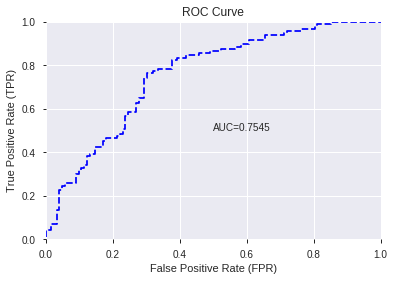

This function is available for GLM models only


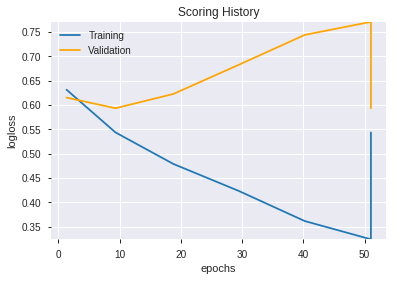

--2019-08-26 14:37:01--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.0.48
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.0.48|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_143004_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_143004_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_bd86',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'hour',
 'aroonup_30',
 'Volume',
 'STOCHRSI_fastk',
 'TRANGE',
 'aroondown_30',
 'weekday_name',
 'aroonup_8',
 'STOCHF_fastk',
 'SUB',
 'CDLCLOSINGMARUBOZU',
 'SAREXT',
 'DIV',
 'BETA_24',
 'BETA_20',
 'HT_TRENDMODE',
 'OBV',
 'HT_DCPERIOD',
 'STOCH_slowd',
 'aroonup_12',
 'HT_PHASOR_quadrature',
 'weekday',
 'BETA_12',
 'MFI_12',
 'CDLSHORTLINE',
 'CDLSPINNINGTOP',
 'MFI_8',
 'dayofweek',
 'CDLMARUBOZU',
 'ADOSC',
 'CDLHAMMER',
 'HT_PHASOR_inphase',
 'ADXR_14',
 'WILLR_8',
 'DX_8',
 'CDLDOJI',
 'ADX_8',
 'CDLLONGLEGGEDDOJI',
 'WILLR_12',
 'DX_24',
 'CDLENGULFING',
 'is_month_end',
 'DX_14',
 'CDLRICKSHAWMAN',
 'CDLBELTHOLD',
 'MFI_24',
 'DX_20',
 'CDLLONGLINE',
 'STOCHF_fastd']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_143710_model_1  0.747676  0.58795              0.299561  0.449799  0.202319

variable  relative_importance  scaled_importance  percentage
0                    BOP             0.424380           1.000000    0.120260
1           STOCHF_fastk             0.209467           0.493582    0.059358
2                   hour             0.198474           0.467680    0.056243
3           STOCHF_fastd             0.190051           0.447831    0.053856
4     CDLCLOSINGMARUBOZU             0.180051           0.424269    0.051023
5                    SUB             0.162781           0.383574    0.046129
6            STOCH_slowd             0.159835           0.376633    0.045294
7             aroonup_30             0.158400           0.373251    0.044887
8                BETA_20             0.154560           0.364201    0.043799
9              CDLHAMMER             0.120997           0.285115    0.034288
10                 ADX_8             0.115393           0.271910    0.032700
11               WILLR_8             0.108389           0.255404    0.030715
12               BETA_12             0.097354           0.229402    0.027588
13                 ADOSC             0.088106           0.207610    0.024967
14              WILLR_12             0.085456           0.201366    0.024216
15          CDLENGULFING             0.083507           0.196774    0.023664
16     HT_PHASOR_inphase             0.079723           0.187858    0.022592
17        STOCHRSI_fastk             0.074977           0.176673    0.021247
18          HT_TRENDMODE             0.068024           0.160289    0.019276
19                TRANGE             0.065715           0.154850    0.018622
20           HT_DCPERIOD             0.055099           0.129835    0.015614
21                   DIV             0.051830           0.122131    0.014688
22        CDLRICKSHAWMAN             0.051220           0.120694    0.014515
23                MFI_12             0.049897           0.117576    0.014140
24                 DX_24             0.049559           0.116780    0.014044
25                MFI_24             0.046690           0.110019    0.013231
26        CDLSPINNINGTOP             0.044532           0.104934    0.012619
27  HT_PHASOR_quadrature             0.041653           0.098151    0.011804
28          aroondown_30             0.037076           0.087366    0.010507
29           CDLLONGLINE             0.032014           0.075437    0.009072
30           CDLMARUBOZU             0.030446           0.071741    0.008628
31                 DX_14             0.028815           0.067900    0.008166
32          weekday_name             0.024662           0.058113    0.006989
33                 DX_20             0.018814           0.044334    0.005332
34     CDLLONGLEGGEDDOJI             0.017134           0.040374    0.004855
35               CDLDOJI             0.017122           0.040346    0.004852
36          is_month_end             0.017090           0.040271    0.004843
37               BETA_24             0.013644           0.032151    0.003866
38                  DX_8             0.013335           0.031423    0.003779
39            aroonup_12             0.012551           0.029576    0.003557
40                 MFI_8             0.010518           0.024785    0.002981
41             aroonup_8             0.009552           0.022509    0.002707
42               ADXR_14             0.007425           0.017496    0.002104
43             dayofweek             0.006660           0.015693    0.001887
44               weekday             0.006600           0.015551    0.001870
45                   OBV             0.005408           0.012742    0.001532
46                Volume             0.002774           0.006536    0.000786
47          CDLSHORTLINE             0.000514           0.001210    0.000146
48                SAREXT             0.000354           0.000834    0.000100
49           CDLBELTHOLD             0.000218           0.000514    0.000062

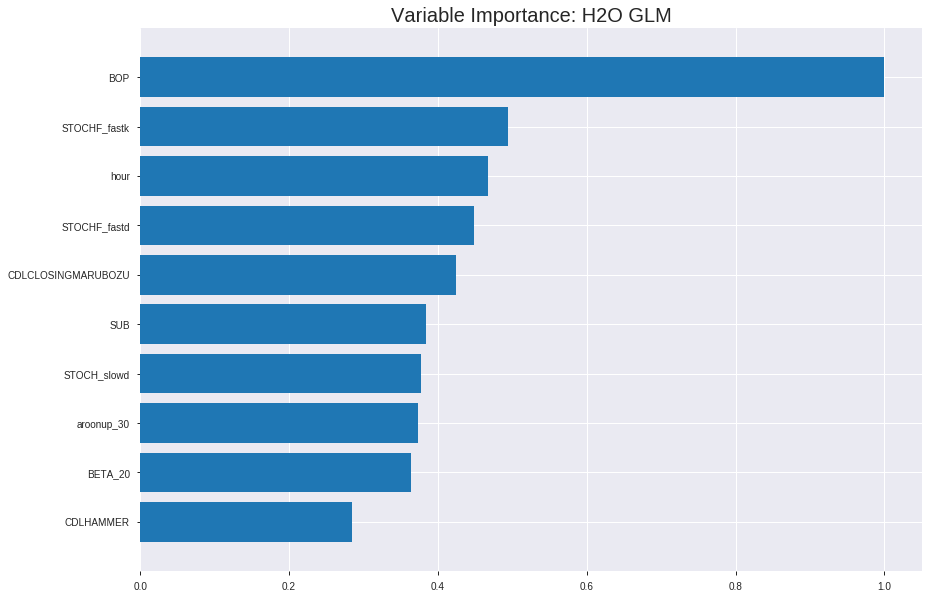

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_143710_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19958682175871695
RMSE: 0.44675140935280433
LogLoss: 0.5829036563112229
Null degrees of freedom: 1530
Residual degrees of freedom: 1480
Null deviance: 2115.4819722816574
Residual deviance: 1784.8509956249645
AIC: 1886.8509956249645
AUC: 0.7574750830564785
pr_auc: 0.7169141419369784
Gini: 0.514950166112957
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34235592202165593: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      375  442   0.541    (442.0/817.0)
1      80   634   0.112    (80.0/714.0)
Total  455  1076  0.341    (522.0/1531.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.342356     0.70838   267
max f2                       0.211999     0.823992  335
max f0point5                 0.502888     0.675523  181
max accuracy                 0.477881     0.698236  195
max precision                0.93796      1         0
max recall                   0.0881759    1         385
max specificity              0.93796      1         0
max absolute_mcc             0.477881     0.396899  195
max min_per_class_accuracy   0.483453     0.694678  192
max mean_per_class_accuracy  0.477881     0.698895  195

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 46.64 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104507                   0.870697           2.14426   2.14426            1                0.89914   1                           0.89914             0.022409        0.022409                   114.426   114.426
    2        0.0202482                   0.854366           2.00131   2.07509            0.933333         0.863036  0.967742                    0.88167             0.0196078       0.0420168                  100.131   107.509
    3        0.0300457                   0.821481           1.71541   1.9578             0.8              0.835612  0.913043                    0.866651            0.0168067       0.0588235                  71.5406   95.7801
    4        0.0404964                   0.79005            1.87623   1.93675            0.875            0.807206  0.903226                    0.85131             0.0196078       0.0784314                  87.6225   93.6749
    5        0.0502939                   0.775385           1.28655   1.81009            0.6              0.782656  0.844156                    0.837936            0.012605        0.0910364                  28.6555   81.0088
    6        0.100588                    0.724561           1.643     1.72655            0.766234         0.747013  0.805195                    0.792475            0.0826331       0.173669                   64.3003   72.6545
    7        0.150229                    0.683933           1.66462   1.70608            0.776316         0.70418   0.795652                    0.763299            0.0826331       0.256303                   66.4621   70.6083
    8        0.200523                    0.655884           1.36453   1.62042            0.636364         0.670662  0.7557                      0.740064            0.0686275       0.32493                    36.4528   62.0416
    9        0.300457                    0.595317           1.38746   1.54293            0.647059         0.624237  0.719565                    0.701539            0.138655        0.463585                   38.7461   54.2933
    10       0.400392                    0.540508           1.3314    1.49014            0.620915         0.568423  0.694943                    0.668314            0.133053        0.596639                   33.1402   49.0137
    11       0.500327                    0.474231           1.14921   1.42204            0.535948         0.507962  0.663185                    0.636286            0.114846        0.711485                   14.921    42.204
    12       0.600261                    0.412059           0.910959  1.33695            0.424837         0.440601  0.623504                    0.603707            0.0910364       0.802521                   -8.90408  33.6953
    13       0.700196                    0.344168           0.826871  1.26415            0.385621         0.37567   0.589552                    0.571161            0.0826331       0.885154                   -17.3129  26.4152
    14       0.800131                    0.269748           0.518546  1.17103            0.24183          0.306958  0.546122                    0.538163            0.0518207       0.936975                   -48.1454  17.1027
    15       0.900065                    0.188787           0.378398  1.08302            0.176471         0.229891  0.50508                     0.503935            0.0378151       0.97479                    -62.1602  8.30213
    16       1                           0.0179714          0.252266  1                  0.117647         0.127959  0.466362                    0.466362          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20347182156395627
RMSE: 0.45107850931290916
LogLoss: 0.5915054822705857
Null degrees of freedom: 437
Residual degrees of freedom: 387
Null deviance: 603.5241039768543
Residual deviance: 518.1588024690332
AIC: 620.1588024690332
AUC: 0.7467908249158249
pr_auc: 0.6598309622320359
Gini: 0.49358164983164987
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3284340046074769: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      109  131  0.5458   (131.0/240.0)
1      17   181  0.0859   (17.0/198.0)
Total  126  312  0.3379   (148.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.328434     0.709804  282
max f2                       0.277446     0.831866  313
max f0point5                 0.446877     0.660813  201
max accuracy                 0.446877     0.696347  201
max precision                0.860499     1         0
max recall                   0.074285     1         392
max specificity              0.860499     1         0
max absolute_mcc             0.346178     0.404995  272
max min_per_class_accuracy   0.460292     0.686869  192
max mean_per_class_accuracy  0.442762     0.699053  203

Gains/Lift Table: Avg response rate: 45.21 %, avg score: 44.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.830464           1.7697    1.7697             0.8              0.847443  0.8                         0.847443            0.020202        0.020202                   76.9697   76.9697
    2        0.0205479                   0.796244           1.65909   1.72054            0.75             0.816915  0.777778                    0.833875            0.0151515       0.0353535                  65.9091   72.0539
    3        0.0319635                   0.775207           0.884848  1.42208            0.4              0.783848  0.642857                    0.816008            0.010101        0.0454545                  -11.5152  42.2078
    4        0.0410959                   0.757182           2.21212   1.59764            1                0.759772  0.722222                    0.803511            0.020202        0.0656566                  121.212   59.7643
    5        0.0502283                   0.739182           1.65909   1.60882            0.75             0.751201  0.727273                    0.794               0.0151515       0.0808081                  65.9091   60.8815
    6        0.100457                    0.681414           1.60882   1.60882            0.727273         0.713519  0.727273                    0.75376             0.0808081       0.161616                   60.8815   60.8815
    7        0.150685                    0.646051           1.80992   1.67585            0.818182         0.662422  0.757576                    0.723314            0.0909091       0.252525                   80.9917   67.5849
    8        0.200913                    0.615171           1.20661   1.55854            0.545455         0.631434  0.704545                    0.700344            0.0606061       0.313131                   20.6612   55.854
    9        0.30137                     0.566988           1.40771   1.50826            0.636364         0.590624  0.681818                    0.66377             0.141414        0.454545                   40.7713   50.8264
    10       0.399543                    0.509856           1.13178   1.41576            0.511628         0.538992  0.64                        0.633111            0.111111        0.565657                   13.1783   41.5758
    11       0.5                         0.449511           1.45799   1.42424            0.659091         0.479938  0.643836                    0.602336            0.146465        0.712121                   45.7989   42.4242
    12       0.600457                    0.396526           0.955234  1.34578            0.431818         0.422644  0.608365                    0.572274            0.0959596       0.808081                   -4.47658  34.5777
    13       0.69863                     0.337601           0.87456   1.27956            0.395349         0.365288  0.578431                    0.543187            0.0858586       0.893939                   -12.544   27.956
    14       0.799087                    0.262503           0.603306  1.19455            0.272727         0.302184  0.54                        0.51289             0.0606061       0.954545                   -39.6694  19.4545
    15       0.899543                    0.160311           0.201102  1.0836             0.0909091        0.215249  0.489848                    0.479651            0.020202        0.974747                   -79.8898  8.36025
    16       1                           0.00017847         0.251377  1                  0.113636         0.1018    0.452055                    0.441693           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 14:37:11  0.000 sec   2            18        51            1.36497           1.35871
    2019-08-26 14:37:11  0.010 sec   4            11        51            1.3562            1.34878
    2019-08-26 14:37:11  0.022 sec   6            6.9       51            1.34387           1.33499
    2019-08-26 14:37:11  0.038 sec   8            4.3       51            1.32755           1.31702
    2019-08-26 14:37:11  0.057 sec   10           2.7       51            1.30745           1.29544
    2019-08-26 14:37:11  0.076 sec   12           1.7       51            1.28473           1.27182
    2019-08-26 14:37:11  0.091 sec   14           1         51            1.26123           1.24843
    2019-08-26 14:37:11  0.104 sec   16           0.64      51            1.23898           1.22752
    2019-08-26 14:37:11  0.117 sec   18           0.4       51            1.21948           1.21063
    2019-08-26 14:37:11  0.130 sec   20           0.25      51            1.20333           1.19824
    2019-08-26 14:37:11  0.142 sec   22           0.15      51            1.19037           1.19003
    2019-08-26 14:37:11  0.152 sec   24           0.095     51            1.18009           1.18529
    2019-08-26 14:37:11  0.162 sec   26           0.059     51            1.17202           1.1832
    2019-08-26 14:37:11  0.174 sec   28           0.037     51            1.16581           1.18301
    2019-08-26 14:37:11  0.198 sec   30           0.023     51            1.16116           1.18389
    2019-08-26 14:37:11  0.214 sec   32           0.014     51            1.15772           1.18535
    2019-08-26 14:37:11  0.226 sec   34           0.0088    51            1.15508           1.18786
    2019-08-26 14:37:11  0.236 sec   36           0.0055    51            1.15286           1.19432
    2019-08-26 14:37:11  0.248 sec   38           0.0034    51            1.15079           1.21278

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6940639269406392)

('F1', 0.7083333333333333)

('auc', 0.747676187257056)

('logloss', 0.587949607497291)

('mean_per_class_error', 0.29453270238296436)

('rmse', 0.4497993492350116)

('mse', 0.2023194545722399)

glm prediction progress: |████████████████████████████████████████████████| 100%


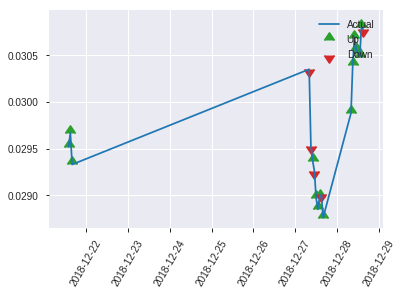


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2023194545722399
RMSE: 0.4497993492350116
LogLoss: 0.587949607497291
Null degrees of freedom: 218
Residual degrees of freedom: 168
Null deviance: 301.2230274583454
Residual deviance: 257.5219280838135
AIC: 359.5219280838135
AUC: 0.747676187257056
pr_auc: 0.6759764659495366
Gini: 0.49535237451411196
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3853214333144795: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      64   58   0.4754   (58.0/122.0)
1      12   85   0.1237   (12.0/97.0)
Total  76   143  0.3196   (70.0/219.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.385321     0.708333  142
max f2                       0.228347     0.824653  187
max f0point5                 0.450543     0.649241  123
max accuracy                 0.450543     0.694064  123
max precision                0.868952     1         0
max recall                   0.143098     1         203
max specificity              0.868952     1         0
max absolute_mcc             0.413292     0.41979   134
max min_per_class_accuracy   0.482151     0.672131  105
max mean_per_class_accuracy  0.413292     0.705467  134

Gains/Lift Table: Avg response rate: 44.29 %, avg score: 45.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136986                   0.844991           1.50515   1.50515            0.666667         0.854892  0.666667                    0.854892            0.0206186       0.0206186                  50.5155   50.5155
    2        0.0228311                   0.800906           2.25773   1.80619            1                0.824493  0.8                         0.842732            0.0206186       0.0412371                  125.773   80.6186
    3        0.0319635                   0.783671           2.25773   1.9352             1                0.79021   0.857143                    0.827726            0.0206186       0.0618557                  125.773   93.5199
    4        0.0410959                   0.761306           2.25773   2.00687            1                0.773965  0.888889                    0.815779            0.0206186       0.0824742                  125.773   100.687
    5        0.0502283                   0.748876           2.25773   2.05248            1                0.754126  0.909091                    0.804569            0.0206186       0.103093                   125.773   105.248
    6        0.100457                    0.689964           1.43674   1.74461            0.636364         0.718516  0.772727                    0.761543            0.0721649       0.175258                   43.6739   74.4611
    7        0.150685                    0.668918           1.43674   1.64199            0.636364         0.676337  0.727273                    0.733141            0.0721649       0.247423                   43.6739   64.1987
    8        0.200913                    0.633987           1.84724   1.6933             0.818182         0.653002  0.75                        0.713106            0.0927835       0.340206                   84.7235   69.3299
    9        0.30137                     0.577999           1.23149   1.53936            0.545455         0.605373  0.681818                    0.677195            0.123711        0.463918                   23.149    53.9363
    10       0.401826                    0.520232           1.23149   1.46239            0.545455         0.549646  0.647727                    0.645308            0.123711        0.587629                   23.149    46.2395
    11       0.502283                    0.47915            1.02624   1.37516            0.454545         0.494471  0.609091                    0.61514             0.103093        0.690722                   2.62418   37.5164
    12       0.598174                    0.422267           1.29013   1.36153            0.571429         0.452662  0.603053                    0.589094            0.123711        0.814433                   29.0133   36.1533
    13       0.69863                     0.355694           0.615745  1.2543             0.272727         0.387262  0.555556                    0.560073            0.0618557       0.876289                   -38.4255  25.4296
    14       0.799087                    0.284332           0.307873  1.13532            0.136364         0.320072  0.502857                    0.529901            0.0309278       0.907216                   -69.2127  13.5317
    15       0.899543                    0.190684           0.820993  1.10021            0.363636         0.234852  0.48731                     0.496951            0.0824742       0.989691                   -17.9007  10.0215
    16       1                           0.028362           0.102624  1                  0.0454545        0.121323  0.442922                    0.459217         

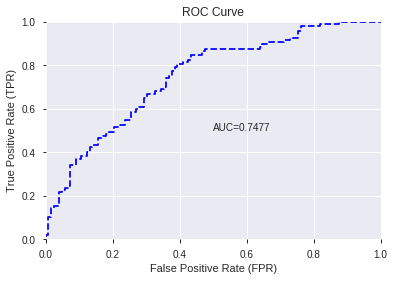

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


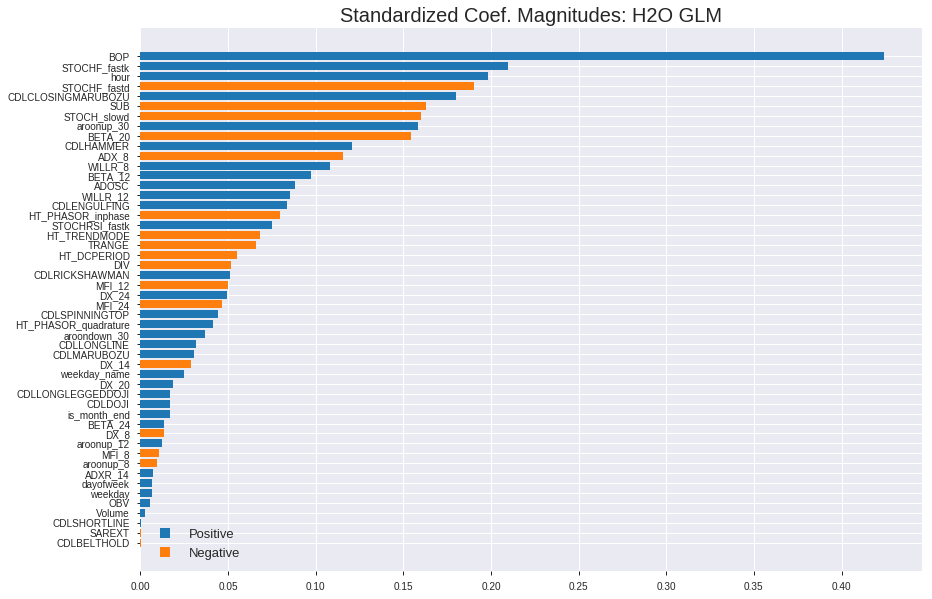

'log_likelihood'
--2019-08-26 14:37:17--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.112.160
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.112.160|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_143710_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_143710_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_bd86',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'STOCHF_fastk',
 'hour',
 'STOCHF_fastd',
 'CDLCLOSINGMARUBOZU',
 'SUB',
 'STOCH_slowd',
 'aroonup_30',
 'BETA_20',
 'CDLHAMMER',
 'ADX_8',
 'WILLR_8',
 'BETA_12',
 'ADOSC',
 'WILLR_12',
 'CDLENGULFING',
 'HT_PHASOR_inphase',
 'STOCHRSI_fastk',
 'HT_TRENDMODE',
 'TRANGE',
 'HT_DCPERIOD',
 'DIV',
 'CDLRICKSHAWMAN',
 'MFI_12',
 'DX_24',
 'MFI_24',
 'CDLSPINNINGTOP',
 'HT_PHASOR_quadrature',
 'aroondown_30',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'DX_14',
 'weekday_name',
 'DX_20',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI',
 'is_month_end',
 'BETA_24',
 'DX_8',
 'aroonup_12',
 'MFI_8',
 'aroonup_8',
 'ADXR_14',
 'dayofweek',
 'weekday',
 'OBV',
 'Volume',
 'CDLSHORTLINE',
 'SAREXT',
 'CDLBELTHOLD']

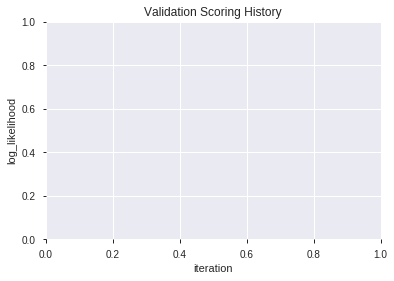

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190826_143727  0.764239  0.570837              0.283167  0.441691  0.195091
1  XGBoost_grid_1_AutoML_20190826_143727_model_5  0.752915  0.585853              0.282364  0.448248  0.200926
2  XGBoost_grid_1_AutoML_20190826_143727_model_3  0.749113  0.584113              0.295589  0.448310  0.200982
3  XGBoost_grid_1_AutoML_20190826_143727_model_6  0.747761  0.582911              0.284350  0.447588  0.200335
4  XGBoost_grid_1_AutoML_20190826_143727_model_2  0.747676  0.586970              0.302603  0.449178  0.201761
5  XGBoost_grid_1_AutoML_20190826_143727_model_7  0.735170  0.594088              0.317940  0.454226  0.206321
6  XGBoost_grid_1_AutoML_20190826_143727_model_1  0.731198  0.595128              0.320982  0.454515  0.206584
7  XGBoost_grid_1_AutoML_20190826_143727_model_4  0.730691  0.597637              0.332221  0.455263  0.207264
8               XGBoost_1_AutoML_20190826_143727  0.723678  0.601998              0.322165  0.458607  0.210320
9               XGBoost_2_AutoML_20190826_143727  0.722748  0.602398              0.304842  0.458102  0.209858

variable  relative_importance  scaled_importance  percentage
0                    BOP          1431.951294           1.000000    0.179635
1           STOCHF_fastk           614.612061           0.429213    0.077102
2                    DIV           453.356445           0.316600    0.056872
3                   hour           438.367249           0.306133    0.054992
4         STOCHRSI_fastk           392.218536           0.273905    0.049203
5                    SUB           277.170746           0.193562    0.034770
6   HT_PHASOR_quadrature           252.132263           0.176076    0.031629
7                BETA_20           244.623215           0.170832    0.030687
8                  ADX_8           239.072357           0.166956    0.029991
9            STOCH_slowd           226.509949           0.158183    0.028415
10          STOCHF_fastd           223.752319           0.156257    0.028069
11                 ADOSC           183.851746           0.128392    0.023064
12                Volume           178.619339           0.124738    0.022407
13                MFI_12           175.848114           0.122803    0.022060
14               WILLR_8           166.482254           0.116263    0.020885
15                 DX_14           148.550217           0.103740    0.018635
16             aroonup_8           147.876190           0.103269    0.018551
17               BETA_24           146.001892           0.101960    0.018316
18                TRANGE           145.639648           0.101707    0.018270
19                SAREXT           132.671310           0.092651    0.016643
20               ADXR_14           130.632858           0.091227    0.016388
21     HT_PHASOR_inphase           127.329681           0.088920    0.015973
22            aroonup_30           124.245956           0.086767    0.015586
23               BETA_12           115.982758           0.080996    0.014550
24              WILLR_12           113.058830           0.078954    0.014183
25           HT_DCPERIOD           112.819725           0.078787    0.014153
26                   OBV           109.374474           0.076381    0.013721
27                  DX_8           106.604836           0.074447    0.013373
28                 MFI_8            92.728546           0.064757    0.011633
29                MFI_24            85.463081           0.059683    0.010721
30                 DX_24            84.453064           0.058978    0.010594
31          aroondown_30            79.870804           0.055778    0.010020
32                 DX_20            68.954079           0.048154    0.008650
33            aroonup_12            63.786034           0.044545    0.008002
34           CDLLONGLINE            63.285164           0.044195    0.007939
35    CDLCLOSINGMARUBOZU            61.692371           0.043083    0.007739
36             dayofweek            36.227398           0.025299    0.004545
37          weekday_name            35.637920           0.024888    0.004471
38               weekday            32.563423           0.022741    0.004085
39               CDLDOJI            28.667076           0.020020    0.003596
40             CDLHAMMER            28.557457           0.019943    0.003582
41        CDLSPINNINGTOP            21.926689           0.015312    0.002751
42          CDLSHORTLINE            17.457455           0.012191    0.002190
43          HT_TRENDMODE             5.807414           0.004056    0.000729
44     CDLLONGLEGGEDDOJI             5.029599           0.003512    0.000631

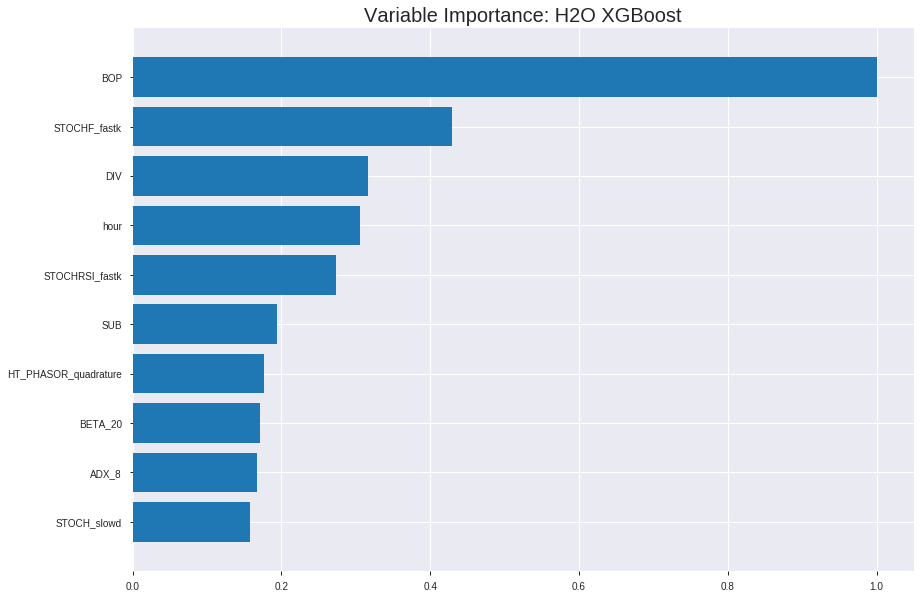

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190826_143727


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.12846981595204698
RMSE: 0.35842686276567914
LogLoss: 0.4219011121646133
Mean Per-Class Error: 0.14073058844100683
AUC: 0.9377324981400149
pr_auc: 0.9316813081472977
Gini: 0.8754649962800298
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4647222995758057: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      666  151  0.1848   (151.0/817.0)
1      69   645  0.0966   (69.0/714.0)
Total  735  796  0.1437   (220.0/1531.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.464722     0.854305  206
max f2                       0.358859     0.899844  255
max f0point5                 0.614665     0.87325   137
max accuracy                 0.488404     0.857609  195
max precision                0.916871     1         0
max recall                   0.177976     1         340
max specificity              0.916871     1         0
max absolute_mcc             0.464722     0.717481  206
max min_per_class_accuracy   0.50403      0.851541  188
max mean_per_class_accuracy  0.464722     0.859269  206

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 46.76 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104507                   0.890244           2.14426    2.14426            1                0.904517  1                           0.904517            0.022409        0.022409                   114.426   114.426
    2        0.0202482                   0.869068           2.14426    2.14426            1                0.878231  1                           0.891798            0.0210084       0.0434174                  114.426   114.426
    3        0.0300457                   0.854913           2.14426    2.14426            1                0.8623    1                           0.882179            0.0210084       0.0644258                  114.426   114.426
    4        0.0404964                   0.843207           2.14426    2.14426            1                0.849296  1                           0.873693            0.022409        0.0868347                  114.426   114.426
    5        0.0502939                   0.827271           2.14426    2.14426            1                0.833251  1                           0.865815            0.0210084       0.107843                   114.426   114.426
    6        0.100588                    0.76814            2.14426    2.14426            1                0.794161  1                           0.829988            0.107843        0.215686                   114.426   114.426
    7        0.150229                    0.723886           2.11604    2.13493            0.986842         0.744432  0.995652                    0.801717            0.105042        0.320728                   111.604   113.493
    8        0.200523                    0.692008           2.06072    2.11632            0.961039         0.707779  0.986971                    0.778156            0.103641        0.42437                    106.072   111.632
    9        0.300457                    0.632499           1.93404    2.05569            0.901961         0.665034  0.958696                    0.740531            0.193277        0.617647                   93.4036   105.569
    10       0.400392                    0.562076           1.51359    1.92039            0.705882         0.597214  0.895595                    0.70476             0.151261        0.768908                   51.3594   92.0387
    11       0.500327                    0.480089           1.12118    1.76075            0.522876         0.521758  0.821149                    0.668207            0.112045        0.880952                   12.118    76.0755
    12       0.600261                    0.396735           0.644679   1.57494            0.300654         0.437872  0.734494                    0.62986             0.0644258       0.945378                   -35.5321  57.4944
    13       0.700196                    0.306123           0.364384   1.40217            0.169935         0.347702  0.653918                    0.589589            0.0364146       0.981793                   -63.5616  40.2169
    14       0.800131                    0.217548           0.112118   1.24104            0.0522876        0.256545  0.578776                    0.547993            0.0112045       0.992997                   -88.7882  24.1044
    15       0.900065                    0.148088           0.0700738  1.11103            0.0326797        0.182632  0.518142                    0.507426            0.0070028       1                          -92.9926  11.103
    16       1                           0.049173           0          1                  0                0.108794  0.466362                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19395293831618257
RMSE: 0.4404008836460056
LogLoss: 0.5700691071812456
Mean Per-Class Error: 0.2586489898989899
AUC: 0.7668560606060606
pr_auc: 0.667232465653642
Gini: 0.5337121212121212
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41153743863105774: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      151  89   0.3708   (89.0/240.0)
1      29   169  0.1465   (29.0/198.0)
Total  180  258  0.2694   (118.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.411537     0.741228  235
max f2                       0.291274     0.841584  292
max f0point5                 0.411744     0.687398  234
max accuracy                 0.411744     0.730594  234
max precision                0.86578      1         0
max recall                   0.0928903    1         385
max specificity              0.86578      1         0
max absolute_mcc             0.411537     0.488283  235
max min_per_class_accuracy   0.480763     0.6875    195
max mean_per_class_accuracy  0.411537     0.741351  235

Gains/Lift Table: Avg response rate: 45.21 %, avg score: 44.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.851146           0.884848  0.884848           0.4              0.856722  0.4                         0.856722            0.010101        0.010101                   -11.5152  -11.5152
    2        0.0205479                   0.831307           1.65909   1.22896            0.75             0.840547  0.555556                    0.849533            0.0151515       0.0252525                  65.9091   22.8956
    3        0.0319635                   0.811932           1.7697    1.42208            0.8              0.819261  0.642857                    0.838722            0.020202        0.0454545                  76.9697   42.2078
    4        0.0410959                   0.797076           1.65909   1.47475            0.75             0.803674  0.666667                    0.830933            0.0151515       0.0606061                  65.9091   47.4747
    5        0.0502283                   0.789288           2.21212   1.60882            1                0.793573  0.727273                    0.824141            0.020202        0.0808081                  121.212   60.8815
    6        0.100457                    0.730618           1.60882   1.60882            0.727273         0.753802  0.727273                    0.788971            0.0808081       0.161616                   60.8815   60.8815
    7        0.150685                    0.686363           1.91047   1.70937            0.863636         0.702328  0.772727                    0.76009             0.0959596       0.257576                   91.0468   70.9366
    8        0.200913                    0.650114           1.40771   1.63395            0.636364         0.663961  0.738636                    0.736058            0.0707071       0.328283                   40.7713   63.3953
    9        0.30137                     0.587302           1.30716   1.52502            0.590909         0.61891   0.689394                    0.697009            0.131313        0.459596                   30.7163   52.5023
    10       0.399543                    0.527248           1.13178   1.4284             0.511628         0.554618  0.645714                    0.662021            0.111111        0.570707                   13.1783   42.8398
    11       0.5                         0.469639           1.45799   1.43434            0.659091         0.5012    0.648402                    0.62971             0.146465        0.717172                   45.7989   43.4343
    12       0.600457                    0.388188           1.40771   1.42989            0.636364         0.437835  0.646388                    0.597609            0.141414        0.858586                   40.7713   42.9888
    13       0.69863                     0.31267            0.668781  1.32294            0.302326         0.354429  0.598039                    0.563437            0.0656566       0.924242                   -33.1219  32.2935
    14       0.799087                    0.210877           0.251377  1.18823            0.113636         0.262003  0.537143                    0.525542            0.0252525       0.949495                   -74.8623  18.8225
    15       0.899543                    0.140467           0.301653  1.08922            0.136364         0.180071  0.492386                    0.486962            0.030303        0.979798                   -69.8347  8.9217
    16       1                           0.0554159          0.201102  1                  0.0909091        0.102252  0.452055                    0.448315         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:37:31  0.004 sec   0                  0.5              0.693147            0.5             0                  1                0.533638                         0.5                0.693147              0.5               0                    1                  0.547945
    2019-08-26 14:37:31  0.119 sec   5                  0.474647         0.643425            0.836968        0.79974            2.14426          0.259961                         0.480563           0.654774              0.752315          0.681489             1.7697             0.319635
    2019-08-26 14:37:31  0.176 sec   10                 0.455989         0.607513            0.851418        0.837042           2.14426          0.229915                         0.468484           0.630961              0.758575          0.670745             1.7697             0.296804
    2019-08-26 14:37:31  0.239 sec   15                 0.438581         0.574184            0.867741        0.853614           2.14426          0.225996                         0.459358           0.612434              0.756923          0.665192             1.32727            0.296804
    2019-08-26 14:37:31  0.301 sec   20                 0.425761         0.549561            0.878788        0.865768           2.14426          0.205748                         0.453459           0.600147              0.758575          0.673648             1.7697             0.289954
    2019-08-26 14:37:31  0.361 sec   25                 0.415264         0.529208            0.886875        0.873431           2.14426          0.209014                         0.450109           0.592706              0.759522          0.66954              1.7697             0.308219
    2019-08-26 14:37:31  0.431 sec   30                 0.405021         0.509538            0.896325        0.885943           2.14426          0.201176                         0.447967           0.58782               0.760459          0.667471             1.7697             0.285388
    2019-08-26 14:37:31  0.491 sec   35                 0.397826         0.495235            0.900349        0.889183           2.14426          0.196604                         0.446924           0.585248              0.757239          0.662136             1.32727            0.285388
    2019-08-26 14:37:31  0.557 sec   40                 0.390974         0.481857            0.906313        0.897306           2.14426          0.179621                         0.445743           0.58218               0.757207          0.665328             1.7697             0.283105
    2019-08-26 14:37:31  0.618 sec   45                 0.385321         0.47092             0.911264        0.90305            2.14426          0.180274                         0.443933           0.578262              0.761216          0.664032             1.7697             0.292237
    2019-08-26 14:37:31  0.689 sec   50                 0.379552         0.460024            0.916061        0.907311           2.14426          0.175702                         0.442666           0.575446              0.763721          0.669761             1.7697             0.276256
    2019-08-26 14:37:31  0.754 sec   55                 0.374281         0.450396            0.921809        0.913751           2.14426          0.158067                         0.441688           0.57353               0.765941          0

Variable Importances: 


variable           relative_importance    scaled_importance      percentage
-----------------  ---------------------  ---------------------  ---------------------
BOP                1431.9512939453125     1.0                    0.17963467229742416
STOCHF_fastk       614.612060546875       0.4292129649560187     0.07710153030568022
DIV                453.3564453125         0.3166004648547872     0.05687242075340186
hour               438.36724853515625     0.30613279263665927    0.05499206388478159
STOCHRSI_fastk     392.2185363769531      0.2739049421829932     0.0492028245296869
---                ---                    ---                    ---
CDLHAMMER          28.557456970214844     0.019943036534108175   0.0035824608324200803
CDLSPINNINGTOP     21.92668914794922      0.015312454579049822   0.002750647760376807
CDLSHORTLINE       17.457454681396484     0.012191374633488896   0.0021899935871419075
HT_TRENDMODE       5.8074140548706055     0.004055594683580345   0.000728525421956131
CDLLONGLEGGEDDOJI  5.029598712921143      0.0035124090701881285  0.0006309504522977447


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7123287671232876)

('F1', 0.7203389830508475)

('auc', 0.7642386344431299)

('logloss', 0.5708369983619938)

('mean_per_class_error', 0.280378570221396)

('rmse', 0.4416911342782815)

('mse', 0.1950910581000349)

xgboost prediction progress: |████████████████████████████████████████████| 100%


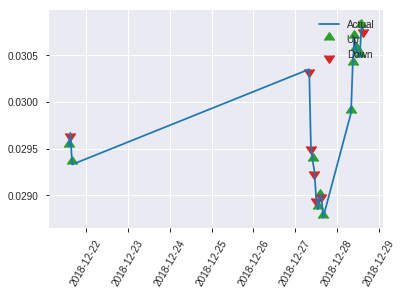


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.1950910581000349
RMSE: 0.4416911342782815
LogLoss: 0.5708369983619938
Mean Per-Class Error: 0.280378570221396
AUC: 0.7642386344431299
pr_auc: 0.6734409840454831
Gini: 0.5284772688862598
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40428465604782104: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      68   54   0.4426   (54.0/122.0)
1      12   85   0.1237   (12.0/97.0)
Total  80   139  0.3014   (66.0/219.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.404285     0.720339  138
max f2                       0.180755     0.83045   189
max f0point5                 0.499615     0.671078  107
max accuracy                 0.499615     0.712329  107
max precision                0.871382     1         0
max recall                   0.120872     1         203
max specificity              0.871382     1         0
max absolute_mcc             0.404285     0.447372  138
max min_per_class_accuracy   0.507345     0.704918  104
max mean_per_class_accuracy  0.472154     0.719621  117

Gains/Lift Table: Avg response rate: 44.29 %, avg score: 46.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136986                   0.833424           2.25773   2.25773            1                0.851959  1                           0.851959            0.0309278       0.0309278                  125.773   125.773
    2        0.0228311                   0.821758           1.12887   1.80619            0.5              0.825292  0.8                         0.841292            0.0103093       0.0412371                  12.8866   80.6186
    3        0.0319635                   0.811191           2.25773   1.9352             1                0.81394   0.857143                    0.833477            0.0206186       0.0618557                  125.773   93.5199
    4        0.0410959                   0.803406           1.12887   1.75601            0.5              0.808577  0.777778                    0.827944            0.0103093       0.0721649                  12.8866   75.6014
    5        0.0502283                   0.79561            2.25773   1.84724            1                0.799206  0.818182                    0.822719            0.0206186       0.0927835                  125.773   84.7235
    6        0.100457                    0.745136           1.43674   1.64199            0.636364         0.764607  0.727273                    0.793663            0.0721649       0.164948                   43.6739   64.1987
    7        0.150685                    0.694005           1.84724   1.7104             0.818182         0.71459   0.757576                    0.767305            0.0927835       0.257732                   84.7235   71.0403
    8        0.200913                    0.644722           1.02624   1.53936            0.454545         0.664436  0.681818                    0.741588            0.0515464       0.309278                   2.62418   53.9363
    9        0.30137                     0.603989           1.64199   1.57357            0.727273         0.62492   0.69697                     0.702699            0.164948        0.474227                   64.1987   57.3571
    10       0.401826                    0.559211           1.33411   1.51371            0.590909         0.581982  0.670455                    0.672519            0.134021        0.608247                   33.4114   51.3707
    11       0.502283                    0.496232           1.23149   1.45726            0.545455         0.522646  0.645455                    0.642545            0.123711        0.731959                   23.149    45.7263
    12       0.598174                    0.430188           1.07511   1.396              0.47619          0.459866  0.618321                    0.61326             0.103093        0.835052                   7.51105   39.6002
    13       0.69863                     0.333989           0.615745  1.28381            0.272727         0.385241  0.568627                    0.580473            0.0618557       0.896907                   -38.4255  28.3808
    14       0.799087                    0.237471           0.410497  1.17402            0.181818         0.293826  0.52                        0.544438            0.0412371       0.938144                   -58.9503  17.4021
    15       0.899543                    0.146985           0.513121  1.10021            0.227273         0.193415  0.48731                     0.505237            0.0515464       0.989691                   -48.6879  10.0215
    16       1                           0.0575387          0.102624  1                  0.0454545        0.103409  0.442922                    0.464871         

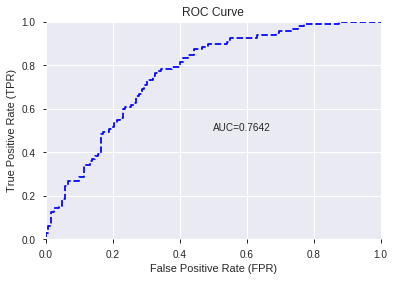

This function is available for GLM models only


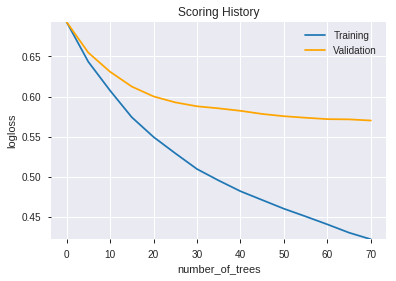

--2019-08-26 14:37:48--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.92.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.92.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190826_143727',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190826_143727',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_bd86',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_66_sid_bd86',
   'type

['BOP',
 'STOCHF_fastk',
 'DIV',
 'hour',
 'STOCHRSI_fastk',
 'SUB',
 'HT_PHASOR_quadrature',
 'BETA_20',
 'ADX_8',
 'STOCH_slowd',
 'STOCHF_fastd',
 'ADOSC',
 'Volume',
 'MFI_12',
 'WILLR_8',
 'DX_14',
 'aroonup_8',
 'BETA_24',
 'TRANGE',
 'SAREXT',
 'ADXR_14',
 'HT_PHASOR_inphase',
 'aroonup_30',
 'BETA_12',
 'WILLR_12',
 'HT_DCPERIOD',
 'OBV',
 'DX_8',
 'MFI_8',
 'MFI_24',
 'DX_24',
 'aroondown_30',
 'DX_20',
 'aroonup_12',
 'CDLLONGLINE',
 'CDLCLOSINGMARUBOZU',
 'dayofweek',
 'weekday_name',
 'weekday',
 'CDLDOJI',
 'CDLHAMMER',
 'CDLSPINNINGTOP',
 'CDLSHORTLINE',
 'HT_TRENDMODE',
 'CDLLONGLEGGEDDOJI']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12 938] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


39

['hour',
 'BOP',
 'CCI_8',
 'CMO_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'RSI_12',
 'WILLR_12',
 'CCI_14',
 'CMO_14',
 'RSI_14',
 'WILLR_14',
 'CCI_20',
 'CMO_20',
 'MOM_20',
 'ROC_20',
 'ROCP_20',
 'ROCR_20',
 'ROCR100_20',
 'RSI_20',
 'WILLR_20',
 'CMO_24',
 'RSI_24',
 'WILLR_24',
 'WILLR_30',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'ULTOSC',
 'ADOSC',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLENGULFING',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_143800_model_8  0.736437  0.594624              0.327193  0.452841  0.205065
1  DeepLearning_grid_1_AutoML_20190826_143800_model_5  0.731874  0.595245              0.348614  0.456333  0.208240
2  DeepLearning_grid_1_AutoML_20190826_143800_model_6  0.730945  0.588619              0.323221  0.451606  0.203948
3  DeepLearning_grid_1_AutoML_20190826_143800_model_9  0.725537  0.600865              0.348487  0.456186  0.208105
4               DeepLearning_1_AutoML_20190826_143800  0.696806  0.683372              0.336573  0.484798  0.235029
5  DeepLearning_grid_1_AutoML_20190826_143800_model_7  0.694524  0.624675              0.340417  0.470357  0.221236
6  DeepLearning_grid_1_AutoML_20190826_143800_model_3  0.689961  0.665458              0.356811  0.478895  0.229340
7  DeepLearning_grid_1_AutoML_20190826_143800_model_4  0.659118  0.780353              0.402822  0.510213  0.260318
8  DeepLearning_grid_1_AutoML_20190826_143800_model_2  0.655484  0.668061              0.394752  0.486573  0.236753
9  DeepLearning_grid_1_AutoML_20190826_143800_model_1  0.631148  0.834228              0.425553  0.519985  0.270385

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.057383
1                 hour             0.678358           0.678358    0.038926
2   CDLCLOSINGMARUBOZU             0.676815           0.676815    0.038838
3                  SUB             0.584314           0.584314    0.033530
4         STOCHF_fastk             0.556814           0.556814    0.031952
5                  DIV             0.555732           0.555732    0.031889
6               TRANGE             0.508164           0.508164    0.029160
7               CCI_14             0.490446           0.490446    0.028143
8       STOCHRSI_fastk             0.478012           0.478012    0.027430
9          CDLMARUBOZU             0.463169           0.463169    0.026578
10        CDLENGULFING             0.457162           0.457162    0.026233
11         CDLLONGLINE             0.453158           0.453158    0.026003
12              CCI_12             0.444226           0.444226    0.025491
13            WILLR_30             0.431397           0.431397    0.024755
14            WILLR_24             0.427076           0.427076    0.024507
15               CCI_8             0.423423           0.423423    0.024297
16             WILLR_8             0.422927           0.422927    0.024269
17            WILLR_20             0.410994           0.410994    0.023584
18            WILLR_14             0.405494           0.405494    0.023268
19            WILLR_12             0.403402           0.403402    0.023148
20              CCI_20             0.400523           0.400523    0.022983
21         CDLBELTHOLD             0.399522           0.399522    0.022926
22               ADOSC             0.398620           0.398620    0.022874
23              ULTOSC             0.390509           0.390509    0.022409
24              RSI_12             0.387528           0.387528    0.022237
25              CMO_24             0.382740           0.382740    0.021963
26             ROCP_20             0.380587           0.380587    0.021839
27              RSI_20             0.379169           0.379169    0.021758
28              RSI_24             0.378101           0.378101    0.021697
29             ROCR_20             0.376336           0.376336    0.021595
30              CMO_14             0.371638           0.371638    0.021326
31              ROC_20             0.370229           0.370229    0.021245
32              MOM_20             0.368325           0.368325    0.021136
33               RSI_8             0.367037           0.367037    0.021062
34              CMO_12             0.367015           0.367015    0.021060
35          ROCR100_20             0.362858           0.362858    0.020822
36               CMO_8             0.361215           0.361215    0.020728
37              RSI_14             0.357124           0.357124    0.020493
38              CMO_20             0.356663           0.356663    0.020466

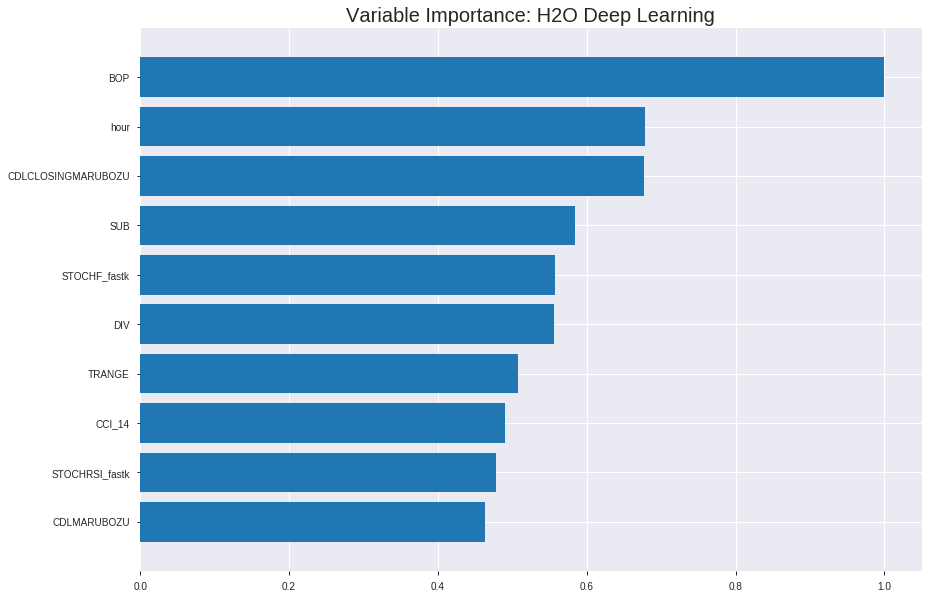

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_143800_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.20258038332778852
RMSE: 0.4500893059469293
LogLoss: 0.5904355144338029
Mean Per-Class Error: 0.2985207546911053
AUC: 0.7547665332963052
pr_auc: 0.7073900754279663
Gini: 0.5095330665926103
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4130074993309181: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      482  335  0.41     (335.0/817.0)
1      139  575  0.1947   (139.0/714.0)
Total  621  910  0.3096   (474.0/1531.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.413007     0.708128  244
max f2                       0.241731     0.828756  341
max f0point5                 0.487742     0.676241  196
max accuracy                 0.487742     0.698236  196
max precision                0.957392     1         0
max recall                   0.162736     1         384
max specificity              0.957392     1         0
max absolute_mcc             0.423721     0.406459  237
max min_per_class_accuracy   0.473267     0.692778  204
max mean_per_class_accuracy  0.423721     0.701479  237

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 46.23 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104507                   0.914355           2.01024   2.01024            0.9375           0.933939  0.9375                      0.933939            0.0210084       0.0210084                  101.024   101.024
    2        0.0202482                   0.858543           2.00131   2.00592            0.933333         0.886221  0.935484                    0.910849            0.0196078       0.0406162                  100.131   100.592
    3        0.0300457                   0.800564           1.85836   1.9578             0.866667         0.827902  0.913043                    0.883801            0.0182073       0.0588235                  85.8357   95.7801
    4        0.0404964                   0.774463           1.87623   1.93675            0.875            0.790026  0.903226                    0.859601            0.0196078       0.0784314                  87.6225   93.6749
    5        0.0502939                   0.754085           1.28655   1.81009            0.6              0.765698  0.844156                    0.841309            0.012605        0.0910364                  28.6555   81.0088
    6        0.100588                    0.692044           1.53161   1.67085            0.714286         0.71973   0.779221                    0.780519            0.0770308       0.168067                   53.1613   67.085
    7        0.150229                    0.656284           1.52355   1.62218            0.710526         0.673258  0.756522                    0.745076            0.0756303       0.243697                   52.3552   62.2178
    8        0.200523                    0.615906           1.42022   1.57152            0.662338         0.635597  0.732899                    0.717618            0.0714286       0.315126                   42.0223   57.1524
    9        0.300457                    0.551334           1.47155   1.53827            0.686275         0.585322  0.717391                    0.673615            0.147059        0.462185                   47.1549   53.8272
    10       0.400392                    0.515775           1.31739   1.48314            0.614379         0.533203  0.69168                     0.638569            0.131653        0.593838                   31.7387   48.3141
    11       0.500327                    0.467021           1.17724   1.42204            0.54902          0.493742  0.663185                    0.609642            0.117647        0.711485                   17.724    42.204
    12       0.600261                    0.409649           0.953003  1.34395            0.444444         0.436661  0.626768                    0.580843            0.0952381       0.806723                   -4.69966  34.3953
    13       0.700196                    0.35078            0.644679  1.24415            0.300654         0.378714  0.580224                    0.551994            0.0644258       0.871148                   -35.5321  24.415
    14       0.800131                    0.289502           0.644679  1.16928            0.300654         0.32326   0.545306                    0.523426            0.0644258       0.935574                   -35.5321  16.9277
    15       0.900065                    0.220467           0.406428  1.08458            0.189542         0.254793  0.505806                    0.493599            0.0406162       0.97619                    -59.3572  8.45774
    16       1                           0.0916485          0.238251  1                  0.111111         0.180154  0.466362                    0.462275            



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20385439404314035
RMSE: 0.45150237434939405
LogLoss: 0.5945232036367735
Mean Per-Class Error: 0.28320707070707063
AUC: 0.75440867003367
pr_auc: 0.6602810667368487
Gini: 0.5088173400673399
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40038458561922713: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      129  111  0.4625   (111.0/240.0)
1      29   169  0.1465   (29.0/198.0)
Total  158  280  0.3196   (140.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.400385     0.707113  255
max f2                       0.27513      0.829713  329
max f0point5                 0.487058     0.689135  178
max accuracy                 0.487058     0.719178  178
max precision                0.95322      1         0
max recall                   0.146216     1         390
max specificity              0.95322      1         0
max absolute_mcc             0.487058     0.433399  178
max min_per_class_accuracy   0.470177     0.704167  190
max mean_per_class_accuracy  0.487058     0.716793  178

Gains/Lift Table: Avg response rate: 45.21 %, avg score: 45.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.878494           2.21212   2.21212            1                0.917109  1                           0.917109            0.0252525       0.0252525                  121.212   121.212
    2        0.0205479                   0.852997           0.55303   1.47475            0.25             0.862728  0.666667                    0.89294             0.00505051      0.030303                   -44.697   47.4747
    3        0.0319635                   0.776847           1.32727   1.42208            0.6              0.829098  0.642857                    0.870139            0.0151515       0.0454545                  32.7273   42.2078
    4        0.0410959                   0.76556            1.65909   1.47475            0.75             0.768869  0.666667                    0.847635            0.0151515       0.0606061                  65.9091   47.4747
    5        0.0502283                   0.741549           1.65909   1.50826            0.75             0.755343  0.681818                    0.830854            0.0151515       0.0757576                  65.9091   50.8264
    6        0.100457                    0.68153            1.50826   1.50826            0.681818         0.712044  0.681818                    0.771449            0.0757576       0.151515                   50.8264   50.8264
    7        0.150685                    0.646596           1.50826   1.50826            0.681818         0.66182   0.681818                    0.734906            0.0757576       0.227273                   50.8264   50.8264
    8        0.200913                    0.619324           1.50826   1.50826            0.681818         0.633955  0.681818                    0.709668            0.0757576       0.30303                    50.8264   50.8264
    9        0.30137                     0.555898           1.60882   1.54178            0.727273         0.58235   0.69697                     0.667229            0.161616        0.464646                   60.8815   54.1781
    10       0.399543                    0.52114            1.33756   1.4916             0.604651         0.534589  0.674286                    0.634637            0.131313        0.59596                    33.7562   49.1602
    11       0.5                         0.460926           1.35744   1.46465            0.613636         0.488632  0.6621                      0.605303            0.136364        0.732323                   35.7438   46.4646
    12       0.600457                    0.41506            0.804408  1.35419            0.363636         0.43919   0.612167                    0.577512            0.0808081       0.813131                   -19.5592  35.4188
    13       0.69863                     0.367466           0.720226  1.2651             0.325581         0.393559  0.571895                    0.551663            0.0707071       0.883838                   -27.9774  26.5102
    14       0.799087                    0.296464           0.703857  1.19455            0.318182         0.329695  0.54                        0.523758            0.0707071       0.954545                   -29.6143  19.4545
    15       0.899543                    0.20489            0.301653  1.09483            0.136364         0.246289  0.494924                    0.492772            0.030303        0.984848                   -69.8347  9.48316
    16       1                           0.053604           0.150826  1                  0.0681818        0.163766  0.452055                    0.459721         


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:42:44  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 14:42:46  50.581 sec        707 obs/sec       0.713912  1             1093       0.552978         0.820683            -0.228702      0.680618        0.647692           2.01024          0.421946                         0.554856           0.826015              -0.24289         0.681197          0.619075             2.21212            0.401826
    2019-08-26 14:42:54  58.251 sec        1174 obs/sec      6.51078   9             9968       0.462205         0.615504            0.14158        0.745957        0.700056           2.14426          0.342913                         0.460038           0.609925              0.145603         0.745234          0.664724             2.21212            0.292237
    2019-08-26 14:43:01  1 min  5.632 sec  1320 obs/sec      13.0549   18            19987      0.450089         0.590436            0.185994       0.754767        0.70739            2.01024          0.309602                         0.451502           0.594523              0.177015         0.754409          0.660281             2.21212            0.319635
    2019-08-26 14:43:08  1 min 13.059 sec  1421 obs/sec      20.2717   28            31036      0.45935          0.60687             0.152152       0.745387        0.701061           2.01024          0.336381                         0.459828           0.606613              0.146383         0.733176          0.646705             1.7697             0.326484
    2019-08-26 14:43:16  1 min 20.760 sec  1505 obs/sec      28.3207   39            43359      0.453207         0.592935            0.174677       0.762712        0.716982           2.01024          0.331156                         0.456156           0.598126              0.159961         0.746075          0.646577             1.32727            0.315068
    2019-08-26 14:43:23  1 min 28.125 sec  1568 obs/sec      36.2848   50            55552      0.450204         0.590068            0.185578       0.764382        0.716357           2.01024          0.310255                         0.455669           0.600059              0.161757         0.744644          0.649576             1.7697             0.287671
    2019-08-26 14:43:31  1 min 36.132 sec  1616 obs/sec      45.0549   62            68979      0.442571         0.570117            0.212963       0.773714        0.725513           2.01024          0.30307                          0.453739           0.5965                0.168842         0.739804          0.643514             1.7697             0.342466
    2019-08-26 14:43:32  1 min 36.902 sec  1614 obs/sec      45.0549   62            68979      0.450089         0.590436            0.185994       0.754767        0.70739            2.01024          0.309602                         0.451502           0.594523              0.177015         0.754409          0.660281             2.21212            0.319635

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.057382815355802134
hour                0.6783580183982849     0.6783580183982849   0.038926092914876614
CDLCLOSINGMARUBOZU  0.6768154501914978     0.6768154501914978   0.038837576008292816
SUB                 0.5843138694763184     0.5843138694763184   0.033529574881993846
STOCHF_fastk        0.556813657283783      0.556813657283783    0.03195153528350421
---                 ---                    ---                  ---
CMO_12              0.3670145869255066     0.3670145869255066   0.021060330274432337
ROCR100_20          0.3628580570220947     0.3628580570220947   0.020821816886463985
CMO_8               0.3612147569656372     0.3612147569656372   0.020727519702750104
RSI_14              0.3571236729621887     0.3571236729621887   0.020492761784775142
CMO_20              0.35666322708129883    0.35666322708129883  0.0204663401038107


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6757990867579908)

('F1', 0.6907630522088353)

('auc', 0.7364373838093629)

('logloss', 0.5946237790001074)

('mean_per_class_error', 0.31409498056447527)

('rmse', 0.452840582184579)

('mse', 0.20506459287326845)

deeplearning prediction progress: |███████████████████████████████████████| 100%


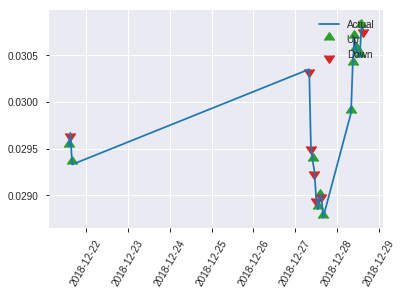


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20506459287326845
RMSE: 0.452840582184579
LogLoss: 0.5946237790001074
Mean Per-Class Error: 0.31409498056447527
AUC: 0.7364373838093629
pr_auc: 0.6744530494930484
Gini: 0.4728747676187257
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3719699772828449: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      56   66   0.541    (66.0/122.0)
1      11   86   0.1134   (11.0/97.0)
Total  67   152  0.3516   (77.0/219.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.37197      0.690763  151
max f2                       0.299046     0.824468  175
max f0point5                 0.61035      0.639344  51
max accuracy                 0.61035      0.675799  51
max precision                0.940577     1         0
max recall                   0.158884     1         212
max specificity              0.940577     1         0
max absolute_mcc             0.438954     0.378192  132
max min_per_class_accuracy   0.501406     0.647541  105
max mean_per_class_accuracy  0.438954     0.685905  132

Gains/Lift Table: Avg response rate: 44.29 %, avg score: 47.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136986                   0.866989           2.25773   2.25773            1                0.907841  1                           0.907841            0.0309278       0.0309278                  125.773   125.773
    2        0.0228311                   0.849677           1.12887   1.80619            0.5              0.8518    0.8                         0.885425            0.0103093       0.0412371                  12.8866   80.6186
    3        0.0319635                   0.82548            2.25773   1.9352             1                0.841595  0.857143                    0.872902            0.0206186       0.0618557                  125.773   93.5199
    4        0.0410959                   0.809672           2.25773   2.00687            1                0.815232  0.888889                    0.860086            0.0206186       0.0824742                  125.773   100.687
    5        0.0502283                   0.777431           2.25773   2.05248            1                0.796572  0.909091                    0.848538            0.0206186       0.103093                   125.773   105.248
    6        0.100457                    0.695181           1.64199   1.84724            0.727273         0.738493  0.818182                    0.793516            0.0824742       0.185567                   64.1987   84.7235
    7        0.150685                    0.665826           1.84724   1.84724            0.818182         0.682839  0.818182                    0.756623            0.0927835       0.278351                   84.7235   84.7235
    8        0.200913                    0.645961           1.23149   1.6933             0.545455         0.656608  0.75                        0.73162             0.0618557       0.340206                   23.149    69.3299
    9        0.30137                     0.571787           1.02624   1.47095            0.454545         0.602065  0.651515                    0.688435            0.103093        0.443299                   2.62418   47.0947
    10       0.401826                    0.527178           1.12887   1.38543            0.5              0.543941  0.613636                    0.652311            0.113402        0.556701                   12.8866   38.5426
    11       0.502283                    0.486449           1.23149   1.35464            0.545455         0.511269  0.6                         0.624103            0.123711        0.680412                   23.149    35.4639
    12       0.598174                    0.440535           1.18262   1.32706            0.52381          0.468018  0.587786                    0.599082            0.113402        0.793814                   18.2622   32.7064
    13       0.69863                     0.36745            0.923618  1.26905            0.409091         0.405101  0.562092                    0.571189            0.0927835       0.886598                   -7.63824  26.9052
    14       0.799087                    0.30025            0.615745  1.18692            0.272727         0.34175   0.525714                    0.542345            0.0618557       0.948454                   -38.4255  18.6922
    15       0.899543                    0.212268           0.307873  1.08875            0.136364         0.262139  0.482234                    0.511053            0.0309278       0.979381                   -69.2127  8.8754
    16       1                           0.112861           0.205248  1                  0.0909091        0.168414  0.442922                    0.476633          

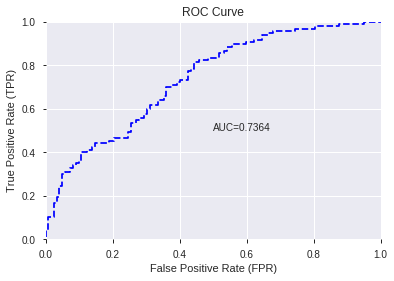

This function is available for GLM models only


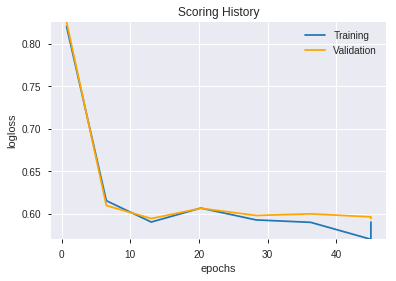

--2019-08-26 14:44:28--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.184.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.184.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_143800_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_143800_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_bd86',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'hour',
 'CDLCLOSINGMARUBOZU',
 'SUB',
 'STOCHF_fastk',
 'DIV',
 'TRANGE',
 'CCI_14',
 'STOCHRSI_fastk',
 'CDLMARUBOZU',
 'CDLENGULFING',
 'CDLLONGLINE',
 'CCI_12',
 'WILLR_30',
 'WILLR_24',
 'CCI_8',
 'WILLR_8',
 'WILLR_20',
 'WILLR_14',
 'WILLR_12',
 'CCI_20',
 'CDLBELTHOLD',
 'ADOSC',
 'ULTOSC',
 'RSI_12',
 'CMO_24',
 'ROCP_20',
 'RSI_20',
 'RSI_24',
 'ROCR_20',
 'CMO_14',
 'ROC_20',
 'MOM_20',
 'RSI_8',
 'CMO_12',
 'ROCR100_20',
 'CMO_8',
 'RSI_14',
 'CMO_20']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_144438_model_1  0.727818  0.603503              0.323094  0.457058  0.208902

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.474052           1.000000    0.189715
1                 hour             0.192729           0.406558    0.077130
2   CDLCLOSINGMARUBOZU             0.185317           0.390922    0.074164
3                  SUB             0.173216           0.365396    0.069321
4         STOCHF_fastk             0.171732           0.362265    0.068727
5       STOCHRSI_fastk             0.144974           0.305820    0.058018
6               CCI_14             0.128549           0.271171    0.051445
7               CCI_12             0.120768           0.254756    0.048331
8             WILLR_30             0.118270           0.249487    0.047331
9             WILLR_24             0.115368           0.243366    0.046170
10            WILLR_20             0.093629           0.197509    0.037470
11        CDLENGULFING             0.075660           0.159602    0.030279
12               CCI_8             0.074256           0.156641    0.029717
13                 DIV             0.071196           0.150186    0.028492
14              TRANGE             0.063364           0.133664    0.025358
15         CDLLONGLINE             0.038982           0.082231    0.015600
16            WILLR_12             0.037719           0.079567    0.015095
17         CDLMARUBOZU             0.030934           0.065255    0.012380
18              CMO_24             0.027259           0.057503    0.010909
19              RSI_24             0.026719           0.056364    0.010693
20             WILLR_8             0.024826           0.052370    0.009935
21            WILLR_14             0.023526           0.049627    0.009415
22              CCI_20             0.013463           0.028399    0.005388
23              RSI_20             0.012227           0.025793    0.004893
24              CMO_20             0.011259           0.023750    0.004506
25               ADOSC             0.009096           0.019187    0.003640
26              ULTOSC             0.007958           0.016787    0.003185
27         CDLBELTHOLD             0.006426           0.013556    0.002572
28              RSI_12             0.006081           0.012828    0.002434
29              CMO_12             0.005359           0.011304    0.002145
30              CMO_14             0.005040           0.010632    0.002017
31              RSI_14             0.004000           0.008437    0.001601
32               CMO_8             0.002445           0.005159    0.000979
33               RSI_8             0.001615           0.003408    0.000646
34              MOM_20             0.000494           0.001043    0.000198
35              ROC_20             0.000172           0.000362    0.000069
36             ROCR_20             0.000055           0.000117    0.000022
37             ROCP_20             0.000018           0.000038    0.000007
38          ROCR100_20             0.000009           0.000019    0.000004

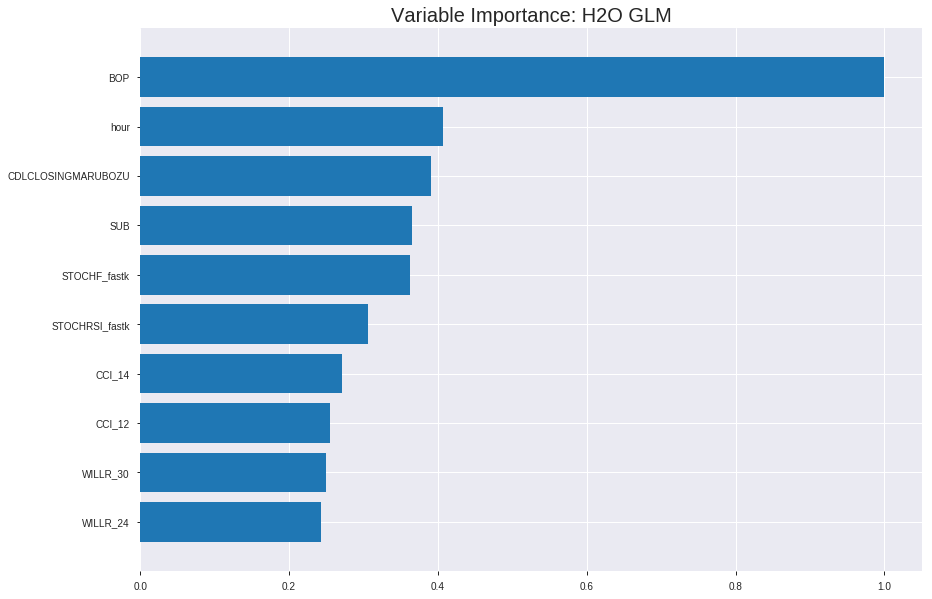

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_144438_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.20394746179633014
RMSE: 0.45160542711124513
LogLoss: 0.5934718385782324
Null degrees of freedom: 1530
Residual degrees of freedom: 1491
Null deviance: 2115.4819722816574
Residual deviance: 1817.2107697265474
AIC: 1897.2107697265474
AUC: 0.7472777360638257
pr_auc: 0.7037189233121303
Gini: 0.4945554721276515
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4218102579122401: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      495  322  0.3941   (322.0/817.0)
1      154  560  0.2157   (154.0/714.0)
Total  649  882  0.3109   (476.0/1531.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.42181      0.701754  223
max f2                       0.128367     0.822171  373
max f0point5                 0.50606      0.675193  173
max accuracy                 0.451423     0.699543  204
max precision                0.93472      1         0
max recall                   0.0979471    1         385
max specificity              0.93472      1         0
max absolute_mcc             0.451423     0.402567  204
max min_per_class_accuracy   0.471931     0.69645   193
max mean_per_class_accuracy  0.451423     0.70162   204

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 46.64 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104507                   0.866915           2.14426   2.14426            1                0.895217  1                           0.895217            0.022409        0.022409                   114.426   114.426
    2        0.0202482                   0.845696           2.00131   2.07509            0.933333         0.854042  0.967742                    0.875293            0.0196078       0.0420168                  100.131   107.509
    3        0.0300457                   0.833632           1.85836   2.00441            0.866667         0.840238  0.934783                    0.863862            0.0182073       0.0602241                  85.8357   100.441
    4        0.0404964                   0.794153           1.60819   1.90216            0.75             0.813738  0.887097                    0.850927            0.0168067       0.0770308                  60.8193   90.2164
    5        0.0502939                   0.776789           1.42951   1.81009            0.666667         0.785381  0.844156                    0.838158            0.0140056       0.0910364                  42.9505   81.0088
    6        0.100588                    0.717416           1.55946   1.68477            0.727273         0.742251  0.785714                    0.790205            0.0784314       0.169468                   55.946    68.4774
    7        0.150229                    0.675234           1.52355   1.6315             0.710526         0.69402   0.76087                     0.758422            0.0756303       0.245098                   52.3552   63.15
    8        0.200523                    0.647769           1.42022   1.57851            0.662338         0.662557  0.736156                    0.734378            0.0714286       0.316527                   42.0223   57.8509
    9        0.300457                    0.586395           1.34542   1.50098            0.627451         0.616592  0.7                         0.695201            0.134454        0.45098                    34.5417   50.098
    10       0.400392                    0.525867           1.40148   1.47614            0.653595         0.55372   0.688418                    0.659889            0.140056        0.591036                   40.1476   47.6145
    11       0.500327                    0.465412           1.21928   1.42484            0.568627         0.494686  0.664491                    0.626891            0.121849        0.712885                   21.9284   42.484
    12       0.600261                    0.406842           0.8549    1.32995            0.398693         0.433554  0.620239                    0.594703            0.0854342       0.798319                   -14.51    32.9953
    13       0.700196                    0.354265           0.672708  1.23615            0.313725         0.381572  0.576493                    0.564284            0.0672269       0.865546                   -32.7292  23.6149
    14       0.800131                    0.289412           0.658694  1.16403            0.30719          0.324985  0.542857                    0.534396            0.0658263       0.931373                   -34.1306  16.4026
    15       0.900065                    0.201876           0.378398  1.0768             0.176471         0.248862  0.502177                    0.502693            0.0378151       0.969188                   -62.1602  7.6797
    16       1                           0.024686           0.308325  1                  0.143791         0.139142  0.466362                    0.466362            0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2031817040272754
RMSE: 0.4507568125134388
LogLoss: 0.590406040924365
Null degrees of freedom: 437
Residual degrees of freedom: 398
Null deviance: 603.5241039768543
Residual deviance: 517.1956918497438
AIC: 597.1956918497438
AUC: 0.7477167508417508
pr_auc: 0.6588688403782945
Gini: 0.49543350168350164
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3541088758808508: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      113  127  0.5292   (127.0/240.0)
1      16   182  0.0808   (16.0/198.0)
Total  129  309  0.3265   (143.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.354109     0.717949  278
max f2                       0.295783     0.831135  310
max f0point5                 0.445755     0.665499  217
max accuracy                 0.445755     0.703196  217
max precision                0.899684     1         0
max recall                   0.0861386    1         390
max specificity              0.899684     1         0
max absolute_mcc             0.405102     0.427805  247
max min_per_class_accuracy   0.479715     0.686869  194
max mean_per_class_accuracy  0.435874     0.710164  222

Gains/Lift Table: Avg response rate: 45.21 %, avg score: 45.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.856199           2.21212   2.21212            1                0.879759  1                           0.879759            0.0252525       0.0252525                  121.212   121.212
    2        0.0205479                   0.817769           2.21212   2.21212            1                0.835601  1                           0.860133            0.020202        0.0454545                  121.212   121.212
    3        0.0319635                   0.80907            1.32727   1.8961             0.6              0.813934  0.857143                    0.843633            0.0151515       0.0606061                  32.7273   89.6104
    4        0.0410959                   0.789623           1.10606   1.72054            0.5              0.800619  0.777778                    0.834075            0.010101        0.0707071                  10.6061   72.0539
    5        0.0502283                   0.759735           0.55303   1.50826            0.25             0.782768  0.681818                    0.824746            0.00505051      0.0757576                  -44.697   50.8264
    6        0.100457                    0.70164            1.50826   1.50826            0.681818         0.728522  0.681818                    0.776634            0.0757576       0.151515                   50.8264   50.8264
    7        0.150685                    0.662322           1.30716   1.44123            0.590909         0.677488  0.651515                    0.743585            0.0656566       0.217172                   30.7163   44.123
    8        0.200913                    0.635957           1.40771   1.43285            0.636364         0.647497  0.647727                    0.719563            0.0707071       0.287879                   40.7713   43.2851
    9        0.30137                     0.574055           1.50826   1.45799            0.681818         0.604245  0.659091                    0.681124            0.151515        0.439394                   50.8264   45.7989
    10       0.399543                    0.522688           1.38901   1.44104            0.627907         0.54756   0.651429                    0.648305            0.136364        0.575758                   38.9006   44.1039
    11       0.5                         0.472475           1.35744   1.42424            0.613636         0.497979  0.643836                    0.618103            0.136364        0.712121                   35.7438   42.4242
    12       0.600457                    0.40895            1.00551   1.35419            0.454545         0.441149  0.612167                    0.588498            0.10101         0.813131                   0.550964  35.4188
    13       0.69863                     0.35668            0.977449  1.30125            0.44186          0.383352  0.588235                    0.55967             0.0959596       0.909091                   -2.25511  30.1248
    14       0.799087                    0.283728           0.452479  1.19455            0.204545         0.32466   0.54                        0.530126            0.0454545       0.954545                   -54.7521  19.4545
    15       0.899543                    0.181722           0.301653  1.09483            0.136364         0.234379  0.494924                    0.497099            0.030303        0.984848                   -69.8347  9.48316
    16       1                           0.000589552        0.150826  1                  0.0681818        0.122675  0.452055                    0.459485          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 14:44:38  0.000 sec   2            18        40            1.36068           1.35199
    2019-08-26 14:44:38  0.008 sec   4            11        40            1.35164           1.34127
    2019-08-26 14:44:38  0.017 sec   6            6.9       40            1.34022           1.32805
    2019-08-26 14:44:38  0.026 sec   8            4.3       40            1.32629           1.31232
    2019-08-26 14:44:38  0.034 sec   10           2.7       40            1.30991           1.29424
    2019-08-26 14:44:38  0.043 sec   12           1.7       40            1.29139           1.27422
    2019-08-26 14:44:38  0.051 sec   14           1         40            1.27173           1.25337
    2019-08-26 14:44:38  0.059 sec   16           0.64      40            1.25233           1.23332
    2019-08-26 14:44:38  0.067 sec   18           0.4       40            1.23468           1.21578
    2019-08-26 14:44:38  0.076 sec   20           0.25      40            1.2197            1.20186
    2019-08-26 14:44:38  0.084 sec   22           0.15      40            1.2077            1.19184
    2019-08-26 14:44:38  0.092 sec   24           0.095     40            1.19851           1.18543
    2019-08-26 14:44:38  0.100 sec   26           0.059     40            1.19174           1.182
    2019-08-26 14:44:38  0.108 sec   28           0.037     40            1.18694           1.18081
    2019-08-26 14:44:38  0.116 sec   30           0.023     40            1.18361           1.18139
    2019-08-26 14:44:38  0.124 sec   32           0.014     40            1.18131           1.18334
    2019-08-26 14:44:38  0.132 sec   34           0.0088    40            1.17967           1.18633
    2019-08-26 14:44:38  0.140 sec   36           0.0055    40            1.17833           1.19134
    2019-08-26 14:44:38  0.148 sec   38           0.0034    40            1.17715           1.20142

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6757990867579908)

('F1', 0.6935483870967741)

('auc', 0.7278181510900794)

('logloss', 0.6035027026316171)

('mean_per_class_error', 0.3230944735507859)

('rmse', 0.457057962400042)

('mse', 0.2089019809932782)

glm prediction progress: |████████████████████████████████████████████████| 100%


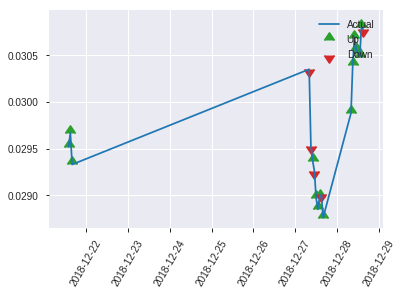


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2089019809932782
RMSE: 0.457057962400042
LogLoss: 0.6035027026316171
Null degrees of freedom: 218
Residual degrees of freedom: 179
Null deviance: 301.2230274583454
Residual deviance: 264.3341837526483
AIC: 344.3341837526483
AUC: 0.7278181510900794
pr_auc: 0.6490483704996494
Gini: 0.4556363021801588
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3990138925041696: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      57   65   0.5328   (65.0/122.0)
1      11   86   0.1134   (11.0/97.0)
Total  68   151  0.347    (76.0/219.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.399014     0.693548  150
max f2                       0.338673     0.815412  169
max f0point5                 0.573526     0.63591   75
max accuracy                 0.573526     0.675799  75
max precision                0.880475     1         0
max recall                   0.134603     1         208
max specificity              0.880475     1         0
max absolute_mcc             0.399014     0.379834  150
max min_per_class_accuracy   0.49529      0.659794  102
max mean_per_class_accuracy  0.399014     0.676906  150

Gains/Lift Table: Avg response rate: 44.29 %, avg score: 47.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136986                   0.852573           2.25773   2.25773            1                0.86982   1                           0.86982             0.0309278       0.0309278                  125.773   125.773
    2        0.0228311                   0.817758           1.12887   1.80619            0.5              0.829901  0.8                         0.853853            0.0103093       0.0412371                  12.8866   80.6186
    3        0.0319635                   0.788894           1.12887   1.61267            0.5              0.800248  0.714286                    0.838537            0.0103093       0.0515464                  12.8866   61.2666
    4        0.0410959                   0.778392           2.25773   1.75601            1                0.779415  0.777778                    0.825399            0.0206186       0.0721649                  125.773   75.6014
    5        0.0502283                   0.763862           1.12887   1.64199            0.5              0.771346  0.727273                    0.815571            0.0103093       0.0824742                  12.8866   64.1987
    6        0.100457                    0.707299           1.84724   1.74461            0.818182         0.734621  0.772727                    0.775096            0.0927835       0.175258                   84.7235   74.4611
    7        0.150685                    0.666016           1.64199   1.7104             0.727273         0.690223  0.757576                    0.746805            0.0824742       0.257732                   64.1987   71.0403
    8        0.200913                    0.627047           1.02624   1.53936            0.454545         0.651264  0.681818                    0.72292             0.0515464       0.309278                   2.62418   53.9363
    9        0.30137                     0.586264           1.43674   1.50515            0.636364         0.602836  0.666667                    0.682892            0.14433         0.453608                   43.6739   50.5155
    10       0.401826                    0.528216           1.12887   1.41108            0.5              0.560461  0.625                       0.652284            0.113402        0.56701                    12.8866   41.1082
    11       0.502283                    0.486431           1.12887   1.35464            0.5              0.504673  0.6                         0.622762            0.113402        0.680412                   12.8866   35.4639
    12       0.598174                    0.43211            0.860088  1.27536            0.380952         0.461757  0.564885                    0.596952            0.0824742       0.762887                   -13.9912  27.536
    13       0.69863                     0.384313           1.23149   1.26905            0.545455         0.411925  0.562092                    0.570347            0.123711        0.886598                   23.149    26.9052
    14       0.799087                    0.292681           0.513121  1.17402            0.227273         0.349066  0.52                        0.542529            0.0515464       0.938144                   -48.6879  17.4021
    15       0.899543                    0.222779           0.307873  1.07729            0.136364         0.265903  0.477157                    0.511636            0.0309278       0.969072                   -69.2127  7.72934
    16       1                           0.0480892          0.307873  1                  0.136364         0.141772  0.442922                    0.474481          

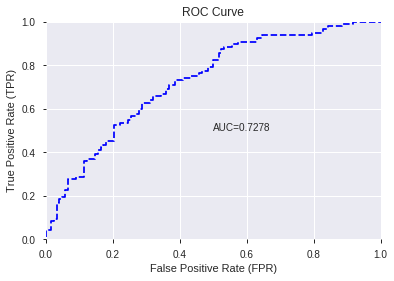

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


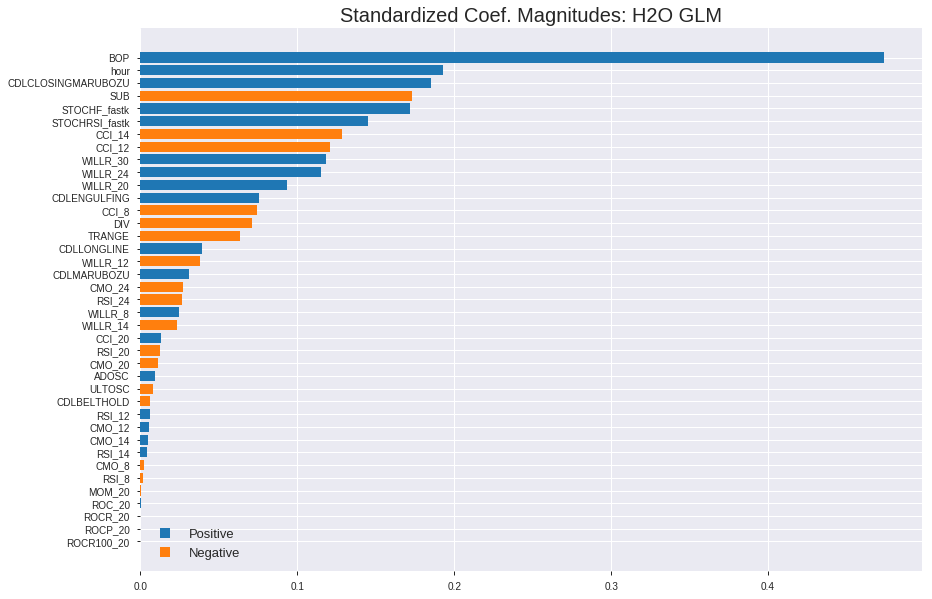

'log_likelihood'
--2019-08-26 14:44:44--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.98.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.98.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_144438_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_144438_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_bd86',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'hour',
 'CDLCLOSINGMARUBOZU',
 'SUB',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'CCI_14',
 'CCI_12',
 'WILLR_30',
 'WILLR_24',
 'WILLR_20',
 'CDLENGULFING',
 'CCI_8',
 'DIV',
 'TRANGE',
 'CDLLONGLINE',
 'WILLR_12',
 'CDLMARUBOZU',
 'CMO_24',
 'RSI_24',
 'WILLR_8',
 'WILLR_14',
 'CCI_20',
 'RSI_20',
 'CMO_20',
 'ADOSC',
 'ULTOSC',
 'CDLBELTHOLD',
 'RSI_12',
 'CMO_12',
 'CMO_14',
 'RSI_14',
 'CMO_8',
 'RSI_8',
 'MOM_20',
 'ROC_20',
 'ROCR_20',
 'ROCP_20',
 'ROCR100_20']

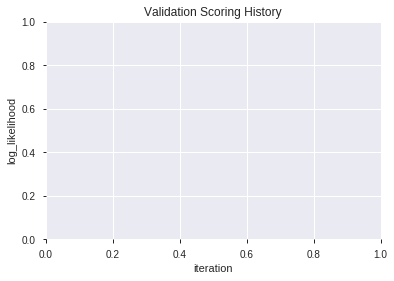

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_144453_model_3  0.737367  0.595996              0.297448  0.453670  0.205816
1  XGBoost_grid_1_AutoML_20190826_144453_model_6  0.735170  0.600795              0.307884  0.454976  0.207003
2  XGBoost_grid_1_AutoML_20190826_144453_model_2  0.734663  0.597649              0.311856  0.454464  0.206538
3  XGBoost_grid_1_AutoML_20190826_144453_model_1  0.733564  0.597730              0.301927  0.455097  0.207113
4               XGBoost_3_AutoML_20190826_144453  0.725706  0.602831              0.317010  0.457594  0.209392
5  XGBoost_grid_1_AutoML_20190826_144453_model_4  0.719537  0.606564              0.343586  0.459579  0.211213
6               XGBoost_1_AutoML_20190826_144453  0.717002  0.612847              0.326263  0.461674  0.213143
7               XGBoost_2_AutoML_20190826_144453  0.714298  0.615435              0.374134  0.463270  0.214619
8  XGBoost_grid_1_AutoML_20190826_144453_model_7  0.711256  0.616514              0.379162  0.463931  0.215232
9  XGBoost_grid_1_AutoML_20190826_144453_model_5  0.710242  0.630114              0.356811  0.469717  0.220634

variable  relative_importance  scaled_importance  percentage
0                  BOP          1280.130005           1.000000    0.200085
1         STOCHF_fastk           495.308685           0.386921    0.077417
2                  DIV           411.347076           0.321332    0.064294
3                 hour           391.127686           0.305537    0.061133
4       STOCHRSI_fastk           343.199921           0.268098    0.053642
5                  SUB           318.587128           0.248871    0.049795
6                ADOSC           281.249207           0.219704    0.043959
7                CCI_8           236.268692           0.184566    0.036929
8               CCI_14           218.345825           0.170565    0.034128
9              WILLR_8           170.684753           0.133334    0.026678
10              ULTOSC           168.073761           0.131294    0.026270
11              TRANGE           164.597092           0.128578    0.025727
12              MOM_20           135.111069           0.105545    0.021118
13            WILLR_14           127.467712           0.099574    0.019923
14              CCI_20           124.322098           0.097117    0.019432
15            WILLR_30           116.880150           0.091303    0.018268
16              ROC_20           115.687531           0.090372    0.018082
17            WILLR_20           109.794029           0.085768    0.017161
18              CMO_12           103.226830           0.080638    0.016134
19            WILLR_12           100.602524           0.078588    0.015724
20            WILLR_24            96.582108           0.075447    0.015096
21               CMO_8            94.610870           0.073907    0.014788
22              CCI_12            93.298347           0.072882    0.014583
23              CMO_14            88.358086           0.069023    0.013810
24              CMO_24            87.906700           0.068670    0.013740
25              CMO_20            74.304337           0.058044    0.011614
26             ROCR_20            59.179825           0.046230    0.009250
27               RSI_8            58.452446           0.045661    0.009136
28  CDLCLOSINGMARUBOZU            48.311787           0.037740    0.007551
29             ROCP_20            46.479721           0.036309    0.007265
30              RSI_14            45.155254           0.035274    0.007058
31              RSI_12            45.092861           0.035225    0.007048
32              RSI_24            44.649414           0.034879    0.006979
33              RSI_20            44.203407           0.034530    0.006909
34         CDLLONGLINE            26.937183           0.021043    0.004210
35          ROCR100_20            19.946552           0.015582    0.003118
36        CDLENGULFING            10.772598           0.008415    0.001684
37         CDLBELTHOLD             1.689621           0.001320    0.000264

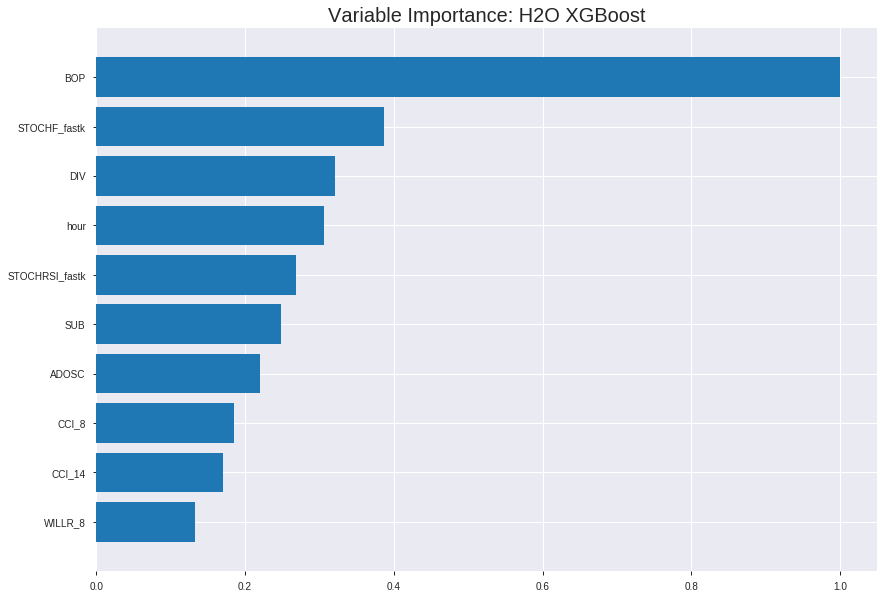

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_144453_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.14592387650423977
RMSE: 0.3819998383563006
LogLoss: 0.46038309833387353
Mean Per-Class Error: 0.19309302668435802
AUC: 0.8992608059135527
pr_auc: 0.88962385384929
Gini: 0.7985216118271055
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44571881741285324: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      605  212  0.2595   (212.0/817.0)
1      94   620  0.1317   (94.0/714.0)
Total  699  832  0.1999   (306.0/1531.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.445719     0.80207   215
max f2                       0.305257     0.882874  280
max f0point5                 0.571377     0.825017  154
max accuracy                 0.561904     0.810581  160
max precision                0.947801     1         0
max recall                   0.123438     1         369
max specificity              0.947801     1         0
max absolute_mcc             0.561904     0.62311   160
max min_per_class_accuracy   0.492551     0.802521  193
max mean_per_class_accuracy  0.516081     0.806907  181

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 46.75 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104507                   0.896514           2.14426    2.14426            1                0.9241    1                           0.9241              0.022409        0.022409                   114.426   114.426
    2        0.0202482                   0.877226           2.14426    2.14426            1                0.888168  1                           0.906713            0.0210084       0.0434174                  114.426   114.426
    3        0.0300457                   0.855606           2.14426    2.14426            1                0.865412  1                           0.893245            0.0210084       0.0644258                  114.426   114.426
    4        0.0404964                   0.822618           2.14426    2.14426            1                0.837697  1                           0.87891             0.022409        0.0868347                  114.426   114.426
    5        0.0502939                   0.810001           2.14426    2.14426            1                0.814823  1                           0.866426            0.0210084       0.107843                   114.426   114.426
    6        0.100588                    0.753053           2.11641    2.13033            0.987013         0.781746  0.993506                    0.824086            0.106443        0.214286                   111.641   113.033
    7        0.150229                    0.718265           2.00319    2.08832            0.934211         0.735348  0.973913                    0.794764            0.0994398       0.313725                   100.319   108.832
    8        0.200523                    0.681844           1.86578    2.0325             0.87013          0.70158   0.947883                    0.771392            0.0938375       0.407563                   86.5783   103.25
    9        0.300457                    0.620212           1.7098     1.92517            0.797386         0.649777  0.897826                    0.730942            0.170868        0.578431                   70.98     92.5171
    10       0.400392                    0.552622           1.47155    1.81195            0.686275         0.587404  0.845024                    0.695116            0.147059        0.72549                    47.1549   81.195
    11       0.500327                    0.47752            0.981033   1.64598            0.457516         0.512808  0.767624                    0.658702            0.0980392       0.823529                   -1.89671  64.5984
    12       0.600261                    0.406031           0.812856   1.50728            0.379085         0.440838  0.702938                    0.622431            0.0812325       0.904762                   -18.7144  50.728
    13       0.700196                    0.316165           0.630664   1.38217            0.294118         0.361235  0.64459                     0.585152            0.0630252       0.967787                   -36.9336  38.2166
    14       0.800131                    0.230414           0.224236   1.23754            0.104575         0.274521  0.577143                    0.546355            0.022409        0.990196                   -77.5764  23.7543
    15       0.900065                    0.155337           0.056059   1.10636            0.0261438        0.193671  0.515965                    0.507196            0.00560224      0.995798                   -94.3941  10.6362
    16       1                           0.0571962          0.0420443  1                  0.0196078        0.110466  0.466362                    0.



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19582489565391295
RMSE: 0.4425210680339558
LogLoss: 0.5732261183609898
Mean Per-Class Error: 0.2825126262626263
AUC: 0.7658670033670033
pr_auc: 0.6851713793844397
Gini: 0.5317340067340066
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36399465799331665: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      122  118  0.4917   (118.0/240.0)
1      22   176  0.1111   (22.0/198.0)
Total  144  294  0.3196   (140.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.363995     0.715447  262
max f2                       0.194657     0.839071  334
max f0point5                 0.462096     0.678899  200
max accuracy                 0.462096     0.714612  200
max precision                0.895337     1         0
max recall                   0.112342     1         377
max specificity              0.895337     1         0
max absolute_mcc             0.462096     0.433043  200
max min_per_class_accuracy   0.47929      0.7       188
max mean_per_class_accuracy  0.462096     0.717487  200

Gains/Lift Table: Avg response rate: 45.21 %, avg score: 45.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.866299           2.21212   2.21212            1                0.883294  1                           0.883294            0.0252525       0.0252525                  121.212   121.212
    2        0.0205479                   0.851279           1.65909   1.96633            0.75             0.856064  0.888889                    0.871192            0.0151515       0.040404                   65.9091   96.633
    3        0.0319635                   0.83451            1.7697    1.8961             0.8              0.843894  0.857143                    0.861442            0.020202        0.0606061                  76.9697   89.6104
    4        0.0410959                   0.809545           0.55303   1.59764            0.25             0.821119  0.722222                    0.852482            0.00505051      0.0656566                  -44.697   59.7643
    5        0.0502283                   0.788825           1.10606   1.50826            0.5              0.79701   0.681818                    0.842396            0.010101        0.0757576                  10.6061   50.8264
    6        0.100457                    0.74497            1.91047   1.70937            0.863636         0.764161  0.772727                    0.803278            0.0959596       0.171717                   91.0468   70.9366
    7        0.150685                    0.701331           1.40771   1.60882            0.636364         0.719095  0.727273                    0.775217            0.0707071       0.242424                   40.7713   60.8815
    8        0.200913                    0.668912           1.50826   1.58368            0.681818         0.682124  0.715909                    0.751944            0.0757576       0.318182                   50.8264   58.3678
    9        0.30137                     0.596559           1.40771   1.52502            0.636364         0.635948  0.689394                    0.713279            0.141414        0.459596                   40.7713   52.5023
    10       0.399543                    0.527101           1.38901   1.4916             0.627907         0.562696  0.674286                    0.676278            0.136364        0.59596                    38.9006   49.1602
    11       0.5                         0.464477           1.35744   1.46465            0.613636         0.493459  0.6621                      0.639548            0.136364        0.732323                   35.7438   46.4646
    12       0.600457                    0.407783           0.854683  1.3626             0.386364         0.433519  0.61597                     0.605079            0.0858586       0.818182                   -14.5317  36.2599
    13       0.69863                     0.329548           0.87456   1.29402            0.395349         0.37461   0.584967                    0.572693            0.0858586       0.90404                    -12.544   29.4019
    14       0.799087                    0.235031           0.452479  1.18823            0.204545         0.288842  0.537143                    0.537009            0.0454545       0.949495                   -54.7521  18.8225
    15       0.899543                    0.149442           0.402204  1.10045            0.181818         0.189679  0.497462                    0.498221            0.040404        0.989899                   -59.7796  10.0446
    16       1                           0.0636049          0.100551  1                  0.0454545        0.10952   0.452055                    0.459173          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:45:00  1.920 sec   0                  0.5              0.693147            0.5             0                  1                0.533638                         0.5                0.693147              0.5               0                    1                  0.547945
    2019-08-26 14:45:00  2.020 sec   5                  0.475776         0.645556            0.812669        0.777717           2.14426          0.293926                         0.480098           0.653862              0.758838          0.666945             1.7697             0.280822
    2019-08-26 14:45:00  2.079 sec   10                 0.456691         0.608545            0.827474        0.798928           2.14426          0.27825                          0.465967           0.626052              0.76896           0.67471              1.7697             0.278539
    2019-08-26 14:45:00  2.144 sec   15                 0.442663         0.581183            0.842812        0.821241           2.14426          0.27629                          0.459096           0.612004              0.769329          0.676275             1.7697             0.294521
    2019-08-26 14:45:00  2.226 sec   20                 0.431734         0.559415            0.846904        0.825437           2.14426          0.256695                         0.452367           0.598049              0.768813          0.682415             2.21212            0.292237
    2019-08-26 14:45:00  2.298 sec   25                 0.421791         0.539675            0.856946        0.837462           2.14426          0.25147                          0.449374           0.591094              0.764594          0.679397             2.21212            0.321918
    2019-08-26 14:45:00  2.363 sec   30                 0.415127         0.52614             0.862323        0.843567           2.14426          0.250816                         0.445729           0.583134              0.768182          0.684624             2.21212            0.315068
    2019-08-26 14:45:00  2.429 sec   35                 0.409715         0.515037            0.867552        0.847658           2.14426          0.241019                         0.445219           0.581354              0.765835          0.684899             2.21212            0.328767
    2019-08-26 14:45:00  2.499 sec   40                 0.402462         0.500867            0.876344        0.85801            2.14426          0.239713                         0.443424           0.577135              0.767466          0.689084             2.21212            0.328767
    2019-08-26 14:45:00  2.566 sec   45                 0.398576         0.492944            0.880126        0.864211           2.14426          0.229262                         0.443296           0.576322              0.766235          0.688848             2.21212            0.324201
    2019-08-26 14:45:00  2.649 sec   50                 0.393803         0.483438            0.885241        0.870358           2.14426          0.226649                         0.443357           0.575915              0.764299          0.685209             2.21212            0.30137
    2019-08-26 14:45:00  2.724 sec   55                 0.389922         0.475813            0.889665        0.877198           2.14426          0.227956                         0.442282           0.573449              0.767835          0.

Variable Importances: 


variable        relative_importance    scaled_importance      percentage
--------------  ---------------------  ---------------------  ---------------------
BOP             1280.1300048828125     1.0                    0.20008462514571634
STOCHF_fastk    495.3086853027344      0.3869206122920903     0.07741686567161393
DIV             411.3470764160156      0.32133226691586825    0.06429364617308476
hour            391.127685546875       0.30553747201846126    0.061133350556783615
STOCHRSI_fastk  343.1999206542969      0.2680977083149571     0.05364222947062379
---             ---                    ---                    ---
RSI_20          44.203407287597656     0.034530404817473354   0.006909003104033994
CDLLONGLINE     26.937183380126953     0.02104253730275846    0.00421028818833718
ROCR100_20      19.946552276611328     0.015581661394177933   0.0031176508792015714
CDLENGULFING    10.772598266601562     0.008415237691102884   0.001683759678936424
CDLBELTHOLD     1.6896209716796875     0.0013198823285408118  0.0002640881609425436


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.680365296803653)

('F1', 0.7131147540983608)

('auc', 0.7373669089065404)

('logloss', 0.5959962342856836)

('mean_per_class_error', 0.2974480310968396)

('rmse', 0.4536699625430417)

('mse', 0.20581643491380489)

xgboost prediction progress: |████████████████████████████████████████████| 100%


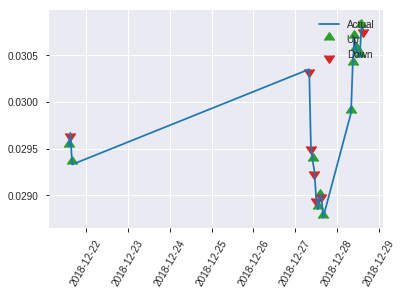


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20581643491380489
RMSE: 0.4536699625430417
LogLoss: 0.5959962342856836
Mean Per-Class Error: 0.2974480310968396
AUC: 0.7373669089065404
pr_auc: 0.6583824326391642
Gini: 0.4747338178130809
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3676750063896179: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      62   60   0.4918   (60.0/122.0)
1      10   87   0.1031   (10.0/97.0)
Total  72   147  0.3196   (70.0/219.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.367675     0.713115  146
max f2                       0.241465     0.827465  179
max f0point5                 0.404531     0.63593   132
max accuracy                 0.404531     0.680365  132
max precision                0.899627     1         0
max recall                   0.095274     1         215
max specificity              0.899627     1         0
max absolute_mcc             0.367675     0.428358  146
max min_per_class_accuracy   0.491112     0.659794  104
max mean_per_class_accuracy  0.367675     0.702552  146

Gains/Lift Table: Avg response rate: 44.29 %, avg score: 46.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136986                   0.878876           2.25773   2.25773            1                0.89201   1                           0.89201             0.0309278       0.0309278                  125.773   125.773
    2        0.0228311                   0.854097           1.12887   1.80619            0.5              0.862382  0.8                         0.880158            0.0103093       0.0412371                  12.8866   80.6186
    3        0.0319635                   0.836021           2.25773   1.9352             1                0.843369  0.857143                    0.869647            0.0206186       0.0618557                  125.773   93.5199
    4        0.0410959                   0.800206           2.25773   2.00687            1                0.818642  0.888889                    0.858313            0.0206186       0.0824742                  125.773   100.687
    5        0.0502283                   0.792456           2.25773   2.05248            1                0.798656  0.909091                    0.847466            0.0206186       0.103093                   125.773   105.248
    6        0.100457                    0.745597           1.02624   1.53936            0.454545         0.77746   0.681818                    0.812463            0.0515464       0.154639                   2.62418   53.9363
    7        0.150685                    0.702157           1.84724   1.64199            0.818182         0.72308   0.727273                    0.782668            0.0927835       0.247423                   84.7235   64.1987
    8        0.200913                    0.662534           1.64199   1.64199            0.727273         0.67663   0.727273                    0.756159            0.0824742       0.329897                   64.1987   64.1987
    9        0.30137                     0.599994           1.23149   1.50515            0.545455         0.629182  0.666667                    0.713833            0.123711        0.453608                   23.149    50.5155
    10       0.401826                    0.550732           1.23149   1.43674            0.545455         0.571125  0.636364                    0.678156            0.123711        0.57732                    23.149    43.6739
    11       0.502283                    0.478693           0.923618  1.33411            0.409091         0.511242  0.590909                    0.644773            0.0927835       0.670103                   -7.63824  33.4114
    12       0.598174                    0.4118             1.39764   1.3443             0.619048         0.439296  0.59542                     0.611834            0.134021        0.804124                   39.7644   34.4298
    13       0.69863                     0.344108           0.923618  1.28381            0.409091         0.379884  0.568627                    0.578482            0.0927835       0.896907                   -7.63824  28.3808
    14       0.799087                    0.257262           0.410497  1.17402            0.181818         0.298524  0.52                        0.543287            0.0412371       0.938144                   -58.9503  17.4021
    15       0.899543                    0.169345           0.513121  1.10021            0.227273         0.212349  0.48731                     0.50633             0.0515464       0.989691                   -48.6879  10.0215
    16       1                           0.0683262          0.102624  1                  0.0454545        0.125575  0.442922                    0.46808          

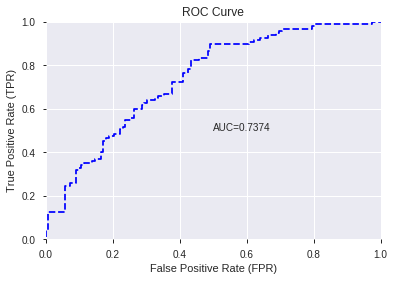

This function is available for GLM models only


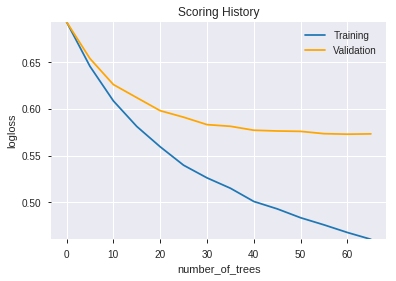

--2019-08-26 14:45:13--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.200.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.200.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_144453_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_144453_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_bd86',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'DIV',
 'hour',
 'STOCHRSI_fastk',
 'SUB',
 'ADOSC',
 'CCI_8',
 'CCI_14',
 'WILLR_8',
 'ULTOSC',
 'TRANGE',
 'MOM_20',
 'WILLR_14',
 'CCI_20',
 'WILLR_30',
 'ROC_20',
 'WILLR_20',
 'CMO_12',
 'WILLR_12',
 'WILLR_24',
 'CMO_8',
 'CCI_12',
 'CMO_14',
 'CMO_24',
 'CMO_20',
 'ROCR_20',
 'RSI_8',
 'CDLCLOSINGMARUBOZU',
 'ROCP_20',
 'RSI_14',
 'RSI_12',
 'RSI_24',
 'RSI_20',
 'CDLLONGLINE',
 'ROCR100_20',
 'CDLENGULFING',
 'CDLBELTHOLD']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

101

['MA_20_1',
 'BBANDS_upperband_20_1_4',
 'BBANDS_upperband_20_2_2',
 'BBANDS_upperband_20_3_4',
 'BBANDS_upperband_20_3_5',
 'BBANDS_upperband_20_6_3',
 'BBANDS_lowerband_24_0_5',
 'BBANDS_lowerband_24_2_5',
 'BBANDS_upperband_24_5_4',
 'BBANDS_lowerband_24_6_5',
 'BOP',
 'ADX_8',
 'ADXR_8',
 'AROONOSC_8',
 'CCI_8',
 'MFI_8',
 'MOM_8',
 'ROC_8',
 'ROCR_8',
 'WILLR_8',
 'ADX_12',
 'aroondown_12',
 'AROONOSC_12',
 'DX_12',
 'MACDFIX_12',
 'MACDFIX_hist_12',
 'MFI_12',
 'MINUS_DM_12',
 'MOM_12',
 'PLUS_DM_12',
 'ROC_12',
 'ROCP_12',
 'TRIX_12',
 'ADX_14',
 'AROONOSC_14',
 'CCI_14',
 'PLUS_DI_14',
 'ROCR_14',
 'RSI_14',
 'ADX_20',
 'aroondown_20',
 'aroonup_20',
 'CMO_20',
 'DX_20',
 'MINUS_DI_20',
 'MINUS_DM_20',
 'ROCR_20',
 'ROCR100_20',
 'ADX_24',
 'aroondown_24',
 'AROONOSC_24',
 'MACDFIX_24',
 'MACDFIX_signal_24',
 'MACDFIX_hist_24',
 'MOM_24',
 'ROCR100_24',
 'RSI_24',
 'WILLR_24',
 'aroondown_30',
 'aroonup_30',
 'AROONOSC_30',
 'CCI_30',
 'MINUS_DI_30',
 'PLUS_DM_30',
 'ROC_30',
 

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_144620_model_4  0.730100  1.872217              0.336573  0.642570  0.412896
1  DeepLearning_grid_1_AutoML_20190826_144620_model_9  0.715819  0.625699              0.315278  0.467822  0.218857
2  DeepLearning_grid_1_AutoML_20190826_144620_model_3  0.708214  1.563623              0.312109  0.647172  0.418832
3  DeepLearning_grid_1_AutoML_20190826_144620_model_7  0.691398  0.647761              0.372275  0.478018  0.228501
4  DeepLearning_grid_1_AutoML_20190826_144620_model_8  0.682356  0.650515              0.416047  0.479379  0.229804
5  DeepLearning_grid_1_AutoML_20190826_144620_model_5  0.647203  0.658553              0.359050  0.484026  0.234281
6  DeepLearning_grid_1_AutoML_20190826_144620_model_2  0.646611  1.287741              0.396738  0.628091  0.394498
7  DeepLearning_grid_1_AutoML_20190826_144620_model_6  0.628528  0.666250              0.375444  0.487741  0.237892
8  DeepLearning_grid_1_AutoML_20190826_144620_model_1  0.613994  1.521874              0.404005  0.586135  0.343554
9               DeepLearning_1_AutoML_20190826_144620  0.569376  2.040861              0.459143  0.711721  0.506547

variable  relative_importance  scaled_importance  percentage
0                     TRANGE             1.000000           1.000000    0.012467
1                  CDLHAMMER             0.937487           0.937487    0.011687
2                        BOP             0.920751           0.920751    0.011479
3         CDLCLOSINGMARUBOZU             0.901909           0.901909    0.011244
4                      ADOSC             0.851094           0.851094    0.010610
..                       ...                  ...                ...         ...
96                PLUS_DM_12             0.750586           0.750586    0.009357
97                aroonup_30             0.747524           0.747524    0.009319
98   BBANDS_upperband_20_2_2             0.744570           0.744570    0.009282
99                    RSI_24             0.740262           0.740262    0.009229
100                  ROCR_14             0.739086           0.739086    0.009214

[101 rows x 4 columns]

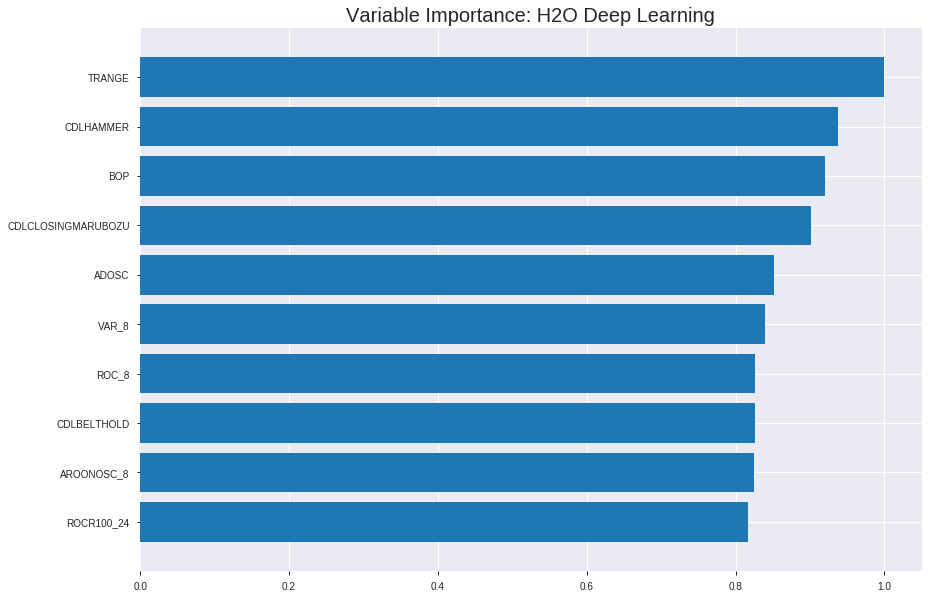

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_144620_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18393122863272002
RMSE: 0.42887204226053255
LogLoss: 0.5786808163893653
Mean Per-Class Error: 0.2545976775042942
AUC: 0.8237274101807186
pr_auc: 0.7766750286926596
Gini: 0.6474548203614372
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2327774870640103: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      528  289  0.3537   (289.0/817.0)
1      111  603  0.1555   (111.0/714.0)
Total  639  892  0.2613   (400.0/1531.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.232777     0.750934  277
max f2                       0.058362     0.848777  355
max f0point5                 0.674237     0.740609  134
max accuracy                 0.344087     0.743305  240
max precision                0.999422     1         0
max recall                   0.00188188   1         397
max specificity              0.999422     1         0
max absolute_mcc             0.232777     0.496519  277
max min_per_class_accuracy   0.400963     0.736842  223
max mean_per_class_accuracy  0.232777     0.745402  277

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 44.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104507                   0.998815           2.14426   2.14426            1                0.999472    1                           0.999472            0.022409        0.022409                   114.426   114.426
    2        0.0202482                   0.997828           2.00131   2.07509            0.933333         0.998195    0.967742                    0.998854            0.0196078       0.0420168                  100.131   107.509
    3        0.0300457                   0.995966           2.00131   2.05103            0.933333         0.996948    0.956522                    0.998233            0.0196078       0.0616246                  100.131   105.103
    4        0.0404964                   0.992724           2.01024   2.0405             0.9375           0.994321    0.951613                    0.997223            0.0210084       0.0826331                  101.024   104.05
    5        0.0502939                   0.990536           2.14426   2.06072            1                0.991614    0.961039                    0.996131            0.0210084       0.103641                   114.426   106.072
    6        0.100588                    0.967606           1.92148   1.9911             0.896104         0.980449    0.928571                    0.98829             0.0966387       0.20028                    92.1478   99.1096
    7        0.150229                    0.940192           1.66462   1.88322            0.776316         0.953863    0.878261                    0.976914            0.0826331       0.282913                   66.4621   88.3218
    8        0.200523                    0.897467           1.6987    1.83694            0.792208         0.918412    0.856678                    0.962241            0.0854342       0.368347                   69.8698   83.6937
    9        0.300457                    0.759663           1.45753   1.71074            0.679739         0.833674    0.797826                    0.919478            0.145658        0.514006                   45.7535   71.0745
    10       0.400392                    0.562282           1.35943   1.62306            0.633987         0.658136    0.756933                    0.854249            0.135854        0.64986                    35.9431   62.306
    11       0.500327                    0.371946           1.09315   1.51722            0.509804         0.464924    0.707572                    0.776486            0.109244        0.759104                   9.3151    51.7216
    12       0.600261                    0.214274           0.967018  1.42562            0.45098          0.284087    0.664853                    0.694509            0.0966387       0.855742                   -3.29818  42.5616
    13       0.700196                    0.111011           0.602635  1.30816            0.281046         0.161999    0.610075                    0.618507            0.0602241       0.915966                   -39.7365  30.8157
    14       0.800131                    0.0467492          0.504531  1.20779            0.235294         0.0745422   0.563265                    0.550567            0.0504202       0.966387                   -49.5469  20.7786
    15       0.900065                    0.011435           0.224236  1.09858            0.104575         0.0266747   0.512337                    0.492399            0.022409        0.988796                   -77.5764  9.8582
    16       1                           6.84651e-05        0.112118  1                  0.0522876        0.00454882  0.466362    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.31093450038715326
RMSE: 0.5576150109055111
LogLoss: 1.2919013892011193
Mean Per-Class Error: 0.35530303030303023
AUC: 0.6861952861952861
pr_auc: 0.5821242389176396
Gini: 0.37239057239057227
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28035890917307166: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      82   158  0.6583   (158.0/240.0)
1      12   186  0.0606   (12.0/198.0)
Total  94   344  0.3881   (170.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.280359     0.686347  306
max f2                       0.0758784    0.831213  348
max f0point5                 0.919566     0.610998  159
max accuracy                 0.919566     0.648402  159
max precision                0.998587     0.692308  17
max recall                   0.00391108   1         392
max specificity              0.999995     0.9875    0
max absolute_mcc             0.280359     0.340718  306
max min_per_class_accuracy   0.894039     0.631313  173
max mean_per_class_accuracy  0.919566     0.644697  159

Gains/Lift Table: Avg response rate: 45.21 %, avg score: 68.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.999989           0.884848  0.884848           0.4              1          0.4                         1                   0.010101        0.010101                   -11.5152  -11.5152
    2        0.0205479                   0.999808           1.65909   1.22896            0.75             0.999897   0.555556                    0.999954            0.0151515       0.0252525                  65.9091   22.8956
    3        0.0319635                   0.999712           1.32727   1.26407            0.6              0.999767   0.571429                    0.999887            0.0151515       0.040404                   32.7273   26.4069
    4        0.0410959                   0.999656           1.10606   1.22896            0.5              0.99969    0.555556                    0.999843            0.010101        0.0505051                  10.6061   22.8956
    5        0.0502283                   0.999498           1.65909   1.30716            0.75             0.999578   0.590909                    0.999795            0.0151515       0.0656566                  65.9091   30.7163
    6        0.100457                    0.997492           1.60882   1.45799            0.727273         0.998799   0.659091                    0.999297            0.0808081       0.146465                   60.8815   45.7989
    7        0.150685                    0.99416            1.40771   1.44123            0.636364         0.995968   0.651515                    0.998188            0.0707071       0.217172                   40.7713   44.123
    8        0.200913                    0.989694           1.10606   1.35744            0.5              0.9922     0.613636                    0.996691            0.0555556       0.272727                   10.6061   35.7438
    9        0.30137                     0.971263           1.15634   1.2904             0.522727         0.981261   0.583333                    0.991547            0.116162        0.388889                   15.6336   29.0404
    10       0.399543                    0.939396           1.44045   1.32727            0.651163         0.954988   0.6                         0.982564            0.141414        0.530303                   44.0451   32.7273
    11       0.5                         0.871415           1.10606   1.28283            0.5              0.914395   0.579909                    0.968868            0.111111        0.641414                   10.6061   28.2828
    12       0.600457                    0.742293           1.05579   1.24484            0.477273         0.815928   0.562738                    0.943281            0.106061        0.747475                   5.57851   24.4844
    13       0.69863                     0.560338           0.926004  1.20004            0.418605         0.655127   0.542484                    0.902789            0.0909091       0.838384                   -7.39958  20.004
    14       0.799087                    0.251706           1.00551   1.17558            0.454545         0.398664   0.531429                    0.839413            0.10101         0.939394                   0.550964  17.5584
    15       0.899543                    0.0611399          0.502755  1.10045            0.227273         0.13602    0.497462                    0.760862            0.0505051       0.989899                   -49.7245  10.0446
    16       1                           0.000206823        0.100551  1                  0.0454545        0.0202323  0.452055                    


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:48:51  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 14:48:57  6.295 sec   375 obs/sec       1.40627   1             2153       0.63557          2.46417             -0.623142      0.580781        0.430404           1.47418          0.46179                          0.614135           2.31224               -0.522648        0.569034          0.472175             0.884848           0.495434
    2019-08-26 14:49:02  11.583 sec  412 obs/sec       2.83148   2             4335       0.545537         1.06835             -0.195857      0.682185        0.621149           2.01024          0.423253                         0.579573           1.3796                -0.35609         0.694665          0.630162             1.7697             0.385845
    2019-08-26 14:49:11  19.899 sec  472 obs/sec       5.65709   4             8661       0.463643         0.688678            0.13623        0.797146        0.736602           2.14426          0.305029                         0.615816           1.81009               -0.530995        0.66815           0.570946             1.7697             0.426941
    2019-08-26 14:49:18  27.116 sec  520 obs/sec       8.51208   6             13032      0.501912         0.887656            -0.0122434     0.780575        0.675218           1.74221          0.32789                          0.71285            4.36124               -1.05148         0.668413          0.532354             1.32727            0.424658
    2019-08-26 14:49:24  33.605 sec  559 obs/sec       11.3501   8             17377      0.428872         0.578681            0.26093        0.823727        0.776675           2.14426          0.261267                         0.557615           1.2919                -0.25528         0.686195          0.582124             0.884848           0.388128
    2019-08-26 14:49:30  39.673 sec  593 obs/sec       14.1992   10            21739      0.387299         0.469412            0.39727        0.868321        0.820766           2.14426          0.209014                         0.616676           1.81861               -0.535273        0.682607          0.584638             1.7697             0.381279
    2019-08-26 14:49:31  40.172 sec  593 obs/sec       14.1992   10            21739      0.428872         0.578681            0.26093        0.823727        0.776675           2.14426          0.261267                         0.557615           1.2919                -0.25528         0.686195          0.582124             0.884848           0.388128

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  --------------------
TRANGE                   1.0                    1.0                  0.012466609012977147
CDLHAMMER                0.9374871253967285     0.9374871253967285   0.011687285447020891
BOP                      0.920750617980957      0.920750617980957    0.011478637952825676
CDLCLOSINGMARUBOZU       0.9019090533256531     0.9019090533256531   0.011243747533075272
ADOSC                    0.8510943055152893     0.8510943055152893   0.01061025994003043
---                      ---                    ---                  ---
PLUS_DM_12               0.7505859732627869     0.7505859732627869   0.009357261859292082
aroonup_30               0.7475237250328064     0.7475237250328064   0.009319086007908234
BBANDS_upperband_20_2_2  0.7445701360702515     0.7445701360702515   0.009282264769127017
RSI_24                   0.7402624487876892     0.7402624487876892   0.00922856251602514
ROCR_14                  0.7390860319137573     0.7390860319137573   0.009213896586821563


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.680365296803653)

('F1', 0.675)

('auc', 0.7300997126922426)

('logloss', 1.872217165285602)

('mean_per_class_error', 0.3196298800067602)

('rmse', 0.6425698569748958)

('mse', 0.412896021092738)

deeplearning prediction progress: |███████████████████████████████████████| 100%


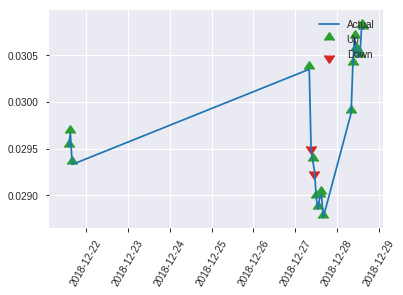


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.412896021092738
RMSE: 0.6425698569748958
LogLoss: 1.872217165285602
Mean Per-Class Error: 0.3196298800067602
AUC: 0.7300997126922426
pr_auc: 0.671258817928667
Gini: 0.4601994253844852
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9629108450417555: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      60   62   0.5082   (62.0/122.0)
1      16   81   0.1649   (16.0/97.0)
Total  76   143  0.3562   (78.0/219.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.962911     0.675     142
max f2                       0.461273     0.817717  198
max f0point5                 0.99171      0.639175  96
max accuracy                 0.99171      0.680365  96
max precision                0.999988     1         0
max recall                   0.0853583    1         212
max specificity              0.999988     1         0
max absolute_mcc             0.988169     0.358685  104
max min_per_class_accuracy   0.988169     0.680328  104
max mean_per_class_accuracy  0.988169     0.68037   104

Gains/Lift Table: Avg response rate: 44.29 %, avg score: 86.74 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136986                   0.999927           1.50515   1.50515            0.666667         0.999968  0.666667                    0.999968            0.0206186       0.0206186                  50.5155   50.5155
    2        0.0228311                   0.99991            2.25773   1.80619            1                0.999914  0.8                         0.999946            0.0206186       0.0412371                  125.773   80.6186
    3        0.0319635                   0.999863           2.25773   1.9352             1                0.999893  0.857143                    0.999931            0.0206186       0.0618557                  125.773   93.5199
    4        0.0410959                   0.999801           2.25773   2.00687            1                0.999824  0.888889                    0.999907            0.0206186       0.0824742                  125.773   100.687
    5        0.0502283                   0.999709           1.12887   1.84724            0.5              0.999798  0.818182                    0.999887            0.0103093       0.0927835                  12.8866   84.7235
    6        0.100457                    0.999407           2.05248   1.94986            0.909091         0.999562  0.863636                    0.999725            0.103093        0.195876                   105.248   94.9859
    7        0.150685                    0.999061           1.64199   1.84724            0.727273         0.99925   0.818182                    0.999566            0.0824742       0.278351                   64.1987   84.7235
    8        0.200913                    0.997905           1.23149   1.6933             0.545455         0.998596  0.75                        0.999324            0.0618557       0.340206                   23.149    69.3299
    9        0.30137                     0.996424           1.23149   1.53936            0.545455         0.997263  0.681818                    0.998637            0.123711        0.463918                   23.149    53.9363
    10       0.401826                    0.993902           1.02624   1.41108            0.454545         0.995455  0.625                       0.997841            0.103093        0.56701                    2.62418   41.1082
    11       0.502283                    0.986381           1.33411   1.39569            0.590909         0.990572  0.618182                    0.996388            0.134021        0.701031                   33.4114   39.5689
    12       0.598174                    0.970771           0.752577  1.29259            0.333333         0.978323  0.572519                    0.993492            0.0721649       0.773196                   -24.7423  29.2595
    13       0.69863                     0.933732           0.718369  1.21003            0.318182         0.958222  0.535948                    0.98842             0.0721649       0.845361                   -28.1631  21.0026
    14       0.799087                    0.767467           0.718369  1.14822            0.318182         0.860419  0.508571                    0.972329            0.0721649       0.917526                   -28.1631  14.8218
    15       0.899543                    0.506619           0.615745  1.08875            0.272727         0.669125  0.482234                    0.938468            0.0618557       0.979381                   -38.4255  8.8754
    16       1                           0.00399615         0.205248  1                  0.0909091        0.231247  0.442922                    0.867423          

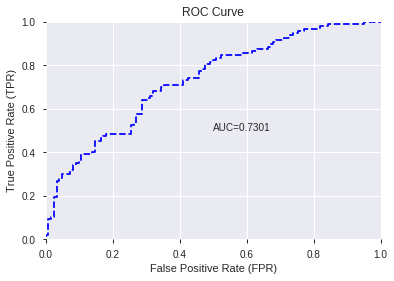

This function is available for GLM models only


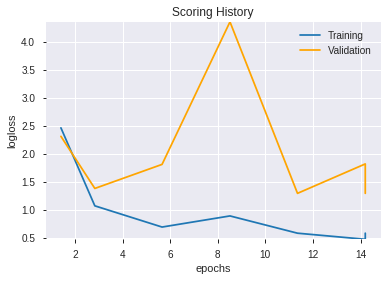

--2019-08-26 14:53:25--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.108.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.108.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_144620_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_144620_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_bd86',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['TRANGE',
 'CDLHAMMER',
 'BOP',
 'CDLCLOSINGMARUBOZU',
 'ADOSC',
 'VAR_8',
 'ROC_8',
 'CDLBELTHOLD',
 'AROONOSC_8',
 'ROCR100_24',
 'HT_PHASOR_inphase',
 'ROC_12',
 'BBANDS_upperband_20_6_3',
 'ROCP_30',
 'CDLLONGLINE',
 'ADX_20',
 'MFI_8',
 'ROCR_20',
 'PLUS_DM_30',
 'AROONOSC_12',
 'STOCHRSI_fastk',
 'MINUS_DI_30',
 'CCI_14',
 'BBANDS_lowerband_24_0_5',
 'ATR_8',
 'ADX_24',
 'TRIX_12',
 'PLUS_DI_14',
 'WILLR_8',
 'ADXR_8',
 'ROCR_8',
 'aroonup_20',
 'ATR_14',
 'AROONOSC_30',
 'ROCR100_30',
 'aroondown_20',
 'DX_12',
 'ADX_12',
 'ROC_30',
 'WILLR_24',
 'BBANDS_lowerband_24_2_5',
 'TSF_12',
 'MFI_12',
 'BETA_14',
 'MINUS_DM_12',
 'ROCP_12',
 'TYPPRICE',
 'STOCH_slowd',
 'NATR_20',
 'CDLHIGHWAVE',
 'MACD_signal',
 'CMO_20',
 'aroondown_30',
 'aroondown_24',
 'CCI_30',
 'ROCR_30',
 'MOM_24',
 'STDDEV_8',
 'CDLSHORTLINE',
 'STOCHF_fastd',
 'MACDFIX_24',
 'CCI_8',
 'RSI_14',
 'ATR_24',
 'LINEARREG_8',
 'MACDFIX_signal_24',
 'BBANDS_upperband_20_3_5',
 'LINEARREG_SLOPE_12',
 'MACDEXT_signa

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_145336_model_1  0.699763  0.647045              0.321362  0.477491  0.227997

variable  relative_importance  scaled_importance  percentage
0                        BOP             0.167990           1.000000    0.084504
1                     TRANGE             0.116295           0.692274    0.058500
2         CDLCLOSINGMARUBOZU             0.101151           0.602123    0.050882
3             STOCHRSI_fastk             0.091928           0.547222    0.046242
4               STOCHF_fastk             0.090731           0.540095    0.045640
..                       ...                  ...                ...         ...
96                    ATR_14             0.002500           0.014882    0.001258
97   BBANDS_lowerband_24_2_5             0.002353           0.014008    0.001184
98                   MA_20_1             0.002245           0.013365    0.001129
99                    BETA_8             0.001268           0.007549    0.000638
100  BBANDS_upperband_24_5_4             0.001109           0.006600    0.000558

[101 rows x 4 columns]

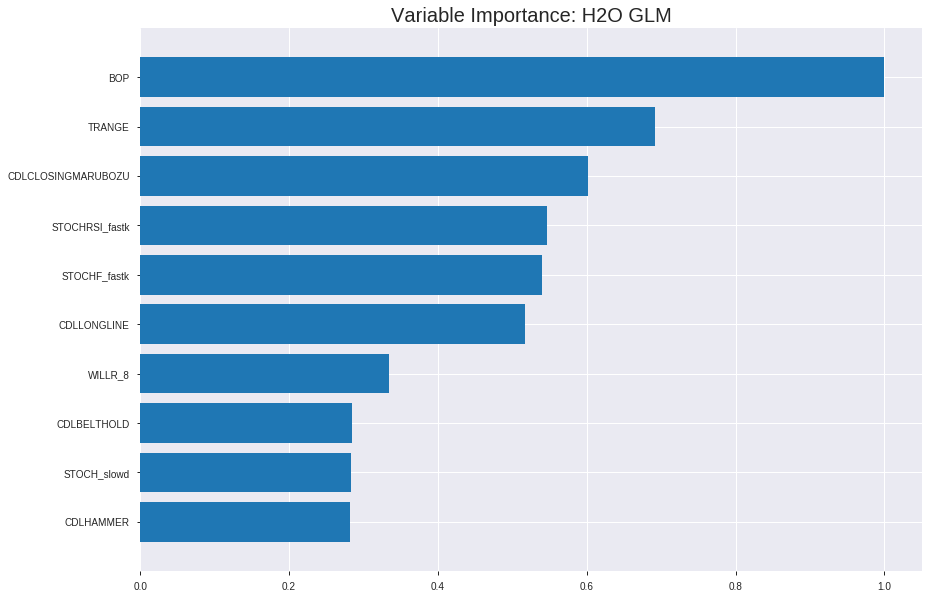

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_145336_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.21205648894265766
RMSE: 0.4604959163148547
LogLoss: 0.6135027006935746
Null degrees of freedom: 1530
Residual degrees of freedom: 1429
Null deviance: 2115.4819722816574
Residual deviance: 1878.5452695237254
AIC: 2082.5452695237254
AUC: 0.7386455194072733
pr_auc: 0.7033883661758181
Gini: 0.4772910388145466
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39396826960026976: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      385  432   0.5288   (432.0/817.0)
1      96   618   0.1345   (96.0/714.0)
Total  481  1050  0.3449   (528.0/1531.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.393968     0.70068   262
max f2                       0.238072     0.820276  372
max f0point5                 0.472889     0.652815  195
max accuracy                 0.472889     0.677335  195
max precision                0.811741     1         0
max recall                   0.159017     1         395
max specificity              0.811741     1         0
max absolute_mcc             0.451544     0.363133  214
max min_per_class_accuracy   0.472889     0.673195  195
max mean_per_class_accuracy  0.451544     0.680995  214

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 46.64 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104507                   0.752101           2.14426   2.14426            1                0.780602  1                           0.780602            0.022409        0.022409                   114.426   114.426
    2        0.0202482                   0.722137           2.00131   2.07509            0.933333         0.73467   0.967742                    0.758377            0.0196078       0.0420168                  100.131   107.509
    3        0.0300457                   0.70317            1.57246   1.91119            0.733333         0.714611  0.891304                    0.744106            0.0154062       0.057423                   57.2456   91.1186
    4        0.0404964                   0.692654           1.60819   1.83299            0.75             0.696989  0.854839                    0.731946            0.0168067       0.0742297                  60.8193   83.2994
    5        0.0502939                   0.682757           2.00131   1.86578            0.933333         0.687699  0.87013                     0.723327            0.0196078       0.0938375                  100.131   86.5783
    6        0.100588                    0.634435           1.72655   1.79616            0.805195         0.655398  0.837662                    0.689362            0.0868347       0.180672                   72.6545   79.6164
    7        0.150229                    0.601548           1.38248   1.65947            0.644737         0.616404  0.773913                    0.665254            0.0686275       0.2493                     38.2482   65.9469
    8        0.200523                    0.581554           1.39238   1.59248            0.649351         0.592269  0.742671                    0.646948            0.070028        0.319328                   39.2375   59.2478
    9        0.300457                    0.541329           1.37345   1.51963            0.640523         0.560608  0.708696                    0.618231            0.137255        0.456583                   37.3446   51.9626
    10       0.400392                    0.502249           1.1352    1.42368            0.529412         0.522687  0.663948                    0.594384            0.113445        0.570028                   13.5195   42.3675
    11       0.500327                    0.469095           1.19125   1.37725            0.555556         0.486037  0.642298                    0.572743            0.119048        0.689076                   19.1254   37.7252
    12       0.600261                    0.430605           0.896944  1.29729            0.418301         0.450492  0.605005                    0.55239             0.0896359       0.778711                   -10.3056  29.7288
    13       0.700196                    0.387941           0.910959  1.24215            0.424837         0.410137  0.579291                    0.532087            0.0910364       0.869748                   -8.90408  24.2149
    14       0.800131                    0.343546           0.574605  1.15877            0.267974         0.3674    0.540408                    0.511518            0.057423        0.927171                   -42.5395  15.8774
    15       0.900065                    0.296262           0.406428  1.07524            0.189542         0.321408  0.501451                    0.49041             0.0406162       0.967787                   -59.3572  7.5241
    16       1                           0.143767           0.322339  1                  0.150327         0.249773  0.466362                    0.466362          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.22004897331694387
RMSE: 0.4690937788086129
LogLoss: 0.6328609572677291
Null degrees of freedom: 437
Residual degrees of freedom: 336
Null deviance: 603.5241039768543
Residual deviance: 554.3861985665307
AIC: 758.3861985665307
AUC: 0.7137941919191919
pr_auc: 0.6251117645171061
Gini: 0.4275883838383838
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4398697300849983: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      106  134  0.5583   (134.0/240.0)
1      18   180  0.0909   (18.0/198.0)
Total  124  314  0.347    (152.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.43987      0.703125  281
max f2                       0.350433     0.826939  342
max f0point5                 0.452592     0.624108  270
max accuracy                 0.473987     0.659817  249
max precision                0.692972     0.794872  38
max recall                   0.195499     1         396
max specificity              0.916873     0.995833  0
max absolute_mcc             0.43987      0.387498  281
max min_per_class_accuracy   0.525967     0.633333  195
max mean_per_class_accuracy  0.452592     0.679419  270

Gains/Lift Table: Avg response rate: 45.21 %, avg score: 51.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.823876           0.884848  0.884848           0.4              0.885186  0.4                         0.885186            0.010101        0.010101                   -11.5152  -11.5152
    2        0.0205479                   0.771076           2.21212   1.47475            1                0.796868  0.666667                    0.845934            0.020202        0.030303                   121.212   47.4747
    3        0.0319635                   0.761174           1.32727   1.42208            0.6              0.76679   0.642857                    0.817668            0.0151515       0.0454545                  32.7273   42.2078
    4        0.0410959                   0.742554           1.65909   1.47475            0.75             0.747552  0.666667                    0.802087            0.0151515       0.0606061                  65.9091   47.4747
    5        0.0502283                   0.730354           1.65909   1.50826            0.75             0.73463   0.681818                    0.789822            0.0151515       0.0757576                  65.9091   50.8264
    6        0.100457                    0.688076           1.91047   1.70937            0.863636         0.705163  0.772727                    0.747493            0.0959596       0.171717                   91.0468   70.9366
    7        0.150685                    0.660237           1.40771   1.60882            0.636364         0.67297   0.727273                    0.722652            0.0707071       0.242424                   40.7713   60.8815
    8        0.200913                    0.628989           1.20661   1.50826            0.545455         0.640723  0.681818                    0.70217             0.0606061       0.30303                    20.6612   50.8264
    9        0.30137                     0.588053           1.05579   1.35744            0.477273         0.604982  0.613636                    0.669774            0.106061        0.409091                   5.57851   35.7438
    10       0.399543                    0.558546           1.38901   1.36519            0.627907         0.573661  0.617143                    0.646157            0.136364        0.545455                   38.9006   36.5195
    11       0.5                         0.521255           1.05579   1.30303            0.477273         0.539848  0.589041                    0.624798            0.106061        0.651515                   5.57851   30.303
    12       0.600457                    0.482133           1.15634   1.27849            0.522727         0.501807  0.577947                    0.604222            0.116162        0.767677                   15.6336   27.8488
    13       0.69863                     0.446102           1.23467   1.27233            0.55814          0.466127  0.575163                    0.584816            0.121212        0.888889                   23.4672   27.2331
    14       0.799087                    0.396997           0.402204  1.16294            0.181818         0.421081  0.525714                    0.564233            0.040404        0.929293                   -59.7796  16.2944
    15       0.899543                    0.328543           0.603306  1.10045            0.272727         0.364594  0.497462                    0.541938            0.0606061       0.989899                   -39.6694  10.0446
    16       1                           0.0528011          0.100551  1                  0.0454545        0.264532  0.452055                    0.514071         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 14:53:37  0.000 sec   2            18        102           1.36399           1.35679
    2019-08-26 14:53:37  0.026 sec   4            13        102           1.35894           1.35143
    2019-08-26 14:53:37  0.055 sec   6            9.5       102           1.35272           1.34504
    2019-08-26 14:53:37  0.081 sec   8            6.9       102           1.34519           1.33764
    2019-08-26 14:53:37  0.107 sec   10           5         102           1.33619           1.32913
    2019-08-26 14:53:37  0.134 sec   12           3.7       102           1.32564           1.31962
    2019-08-26 14:53:37  0.162 sec   14           2.7       102           1.31355           1.3093
    2019-08-26 14:53:37  0.190 sec   16           1.9       102           1.30012           1.29865
    2019-08-26 14:53:37  0.216 sec   18           1.4       102           1.28568           1.28835
    2019-08-26 14:53:37  0.245 sec   20           1         102           1.27069           1.27914
    2019-08-26 14:53:37  0.273 sec   22           0.75      102           1.25564           1.27186
    2019-08-26 14:53:37  0.300 sec   24           0.55      102           1.24098           1.26723
    2019-08-26 14:53:37  0.326 sec   26           0.4       102           1.22701           1.26572
    2019-08-26 14:53:37  0.353 sec   28           0.29      102           1.21397           1.26761
    2019-08-26 14:53:37  0.384 sec   30           0.21      102           1.202             1.273
    2019-08-26 14:53:37  0.411 sec   32           0.15      102           1.19117           1.28186
    2019-08-26 14:53:37  0.438 sec   34           0.11      102           1.18148           1.29394
    2019-08-26 14:53:37  0.472 sec   36           0.081     102           1.17295           1.30895

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6712328767123288)

('F1', 0.6755555555555557)

('auc', 0.6997633936116275)

('logloss', 0.6470452163636218)

('mean_per_class_error', 0.3213621767787731)

('rmse', 0.47749061492425976)

('mse', 0.22799728734074773)

glm prediction progress: |████████████████████████████████████████████████| 100%


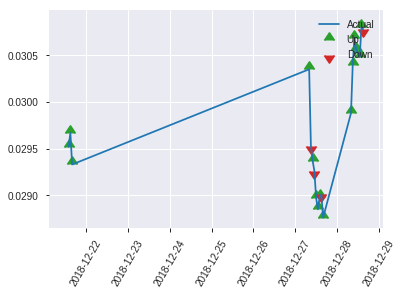


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.22799728734074773
RMSE: 0.47749061492425976
LogLoss: 0.6470452163636218
Null degrees of freedom: 218
Residual degrees of freedom: 117
Null deviance: 301.2230274583454
Residual deviance: 283.4058047672663
AIC: 487.4058047672663
AUC: 0.6997633936116275
pr_auc: 0.6159352754562244
Gini: 0.3995267872232551
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5192588953788406: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      70   52   0.4262   (52.0/122.0)
1      21   76   0.2165   (21.0/97.0)
Total  91   128  0.3333   (73.0/219.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.519259     0.675556  127
max f2                       0.386832     0.811744  190
max f0point5                 0.559962     0.628627  104
max accuracy                 0.559962     0.671233  104
max precision                0.853148     1         0
max recall                   0.296878     1         210
max specificity              0.853148     1         0
max absolute_mcc             0.519259     0.360117  127
max min_per_class_accuracy   0.559962     0.670103  104
max mean_per_class_accuracy  0.519259     0.678638  127

Gains/Lift Table: Avg response rate: 44.29 %, avg score: 53.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136986                   0.773102           2.25773   2.25773            1                0.808454  1                           0.808454            0.0309278       0.0309278                  125.773   125.773
    2        0.0228311                   0.731867           1.12887   1.80619            0.5              0.733901  0.8                         0.778633            0.0103093       0.0412371                  12.8866   80.6186
    3        0.0319635                   0.725711           1.12887   1.61267            0.5              0.729569  0.714286                    0.764614            0.0103093       0.0515464                  12.8866   61.2666
    4        0.0410959                   0.720449           2.25773   1.75601            1                0.722557  0.777778                    0.755268            0.0206186       0.0721649                  125.773   75.6014
    5        0.0502283                   0.710259           1.12887   1.64199            0.5              0.715838  0.727273                    0.748099            0.0103093       0.0824742                  12.8866   64.1987
    6        0.100457                    0.679955           1.43674   1.53936            0.636364         0.698738  0.681818                    0.723418            0.0721649       0.154639                   43.6739   53.9363
    7        0.150685                    0.665283           1.02624   1.36832            0.454545         0.671944  0.606061                    0.70626             0.0515464       0.206186                   2.62418   36.8322
    8        0.200913                    0.641573           1.64199   1.43674            0.727273         0.653269  0.636364                    0.693012            0.0824742       0.28866                    64.1987   43.6739
    9        0.30137                     0.610571           1.23149   1.36832            0.545455         0.625493  0.606061                    0.670506            0.123711        0.412371                   23.149    36.8322
    10       0.401826                    0.577036           1.43674   1.38543            0.636364         0.594254  0.613636                    0.651443            0.14433         0.556701                   43.6739   38.5426
    11       0.502283                    0.548166           1.23149   1.35464            0.545455         0.563003  0.6                         0.633755            0.123711        0.680412                   23.149    35.4639
    12       0.598174                    0.514018           1.07511   1.30983            0.47619          0.532964  0.580153                    0.617598            0.103093        0.783505                   7.51105   30.9829
    13       0.69863                     0.484603           0.718369  1.22478            0.318182         0.500919  0.542484                    0.60082             0.0721649       0.85567                    -28.1631  22.4783
    14       0.799087                    0.429447           0.410497  1.12242            0.181818         0.45837   0.497143                    0.582912            0.0412371       0.896907                   -58.9503  12.2415
    15       0.899543                    0.374169           0.718369  1.07729            0.318182         0.39826   0.477157                    0.562291            0.0721649       0.969072                   -28.1631  7.72934
    16       1                           0.209654           0.307873  1                  0.136364         0.30285   0.442922                    0.536229         

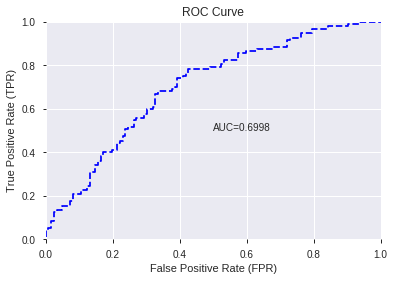

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


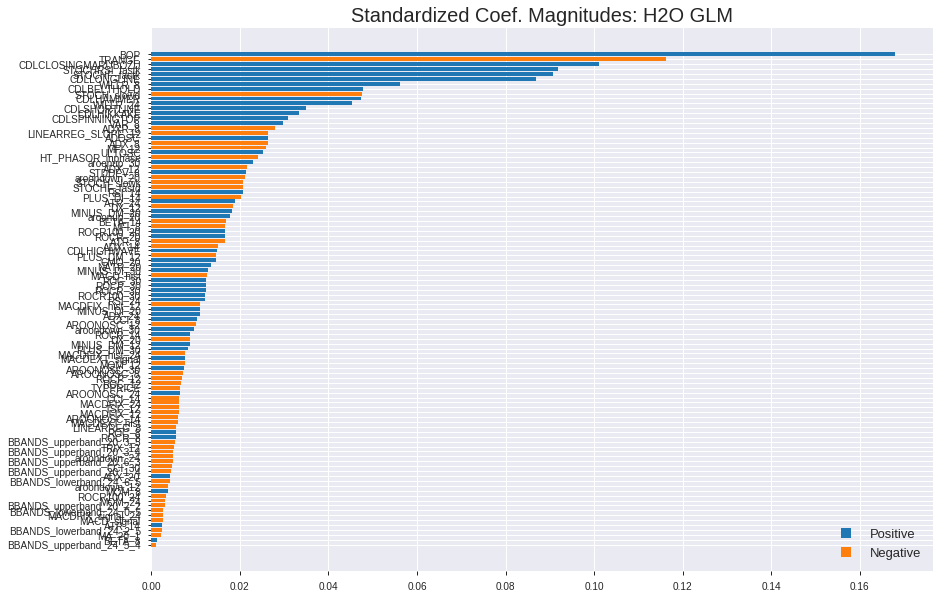

'log_likelihood'
--2019-08-26 14:53:43--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.136.148
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.136.148|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_145336_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_145336_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_bd86',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'TRANGE',
 'CDLCLOSINGMARUBOZU',
 'STOCHRSI_fastk',
 'STOCHF_fastk',
 'CDLLONGLINE',
 'WILLR_8',
 'CDLBELTHOLD',
 'STOCH_slowd',
 'CDLHAMMER',
 'WILLR_24',
 'CDLSHORTLINE',
 'CDLHIKKAKE',
 'CDLSPINNINGTOP',
 'VAR_8',
 'ADXR_8',
 'LINEARREG_SLOPE_12',
 'ADOSC',
 'ADX_8',
 'MFI_12',
 'ULTOSC',
 'HT_PHASOR_inphase',
 'aroonup_30',
 'ADX_12',
 'STDDEV_8',
 'aroondown_20',
 'STOCH_slowk',
 'STOCHF_fastd',
 'RSI_14',
 'PLUS_DI_14',
 'ATR_24',
 'DX_12',
 'MINUS_DM_20',
 'aroonup_20',
 'BETA_14',
 'MFI_8',
 'ROCR100_20',
 'ROCR_20',
 'ATR_8',
 'ADX_14',
 'CDLHIGHWAVE',
 'PLUS_DM_12',
 'CMO_20',
 'NATR_20',
 'MINUS_DI_30',
 'MACD_hist',
 'ROC_30',
 'ROCP_30',
 'ROCR_30',
 'ROCR100_30',
 'RSI_24',
 'MACDFIX_hist_12',
 'MINUS_DI_20',
 'ADX_24',
 'CCI_8',
 'AROONOSC_12',
 'aroondown_30',
 'ROCR_14',
 'DX_20',
 'MINUS_DM_12',
 'PLUS_DM_30',
 'MACDFIX_hist_24',
 'MACDEXT_signal',
 'MOM_12',
 'AROONOSC_30',
 'AROONOSC_8',
 'ROCP_12',
 'ROC_12',
 'TYPPRICE',
 'AROONOSC_24',
 'CCI_14',
 'MACDF

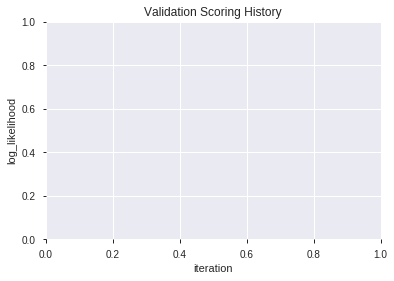

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_145355_model_7  0.742099  0.591146              0.333277  0.452430  0.204693
1  XGBoost_grid_1_AutoML_20190826_145355_model_6  0.729170  0.610458              0.325080  0.461265  0.212765
2  XGBoost_grid_1_AutoML_20190826_145355_model_1  0.727142  0.601204              0.315827  0.457240  0.209068
3               XGBoost_3_AutoML_20190826_145355  0.718016  0.610658              0.336319  0.461593  0.213068
4  XGBoost_grid_1_AutoML_20190826_145355_model_5  0.717678  0.617473              0.340417  0.464723  0.215968
5  XGBoost_grid_1_AutoML_20190826_145355_model_3  0.714974  0.604135              0.358670  0.458926  0.210613
6               XGBoost_1_AutoML_20190826_145355  0.714889  0.607432              0.337375  0.460476  0.212038
7  XGBoost_grid_1_AutoML_20190826_145355_model_2  0.714467  0.609517              0.312912  0.460193  0.211777
8               XGBoost_2_AutoML_20190826_145355  0.711932  0.610453              0.332094  0.461641  0.213112
9  XGBoost_grid_1_AutoML_20190826_145355_model_4  0.710918  0.614959              0.317010  0.462993  0.214363

variable  relative_importance  scaled_importance  percentage
0              BOP          1200.698730           1.000000    0.120935
1           TRANGE           705.365295           0.587462    0.071045
2   STOCHRSI_fastk           411.660645           0.342851    0.041463
3     STOCHF_fastk           379.319031           0.315915    0.038205
4      STOCH_slowk           234.567993           0.195360    0.023626
..             ...                  ...                ...         ...
94  CDLSPINNINGTOP            14.781149           0.012310    0.001489
95      MACDFIX_12            11.678584           0.009726    0.001176
96      MACDFIX_24             8.370482           0.006971    0.000843
97         ROCR_30             7.830805           0.006522    0.000789
98     CDLBELTHOLD             3.017984           0.002514    0.000304

[99 rows x 4 columns]

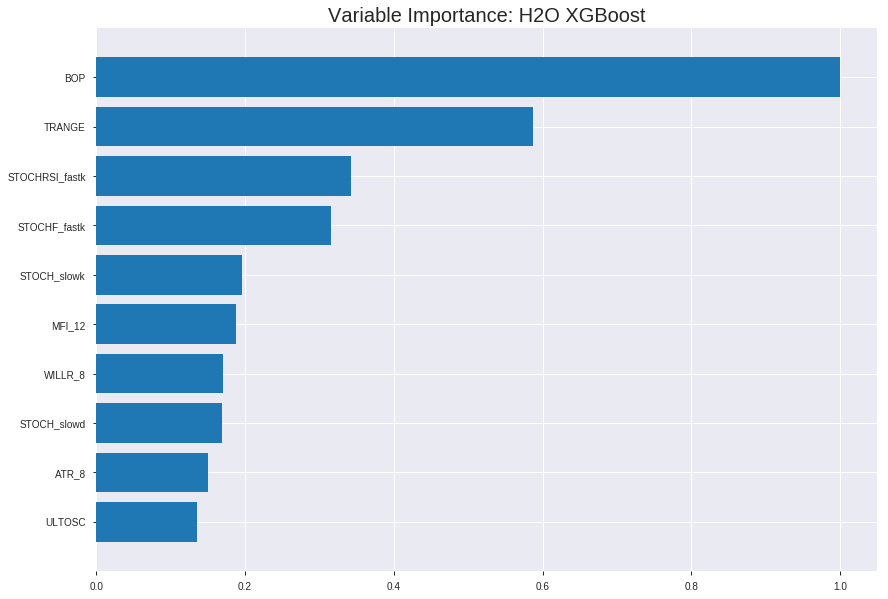

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_145355_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.10389409632150762
RMSE: 0.32232607142691333
LogLoss: 0.3658680480387828
Mean Per-Class Error: 0.08925871450171252
AUC: 0.9731270721262802
pr_auc: 0.970893743733984
Gini: 0.9462541442525605
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5236900746822357: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      781  36   0.0441   (36.0/817.0)
1      96   618  0.1345   (96.0/714.0)
Total  877  654  0.0862   (132.0/1531.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.52369      0.903509  178
max f2                       0.369155     0.926321  245
max f0point5                 0.560532     0.937699  164
max accuracy                 0.52369      0.913782  178
max precision                0.937137     1         0
max recall                   0.272652     1         290
max specificity              0.937137     1         0
max absolute_mcc             0.52369      0.828457  178
max min_per_class_accuracy   0.472288     0.907563  199
max mean_per_class_accuracy  0.52369      0.910741  178

Gains/Lift Table: Avg response rate: 46.64 %, avg score: 46.62 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104507                   0.900227           2.14426    2.14426            1                0.915612  1                           0.915612            0.022409        0.022409                   114.426   114.426
    2        0.0202482                   0.882134           2.14426    2.14426            1                0.890454  1                           0.903439            0.0210084       0.0434174                  114.426   114.426
    3        0.0300457                   0.867627           2.14426    2.14426            1                0.875564  1                           0.894349            0.0210084       0.0644258                  114.426   114.426
    4        0.0404964                   0.856816           2.14426    2.14426            1                0.862488  1                           0.886127            0.022409        0.0868347                  114.426   114.426
    5        0.0502939                   0.845615           2.14426    2.14426            1                0.850254  1                           0.879139            0.0210084       0.107843                   114.426   114.426
    6        0.100588                    0.809139           2.14426    2.14426            1                0.827867  1                           0.853503            0.107843        0.215686                   114.426   114.426
    7        0.150229                    0.770351           2.14426    2.14426            1                0.792415  1                           0.833318            0.106443        0.322129                   114.426   114.426
    8        0.200523                    0.739747           2.14426    2.14426            1                0.753207  1                           0.813225            0.107843        0.429972                   114.426   114.426
    9        0.300457                    0.660238           2.0882     2.12561            0.973856         0.699172  0.991304                    0.77529             0.208683        0.638655                   108.82    112.561
    10       0.400392                    0.557523           1.90601    2.0708             0.888889         0.6073    0.965742                    0.733361            0.190476        0.829132                   90.6007   107.08
    11       0.500327                    0.440952           0.938989   1.84473            0.437908         0.496986  0.860313                    0.686148            0.0938375       0.922969                   -6.10113  84.4733
    12       0.600261                    0.354552           0.546575   1.62861            0.254902         0.396178  0.759521                    0.637872            0.0546218       0.977591                   -45.3425  62.8609
    13       0.700196                    0.274424           0.210221   1.42617            0.0980392        0.31638   0.665112                    0.591987            0.0210084       0.998599                   -78.9779  42.6171
    14       0.800131                    0.204936           0.0140148  1.2498             0.00653595       0.237813  0.582857                    0.547752            0.00140056      1                          -98.5985  24.9796
    15       0.900065                    0.137823           0          1.11103            0                0.172569  0.518142                    0.506095            0               1                          -100      11.103
    16       1                           0.0494616          0          1                  0                0.106386  0.466362                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20373277574501714
RMSE: 0.45136767246338894
LogLoss: 0.5933759413598536
Mean Per-Class Error: 0.30334595959595956
AUC: 0.7456334175084175
pr_auc: 0.6408413876306135
Gini: 0.491266835016835
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3271437883377075: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      115  125  0.5208   (125.0/240.0)
1      25   173  0.1263   (25.0/198.0)
Total  140  298  0.3425   (150.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.327144     0.697581  270
max f2                       0.191382     0.83118   336
max f0point5                 0.506708     0.663673  184
max accuracy                 0.506708     0.696347  184
max precision                0.665094     0.75      88
max recall                   0.0862383    1         386
max specificity              0.903438     0.995833  0
max absolute_mcc             0.466024     0.392298  211
max min_per_class_accuracy   0.497485     0.681818  192
max mean_per_class_accuracy  0.466024     0.696654  211

Gains/Lift Table: Avg response rate: 45.21 %, avg score: 46.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.863994           1.32727   1.32727            0.6              0.881889   0.6                         0.881889            0.0151515       0.0151515                  32.7273   32.7273
    2        0.0205479                   0.843135           1.10606   1.22896            0.5              0.851755   0.555556                    0.868496            0.010101        0.0252525                  10.6061   22.8956
    3        0.0319635                   0.832185           1.32727   1.26407            0.6              0.838331   0.571429                    0.857723            0.0151515       0.040404                   32.7273   26.4069
    4        0.0410959                   0.816049           1.10606   1.22896            0.5              0.827099   0.555556                    0.850918            0.010101        0.0505051                  10.6061   22.8956
    5        0.0502283                   0.805389           1.65909   1.30716            0.75             0.813751   0.590909                    0.84416             0.0151515       0.0656566                  65.9091   30.7163
    6        0.100457                    0.769116           1.70937   1.50826            0.772727         0.7872     0.681818                    0.81568             0.0858586       0.151515                   70.9366   50.8264
    7        0.150685                    0.728828           1.40771   1.47475            0.636364         0.748121   0.666667                    0.79316             0.0707071       0.222222                   40.7713   47.4747
    8        0.200913                    0.678381           2.01102   1.60882            0.909091         0.704189   0.727273                    0.770917            0.10101         0.323232                   101.102   60.8815
    9        0.30137                     0.61055            1.35744   1.52502            0.613636         0.640168   0.689394                    0.727334            0.136364        0.459596                   35.7438   52.5023
    10       0.399543                    0.538199           1.28612   1.46632            0.581395         0.577548   0.662857                    0.69053             0.126263        0.585859                   28.6117   46.632
    11       0.5                         0.479777           1.15634   1.40404            0.522727         0.50906    0.634703                    0.65407             0.116162        0.70202                    15.6336   40.404
    12       0.600457                    0.406595           1.05579   1.34578            0.477273         0.443818   0.608365                    0.618895            0.106061        0.808081                   5.57851   34.5777
    13       0.69863                     0.31218            0.720226  1.25787            0.325581         0.356196   0.568627                    0.58198             0.0707071       0.878788                   -27.9774  25.7873
    14       0.799087                    0.231917           0.603306  1.17558            0.272727         0.269193   0.531429                    0.542658            0.0606061       0.939394                   -39.6694  17.5584
    15       0.899543                    0.133735           0.402204  1.08922            0.181818         0.182346   0.492386                    0.50242             0.040404        0.979798                   -59.7796  8.9217
    16       1                           0.0456982          0.201102  1                  0.0909091        0.0975555  0.452055                    0.


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:54:10  9.432 sec   0                  0.5              0.693147            0.5             0                  1                0.533638                         0.5                0.693147              0.5               0                    1                  0.547945
    2019-08-26 14:54:10  9.620 sec   5                  0.469187         0.633028            0.86884         0.853622           2.01024          0.217505                         0.48399            0.661438              0.711143          0.618187             1.32727            0.374429
    2019-08-26 14:54:10  9.720 sec   10                 0.444028         0.585446            0.89392         0.883937           2.14426          0.192685                         0.471046           0.635851              0.734638          0.641719             1.32727            0.326484
    2019-08-26 14:54:11  9.821 sec   15                 0.422218         0.54493             0.911958        0.901764           2.14426          0.175702                         0.463164           0.619762              0.738142          0.647219             1.32727            0.30137
    2019-08-26 14:54:11  9.913 sec   20                 0.405659         0.51427             0.923712        0.91655            2.14426          0.159373                         0.457546           0.607789              0.740236          0.643096             1.32727            0.30137
    2019-08-26 14:54:11  10.013 sec  25                 0.389551         0.48478             0.933193        0.926934           2.14426          0.143697                         0.455224           0.602782              0.741383          0.639725             1.32727            0.312785
    2019-08-26 14:54:11  10.108 sec  30                 0.377516         0.46242             0.938922        0.935307           2.14426          0.12998                          0.45129            0.594357              0.750579          0.646301             0.884848           0.305936
    2019-08-26 14:54:11  10.201 sec  35                 0.366964         0.44337             0.946208        0.94029            2.14426          0.121489                         0.451029           0.593282              0.748411          0.650924             0.884848           0.310502
    2019-08-26 14:54:11  10.298 sec  40                 0.35631          0.424266            0.952851        0.949771           2.14426          0.116264                         0.450221           0.591498              0.750179          0.648865             0.884848           0.335616
    2019-08-26 14:54:11  10.386 sec  45                 0.347501         0.408884            0.958706        0.956019           2.14426          0.106466                         0.450596           0.592422              0.749253          0.643278             0.884848           0.321918
    2019-08-26 14:54:11  10.474 sec  50                 0.339344         0.394378            0.962395        0.959738           2.14426          0.097322                         0.45026            0.591275              0.748359          0.646858             0.884848           0.351598
    2019-08-26 14:54:11  10.562 sec  55                 0.331052         0.380418            0.967823        0.965871           2.14426          0.0914435                        0.45054            0.591764              0.74717           0.6

Variable Importances: 


variable        relative_importance    scaled_importance      percentage
--------------  ---------------------  ---------------------  ---------------------
BOP             1200.69873046875       1.0                    0.12093485144783704
TRANGE          705.3652954101562      0.587462347973653      0.07104467178339129
STOCHRSI_fastk  411.66064453125        0.3428509034656334     0.041462623079373095
STOCHF_fastk    379.31903076171875     0.31591524263012544    0.03820516293758162
STOCH_slowk     234.5679931640625      0.1953595745641271     0.023625781128825355
---             ---                    ---                    ---
CDLSPINNINGTOP  14.781148910522461     0.012310456016516261   0.001488763169612526
MACDFIX_12      11.678584098815918     0.009726489919962375   0.0011762716135795344
MACDFIX_24      8.370482444763184      0.006971342795952959   0.0008430783054205201
ROCR_30         7.830804824829102      0.006521873161115089   0.0007887217619010888
CDLBELTHOLD     3.017984390258789      0.0025135234290458316  0.0003039725825023156


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6986301369863014)

('F1', 0.6901960784313725)

('auc', 0.7420990366739901)

('logloss', 0.591146063078064)

('mean_per_class_error', 0.3095741085009296)

('rmse', 0.4524301995610713)

('mse', 0.20469308547487078)

xgboost prediction progress: |████████████████████████████████████████████| 100%


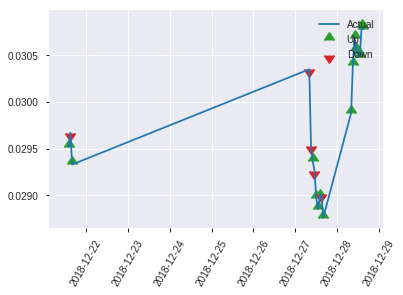


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20469308547487078
RMSE: 0.4524301995610713
LogLoss: 0.591146063078064
Mean Per-Class Error: 0.3095741085009296
AUC: 0.7420990366739901
pr_auc: 0.6628013636793326
Gini: 0.48419807334798026
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3308907747268677: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      52   70   0.5738   (70.0/122.0)
1      9    88   0.0928   (9.0/97.0)
Total  61   158  0.3607   (79.0/219.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.330891     0.690196  157
max f2                       0.197133     0.831889  188
max f0point5                 0.569056     0.662252  88
max accuracy                 0.569056     0.69863   88
max precision                0.88043      1         0
max recall                   0.158795     1         196
max specificity              0.88043      1         0
max absolute_mcc             0.569056     0.385172  88
max min_per_class_accuracy   0.510401     0.663934  105
max mean_per_class_accuracy  0.569056     0.690426  88

Gains/Lift Table: Avg response rate: 44.29 %, avg score: 48.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136986                   0.853042           2.25773   2.25773            1                0.867139  1                           0.867139            0.0309278       0.0309278                  125.773   125.773
    2        0.0228311                   0.844267           2.25773   2.25773            1                0.848241  1                           0.85958             0.0206186       0.0515464                  125.773   125.773
    3        0.0319635                   0.837273           1.12887   1.9352             0.5              0.841646  0.857143                    0.854456            0.0103093       0.0618557                  12.8866   93.5199
    4        0.0410959                   0.827933           2.25773   2.00687            1                0.832863  0.888889                    0.849657            0.0206186       0.0824742                  125.773   100.687
    5        0.0502283                   0.82452            0         1.64199            0                0.825717  0.727273                    0.845305            0               0.0824742                  -100      64.1987
    6        0.100457                    0.768337           1.64199   1.64199            0.727273         0.793389  0.727273                    0.819347            0.0824742       0.164948                   64.1987   64.1987
    7        0.150685                    0.722484           1.84724   1.7104             0.818182         0.746255  0.757576                    0.794983            0.0927835       0.257732                   84.7235   71.0403
    8        0.200913                    0.69669            1.23149   1.59067            0.545455         0.711041  0.704545                    0.773997            0.0618557       0.319588                   23.149    59.0675
    9        0.30137                     0.627149           1.23149   1.47095            0.545455         0.654802  0.651515                    0.734265            0.123711        0.443299                   23.149    47.0947
    10       0.401826                    0.569058           1.64199   1.51371            0.727273         0.599922  0.670455                    0.70068             0.164948        0.608247                   64.1987   51.3707
    11       0.502283                    0.504624           0.820993  1.37516            0.363636         0.53066   0.609091                    0.666676            0.0824742       0.690722                   -17.9007  37.5164
    12       0.598174                    0.437528           0.967599  1.30983            0.428571         0.475133  0.580153                    0.63597             0.0927835       0.783505                   -3.24006  30.9829
    13       0.69863                     0.34906            0.923618  1.2543             0.409091         0.388858  0.555556                    0.600438            0.0927835       0.876289                   -7.63824  25.4296
    14       0.799087                    0.24477            0.615745  1.17402            0.272727         0.298296  0.52                        0.562454            0.0618557       0.938144                   -38.4255  17.4021
    15       0.899543                    0.158101           0.615745  1.11168            0.272727         0.203975  0.492386                    0.522421            0.0618557       1                          -38.4255  11.1675
    16       1                           0.0529431          0         1                  0                0.100129  0.442922                    0.479999         

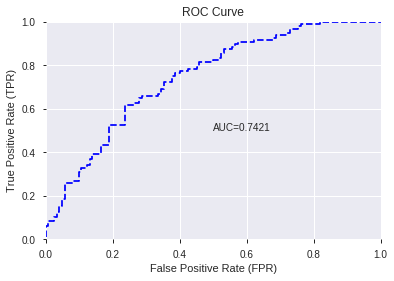

This function is available for GLM models only


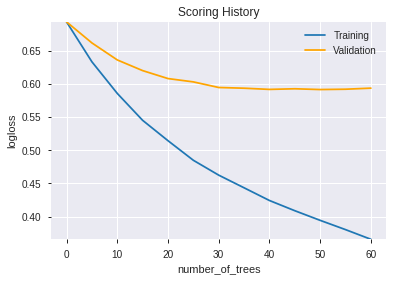

--2019-08-26 14:54:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.1.144
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.1.144|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.jav

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_145355_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_145355_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_bd86',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'TRANGE',
 'STOCHRSI_fastk',
 'STOCHF_fastk',
 'STOCH_slowk',
 'MFI_12',
 'WILLR_8',
 'STOCH_slowd',
 'ATR_8',
 'ULTOSC',
 'HT_PHASOR_inphase',
 'ADX_8',
 'STDDEV_8',
 'ADOSC',
 'MACDEXT_hist',
 'CCI_14',
 'DX_12',
 'PLUS_DM_30',
 'MINUS_DM_12',
 'MFI_8',
 'CCI_8',
 'ATR_24',
 'AROONOSC_30',
 'NATR_20',
 'BETA_8',
 'MACDFIX_hist_24',
 'BETA_14',
 'ADX_20',
 'PLUS_DI_14',
 'ROCR_14',
 'ROC_30',
 'MINUS_DM_20',
 'ATR_14',
 'LINEARREG_SLOPE_12',
 'aroonup_20',
 'ADXR_8',
 'DX_20',
 'ROCR_20',
 'MACDFIX_hist_12',
 'PLUS_DM_12',
 'MOM_8',
 'STOCHF_fastd',
 'RSI_14',
 'MACD_hist',
 'CCI_30',
 'BBANDS_upperband_24_5_4',
 'MINUS_DI_20',
 'BBANDS_lowerband_24_6_5',
 'aroondown_20',
 'WILLR_24',
 'MACDFIX_signal_24',
 'BBANDS_upperband_20_3_5',
 'MINUS_DI_30',
 'MACDEXT_signal',
 'MOM_12',
 'RSI_24',
 'aroonup_30',
 'ROCR100_24',
 'MOM_24',
 'ROC_8',
 'AROONOSC_24',
 'AROONOSC_12',
 'TSF_12',
 'TYPPRICE',
 'ROC_12',
 'VAR_8',
 'aroondown_30',
 'BBANDS_upperband_20_6_3',
 'aroondown_12',

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.726
GLM             0.694
XGBoost         0.712
dtype: float64

DeepLearning    GLM  XGBoost
All          0.703  0.689    0.680
DLF          0.721  0.694    0.712
Fwe          0.676  0.676    0.680
RFE          0.680  0.671    0.699
XGBF         0.726  0.694    0.712





F1


DeepLearning    0.717
GLM             0.708
XGBoost         0.720
dtype: float64

DeepLearning    GLM  XGBoost
All          0.679  0.676    0.705
DLF          0.717  0.708    0.720
Fwe          0.691  0.694    0.713
RFE          0.675  0.676    0.690
XGBF         0.717  0.708    0.720





auc


DeepLearning    0.755
GLM             0.748
XGBoost         0.764
dtype: float64

DeepLearning    GLM  XGBoost
All          0.720  0.708    0.746
DLF          0.751  0.748    0.764
Fwe          0.736  0.728    0.737
RFE          0.730  0.700    0.742
XGBF         0.755  0.748    0.764





logloss


DeepLearning    1.872
GLM             0.658
XGBoost         0.596
dtype: float64

DeepLearning    GLM  XGBoost
All          0.708  0.658    0.590
DLF          0.653  0.588    0.571
Fwe          0.595  0.604    0.596
RFE          1.872  0.647    0.591
XGBF         0.586  0.588    0.571





mean_per_class_error


DeepLearning    0.320
GLM             0.323
XGBoost         0.310
dtype: float64

DeepLearning    GLM  XGBoost
All          0.298  0.321    0.307
DLF          0.276  0.295    0.280
Fwe          0.314  0.323    0.297
RFE          0.320  0.321    0.310
XGBF         0.270  0.295    0.280





rmse


DeepLearning    0.643
GLM             0.483
XGBoost         0.454
dtype: float64

DeepLearning    GLM  XGBoost
All          0.507  0.483    0.451
DLF          0.459  0.450    0.442
Fwe          0.453  0.457    0.454
RFE          0.643  0.477    0.452
XGBF         0.448  0.450    0.442





mse


DeepLearning    0.413
GLM             0.233
XGBoost         0.206
dtype: float64

DeepLearning    GLM  XGBoost
All          0.257  0.233    0.203
DLF          0.210  0.202    0.195
Fwe          0.205  0.209    0.206
RFE          0.413  0.228    0.205
XGBF         0.201  0.202    0.195

{'F1':       DeepLearning    GLM  XGBoost
 All          0.679    NaN      NaN
 DLF          0.717    NaN      NaN
 DLF            NaN  0.708      NaN
 DLF            NaN    NaN    0.720
 All            NaN  0.676      NaN
 All            NaN    NaN    0.705
 XGBF         0.717    NaN      NaN
 XGBF           NaN  0.708      NaN
 XGBF           NaN    NaN    0.720
 Fwe          0.691    NaN      NaN
 Fwe            NaN  0.694      NaN
 Fwe            NaN    NaN    0.713
 RFE          0.675    NaN      NaN
 RFE            NaN  0.676      NaN
 RFE            NaN    NaN    0.690,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.703    NaN      NaN
 DLF          0.721    NaN      NaN
 DLF            NaN  0.694      NaN
 DLF            NaN    NaN    0.712
 All            NaN  0.689      NaN
 All            NaN    NaN    0.680
 XGBF         0.726    NaN      NaN
 XGBF           NaN  0.694      NaN
 XGBF           NaN    NaN    0.712
 Fwe          0.676    NaN      NaN
 Fwe     